In [7]:
!pip install yellowbrick

Defaulting to user installation because normal site-packages is not writeable


In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib
%matplotlib inline
sns.set()
import missingno as msno
from datetime import date
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA

pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 500)

import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler

from scipy.cluster.hierarchy import linkage, dendrogram

from yellowbrick.cluster import KElbowVisualizer
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN,KMeans



pd.set_option('display.max_columns', None)

In [9]:
import warnings
warnings.filterwarnings("ignore")
sns.set(style="darkgrid",font_scale=1.5)
warnings.simplefilter(action='ignore', category="FutureWarning")
warnings.simplefilter("ignore", category="ConvergenceWarning")
warnings.filterwarnings("ignore")

In [10]:
def grab_col_names(dataframe, cat_th = 10, car_th = 20):

    # cat cols, cat_but_car

    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "object"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "object"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "object"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "object"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f"cat_cols: {len(cat_cols)}")
    print(f"num_cols: {len(num_cols)}")
    print(f"cat_but_car: {len(cat_but_car)}")
    print(f"num_but_cat: {len(num_but_cat)}")
    return cat_cols, num_cols, cat_but_car

In [11]:
def outlier_tresholds(dataframe, col_name, q1 = 0.25, q3 = 0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquartile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquartile_range
    low_limit = quartile1 - 1.5 * interquartile_range
    return low_limit, up_limit

In [12]:
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_tresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [13]:
def remove_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_tresholds(dataframe, col_name)
    df_without_outliers = dataframe[~((dataframe[col_name] < low_limit | dataframe[col_name] > up_limit))]
    return df_without_outliers

In [14]:
def count_outliers(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    outliers = dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)]
    return outliers.shape[0]

In [15]:
def grab_outliers(dataframe, col_name, index=False):
    low, up = outlier_thresholds(dataframe, col_name)  # Determination of lower and upper limits

    ## If the number of observations is greater than 10, retrieve the first 5 observations
    if dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].shape[0] > 10:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))])

    # If not, bring it all.
    else:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))])

    if index:
        outlier_index = dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].index
        return outlier_index

In [16]:
def replace_with_tresholds(dataframe, variable):
    low_limit, up_limit = outlier_tresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit),variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [17]:
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")

In [18]:
def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

In [19]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=True):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

In [20]:
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ration": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("###########################################")
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show()

In [21]:
def rare_analyser(dataframe, target, cat_cols):
    for col in cat_cols:
        print(col, ":", len(dataframe[col].value_counts()))
        print(pd.DataFrame({"COUNT": dataframe[col].value_counts(),
                            "RATIO": dataframe[col].value_counts() / len(dataframe),
                            "TARGET_MEAN": dataframe.groupby(col)[target].mean()}), end="\n\n\n")

In [22]:
def rare_encoder(dataframe, rare_perc):
    temp_df = dataframe.copy()

    rare_columns = [col for col in temp_df.columns if temp_df[col].dtypes == "O"
                    and (temp_df[col].value_counts() / len(temp_df) < rare_perc).any(axis=None)]

    for var in rare_columns:
        tmp = temp_df[var].value_counts() / len(temp_df)
        rare_labels = tmp[tmp < rare_perc].index
        temp_df[var] = np.where(temp_df[var].isin(rare_labels), 'Rare', temp_df[var])

    return temp_df

In [23]:
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show(block=True)

In [24]:
def regular():
    regular_season_df = pd.read_csv('2023-2024 NBA Player Stats - Regular.csv', sep=';', encoding='ISO-8859-1')
    return regular_season_df

In [25]:
def playoffs():
    playoffs_df = pd.read_csv('2023-2024 NBA Player Stats - Playoffs.csv', sep=';', encoding='ISO-8859-1')
    return playoffs_df

In [26]:
df = regular()

In [27]:
df.shape

(735, 30)

In [28]:
df.head()

Rk            Player   Pos  Age   Tm   G  GS     MP    FG    FGA   FG%    3P   3PA   3P%    2P    2PA   2P%  eFG%    FT   FTA   FT%   ORB   DRB    TRB   AST   STL   BLK   TOV    PF    PTS
0   1  Precious Achiuwa  PF-C   24  TOT  74  18 21.900 3.200  6.300 0.501 0.400 1.300 0.268 2.800  5.000 0.562 0.529 0.900 1.500 0.616 2.600 4.000  6.600 1.300 0.600 0.900 1.100 1.900  7.600
1   1  Precious Achiuwa     C   24  TOR  25   0 17.500 3.100  6.800 0.459 0.500 1.900 0.277 2.600  4.900 0.528 0.497 1.000 1.700 0.571 2.000 3.400  5.400 1.800 0.600 0.500 1.200 1.600  7.700
2   1  Precious Achiuwa    PF   24  NYK  49  18 24.200 3.200  6.100 0.525 0.300 1.000 0.260 2.900  5.100 0.578 0.547 0.900 1.400 0.643 2.900 4.300  7.200 1.100 0.600 1.100 1.100 2.100  7.600
3   2       Bam Adebayo     C   26  MIA  71  71 34.000 7.500 14.300 0.521 0.200 0.600 0.357 7.300 13.700 0.528 0.529 4.100 5.500 0.755 2.200 8.100 10.400 3.900 1.100 0.900 2.300 2.200 19.300
4   3      Ochai Agbaji    SG   23  TOT  78  28 21.000 2.300  5.600 0.411 0.800 2.700 0.294 1.500  2.800 0.523 0.483 0.500 0.700 0.661 0.900 1.800  2.800 1.100 0.600 0.600 0.800 1.500  5.800

In [29]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 735
Variables: 30
cat_cols: 1
num_cols: 27
cat_but_car: 2
num_but_cat: 0


In [30]:
print(num_cols)

['Rk', 'Age', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS']


In [31]:
print(cat_cols)

['Pos']


In [32]:
print(cat_but_car)

['Player', 'Tm']


In [33]:
df.describe()

Rk     Age       G      GS      MP      FG     FGA     FG%      3P     3PA     3P%      2P     2PA     2P%    eFG%      FT     FTA     FT%     ORB     DRB     TRB     AST     STL     BLK     TOV      PF     PTS
count 735.000 735.000 735.000 735.000 735.000 735.000 735.000 735.000 735.000 735.000 735.000 735.000 735.000 735.000 735.000 735.000 735.000 735.000 735.000 735.000 735.000 735.000 735.000 735.000 735.000 735.000 735.000
mean  282.210  26.155  40.880  18.441  18.265   2.973   6.423   0.443   0.909   2.582   0.297   2.063   3.840   0.510   0.510   1.171   1.509   0.689   0.822   2.423   3.239   1.934   0.587   0.384   0.944   1.457   8.022
std   166.859   4.372  25.581  25.024   9.736   2.357   4.783   0.120   0.849   2.167   0.153   1.873   3.341   0.152   0.126   1.300   1.586   0.255   0.733   1.741   2.321   1.800   0.394   0.401   0.758   0.784   6.482
min     1.000  19.000   1.000   0.000   0.500   0.000   0.000   0.000   0.000   0.000   0.000   0.000   0.000   0.000   0.000   0.000   0.000   0.000   0.000   0.000   0.000   0.000   0.000   0.000   0.000   0.000   0.000
25%   140.500  23.000  17.000   0.000  10.600   1.300   3.000   0.400   0.200   0.900   0.250   0.700   1.500   0.474   0.480   0.300   0.500   0.657   0.300   1.100   1.600   0.700   0.300   0.100   0.400   0.900   3.400
50%   290.000  25.000  41.000   5.000  17.200   2.300   5.000   0.446   0.700   2.100   0.336   1.500   2.800   0.528   0.529   0.800   1.000   0.760   0.600   2.100   2.800   1.300   0.500   0.300   0.700   1.400   6.100
75%   423.500  29.000  64.500  29.000  26.450   4.150   8.700   0.500   1.400   3.700   0.384   2.900   5.250   0.579   0.575   1.500   2.000   0.833   1.100   3.350   4.300   2.600   0.800   0.500   1.300   2.000  11.050
max   572.000  39.000  84.000  82.000  37.800  11.500  23.600   0.800   4.800  11.800   1.000  11.000  18.300   1.000   0.917  10.200  11.600   1.000   4.600  10.100  13.700  10.900   2.100   3.600   4.400   3.600  34.700

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 735 entries, 0 to 734
Data columns (total 30 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Rk      735 non-null    int64  
 1   Player  735 non-null    object 
 2   Pos     735 non-null    object 
 3   Age     735 non-null    int64  
 4   Tm      735 non-null    object 
 5   G       735 non-null    int64  
 6   GS      735 non-null    int64  
 7   MP      735 non-null    float64
 8   FG      735 non-null    float64
 9   FGA     735 non-null    float64
 10  FG%     735 non-null    float64
 11  3P      735 non-null    float64
 12  3PA     735 non-null    float64
 13  3P%     735 non-null    float64
 14  2P      735 non-null    float64
 15  2PA     735 non-null    float64
 16  2P%     735 non-null    float64
 17  eFG%    735 non-null    float64
 18  FT      735 non-null    float64
 19  FTA     735 non-null    float64
 20  FT%     735 non-null    float64
 21  ORB     735 non-null    float64
 22  DR

In [35]:
df["FGM"] = df["FG"] - df["FGA"]
df["FTM"] = df["FT"] - df["FTA"]

# Efficiency Rating
df['EFF'] = (df['PTS'] + df['TRB'] + df['AST'] + df['STL'] + df['BLK'] - 
            (df['FGA'] - df['FG']) - (df['FTA']  - df['FT'] - df['TOV']))
#
# Scoring Efficiency
df['Scoring_EFF'] = (df['FG%'] + df['FT%']) / 2
# Rebound Efficiency
df["ORB_EFF"] = df["ORB"] / df["TRB"]
df["DRB_EFF"] = df["DRB"] / df["TRB"]

# Total Statistics Per game
df['TOTAL_PTS'] = df['PTS'] * df['G']
df['TOTAL_TRB'] = df['TRB'] * df['G']
df['TOTAL_AST'] = df['AST'] * df['G']
df['TOTAL_BLK'] = df['BLK'] * df['G']
df['TOTAL_STL'] = df['STL'] * df['G']
df['TOTAL_PF'] = df['PF'] * df['G']
df["TOTAL_FTA"] = df['FTA'] * df['G']
df["TOTAL_FGA"] = df['FGA'] * df['G']
df["TOTAL_FG%"] = df["FG%"] * df['G']
df["TOTAL_3P%"] = df["3P%"] * df['G']
df["TOTAL_2P%"] = df["2P%"] * df['G']
df["TOTAL_MP"] = df["MP"] * df["G"]
df["TOTAL_TOV"] = df["TOV"] * df["G"]
df["TOTAL_FGM"] = df["FGM"] * df["G"]
df["TOTAL_FTM"] = df["FTM"] * df["G"]
df["TOTAL_DRB"] = df["DRB"] * df["G"]


# USAGE RATE
df["usage_rate"] = (df["FGA"] + 0.44 * df["FTA"] + df["TOV"]) / (df["MP"] * df["G"])

df["PTS_per_Attempt"]= df["PTS"] / (df["FGA"] + 0.44 * df["FTA"])

df["Free_Throw_Rate"]= (df["TOTAL_FTA"]) / (df["TOTAL_FGA"])
df["FTM"]=df["FT"]-df["FTA"]
df['TS%'] = df['PTS'] / 2 * (df['FGA'] + 0.44 * df['FTA'])

# Negative
df['FGN']=df['FGA']-df["FG"]
df['FTN']=df["FTA"]-df["FT"]

# PER hesaplama: uPER, aPER

# Season left for player
df["Seasons_Left"] = 27 - 0.75 * df["Age"]

df["Total_Points"] = df["3P"] + df["2P"]

df["PIE_Per_Player"] = (df["PTS"] + df["FGM"] + df["FTM"] - df["FGA"] - df["FTA"] + df["DRB"] + (df["ORB"]) / 2 + df["AST"] + df["STL"] + (df["BLK"]) / 2 - df["PF"] - df["TOV"]) 
df["PIE_Per_Game"]= (df['TOTAL_PTS'] + df['TOTAL_FGM'] + df['TOTAL_FTM'] - df['TOTAL_FGA'] - df['TOTAL_FTA'] + df['TOTAL_DRB'] + (df['TOTAL_DRB'])/2 + df['TOTAL_AST'] + df['TOTAL_STL'] + (df['TOTAL_BLK'])/2 - df['TOTAL_PF'] - df['TOTAL_TOV'])
df["PIE"] = df["PIE_Per_Player"] / df["PIE_Per_Game"]

In [36]:
def high_correlated_cols(dataframe, plot=False, corr_th=0.80):
    corr = dataframe.corr(numeric_only=True)
    cor_matrix = corr.abs()
    upper_triangle_matrix = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(bool))
    drop_list = [col for col in upper_triangle_matrix.columns if any(upper_triangle_matrix[col] > corr_th)]
    print("Count for Drop List:",len(drop_list))
    if plot:
        sns.set_theme(rc={"figure.figsize": (15, 15)})
        sns.heatmap(corr, annot=True, fmt=".2f", cmap="RdBu", annot_kws={"size": 7})
        plt.show()
    return drop_list

Count for Drop List: 41


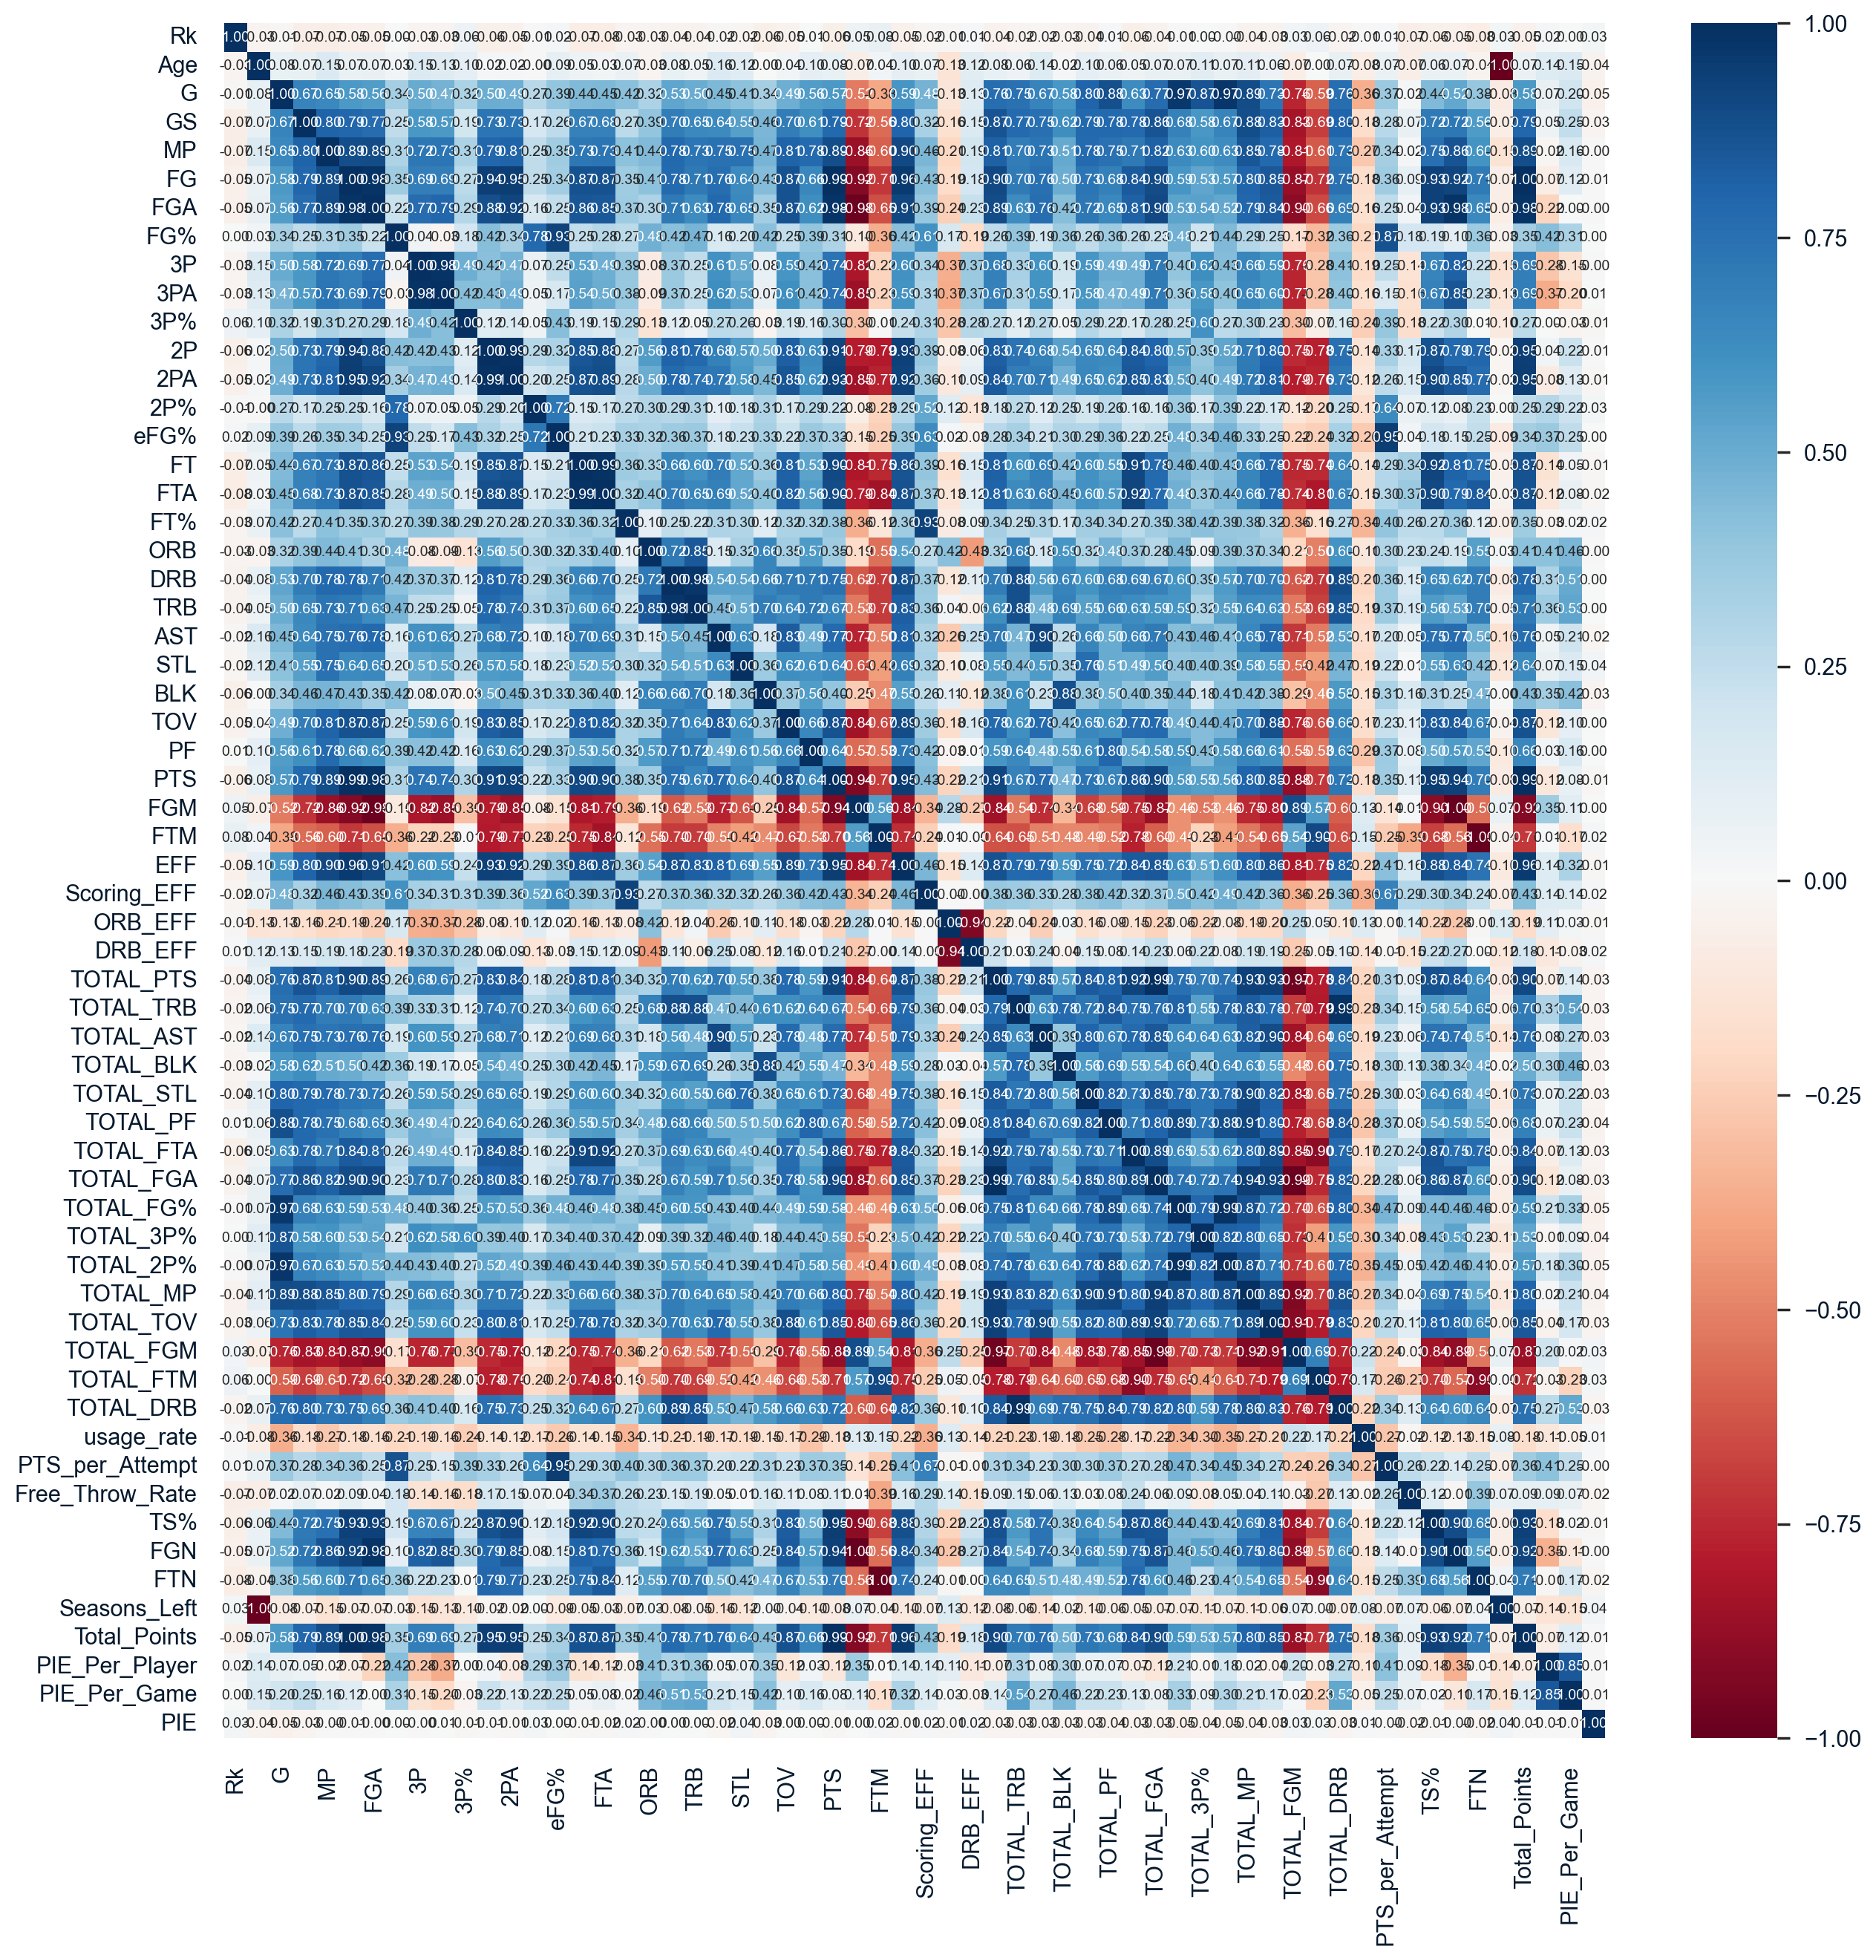

['MP',
 'FG',
 'FGA',
 '3PA',
 '2P',
 '2PA',
 'eFG%',
 'FT',
 'FTA',
 'DRB',
 'TRB',
 'TOV',
 'PTS',
 'FGM',
 'FTM',
 'EFF',
 'Scoring_EFF',
 'DRB_EFF',
 'TOTAL_PTS',
 'TOTAL_TRB',
 'TOTAL_AST',
 'TOTAL_BLK',
 'TOTAL_STL',
 'TOTAL_PF',
 'TOTAL_FTA',
 'TOTAL_FGA',
 'TOTAL_FG%',
 'TOTAL_3P%',
 'TOTAL_2P%',
 'TOTAL_MP',
 'TOTAL_TOV',
 'TOTAL_FGM',
 'TOTAL_FTM',
 'TOTAL_DRB',
 'PTS_per_Attempt',
 'TS%',
 'FGN',
 'FTN',
 'Seasons_Left',
 'Total_Points',
 'PIE_Per_Game']

In [37]:
high_correlated_cols(df, plot=True) #korelasyona göre de drop işlemi ekstra uygulanabilir

In [38]:
drop = ['Rk','Player','Pos','Tm','Age','G','GS','ORB_EFF','DRB_EFF','PIE','PTS_per_Attempt','Free_Throw_Rate']
train = df.drop(columns=drop)
train.head()

MP    FG    FGA   FG%    3P   3PA   3P%    2P    2PA   2P%  eFG%    FT   FTA   FT%   ORB   DRB    TRB   AST   STL   BLK   TOV    PF    PTS    FGM    FTM    EFF  Scoring_EFF  TOTAL_PTS  TOTAL_TRB  TOTAL_AST  TOTAL_BLK  TOTAL_STL  TOTAL_PF  TOTAL_FTA  TOTAL_FGA  TOTAL_FG%  TOTAL_3P%  TOTAL_2P%  TOTAL_MP  TOTAL_TOV  TOTAL_FGM  TOTAL_FTM  TOTAL_DRB  usage_rate     TS%   FGN   FTN  Seasons_Left  Total_Points  PIE_Per_Player  PIE_Per_Game
0 21.900 3.200  6.300 0.501 0.400 1.300 0.268 2.800  5.000 0.562 0.529 0.900 1.500 0.616 2.600 4.000  6.600 1.300 0.600 0.900 1.100 1.900  7.600 -3.100 -0.600 14.400        0.558    562.400    488.400     96.200     66.600     44.400   140.600    111.000    466.200     37.074     19.832     41.588  1620.600     81.400   -229.400    -44.400    296.000       0.005  26.448 3.100 0.600         9.000         3.200           0.750       107.300
1 17.500 3.100  6.800 0.459 0.500 1.900 0.277 2.600  4.900 0.528 0.497 1.000 1.700 0.571 2.000 3.400  5.400 1.800 0.600 0.500 1.200 1.600  7.700 -3.700 -0.700 12.800        0.515    192.500    135.000     45.000     12.500     15.000    40.000     42.500    170.000     11.475      6.925     13.200   437.500     30.000    -92.500    -17.500     85.000       0.020  29.060 3.700 0.700         9.000         3.100          -0.950        -6.250
2 24.200 3.200  6.100 0.525 0.300 1.000 0.260 2.900  5.100 0.578 0.547 0.900 1.400 0.643 2.900 4.300  7.200 1.100 0.600 1.100 1.100 2.100  7.600 -2.900 -0.500 15.300        0.584    372.400    352.800     53.900     53.900     29.400   102.900     68.600    298.900     25.725     12.740     28.322  1185.800     53.900   -142.100    -24.500    210.700       0.007  25.521 2.900 0.500         9.000         3.200           1.500       107.800
3 34.000 7.500 14.300 0.521 0.200 0.600 0.357 7.300 13.700 0.528 0.529 4.100 5.500 0.755 2.200 8.100 10.400 3.900 1.100 0.900 2.300 2.200 19.300 -6.800 -1.400 29.700        0.638   1370.300    738.400    276.900     63.900     78.100   156.200    390.500   1015.300     36.991     25.347     37.488  2414.000    163.300   -482.800    -99.400    575.100       0.008 161.348 6.800 1.400         7.500         7.500           1.450       312.400
4 21.000 2.300  5.600 0.411 0.800 2.700 0.294 1.500  2.800 0.523 0.483 0.500 0.700 0.661 0.900 1.800  2.800 1.100 0.600 0.600 0.800 1.500  5.800 -3.300 -0.200  8.200        0.536    452.400    218.400     85.800     46.800     46.800   117.000     54.600    436.800     32.058     22.932     40.794  1638.000     62.400   -257.400    -15.600    140.400       0.004  17.133 3.300 0.200         9.750         2.300          -2.050      -124.800

In [39]:
train.isnull().sum()

MP                0
FG                0
FGA               0
FG%               0
3P                0
3PA               0
3P%               0
2P                0
2PA               0
2P%               0
eFG%              0
FT                0
FTA               0
FT%               0
ORB               0
DRB               0
TRB               0
AST               0
STL               0
BLK               0
TOV               0
PF                0
PTS               0
FGM               0
FTM               0
EFF               0
Scoring_EFF       0
TOTAL_PTS         0
TOTAL_TRB         0
TOTAL_AST         0
TOTAL_BLK         0
TOTAL_STL         0
TOTAL_PF          0
TOTAL_FTA         0
TOTAL_FGA         0
TOTAL_FG%         0
TOTAL_3P%         0
TOTAL_2P%         0
TOTAL_MP          0
TOTAL_TOV         0
TOTAL_FGM         0
TOTAL_FTM         0
TOTAL_DRB         0
usage_rate        0
TS%               0
FGN               0
FTN               0
Seasons_Left      0
Total_Points      0
PIE_Per_Player    0


In [40]:
scaler = MinMaxScaler()
scaled=pd.DataFrame(scaler.fit_transform(train))
scaled.columns=train.columns

In [41]:
n_components=train.shape[1]
pca = PCA(n_components=n_components, random_state=100)
pca.fit(scaled)

PCA(n_components=51, random_state=100)

In [42]:
explained_variance_ratio = pca.explained_variance_ratio_ 
cum_explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
lst = []
for i in range (0, n_components):
    lst.append([i+1, round(explained_variance_ratio[i],6), cum_explained_variance_ratio[i]])

pca_predictor = pd.DataFrame(lst)
pca_predictor.columns = ['Component', 'Explained Variance', 'Cumulative Explained Variance']
pca_predictor

Component  Explained Variance  Cumulative Explained Variance
0           1               0.621                          0.621
1           2               0.089                          0.710
2           3               0.064                          0.774
3           4               0.052                          0.827
4           5               0.032                          0.859
5           6               0.025                          0.884
6           7               0.022                          0.906
7           8               0.017                          0.923
8           9               0.014                          0.937
9          10               0.011                          0.948
10         11               0.009                          0.957
11         12               0.007                          0.964
12         13               0.005                          0.969
13         14               0.005                          0.974
14         15               0.004                          0.978
15         16               0.004                          0.981
16         17               0.003                          0.985
17         18               0.003                          0.987
18         19               0.002                          0.990
19         20               0.002                          0.991
20         21               0.002                          0.993
21         22               0.001                          0.994
22         23               0.001                          0.996
23         24               0.001                          0.997
24         25               0.001                          0.997
25         26               0.001                          0.998
26         27               0.000                          0.998
27         28               0.000                          0.999
28         29               0.000                          0.999
29         30               0.000                          0.999
30         31               0.000                          0.999
31         32               0.000                          0.999
32         33               0.000                          1.000
33         34               0.000                          1.000
34         35               0.000                          1.000
35         36               0.000                          1.000
36         37               0.000                          1.000
37         38               0.000                          1.000
38         39               0.000                          1.000
39         40               0.000                          1.000
40         41               0.000                          1.000
41         42               0.000                          1.000
42         43               0.000                          1.000
43         44               0.000                          1.000
44         45               0.000                          1.000
45         46               0.000                          1.000
46         47               0.000                          1.000
47         48               0.000                          1.000
48         49               0.000                          1.000
49         50               0.000                          1.000
50         51               0.000                          1.000

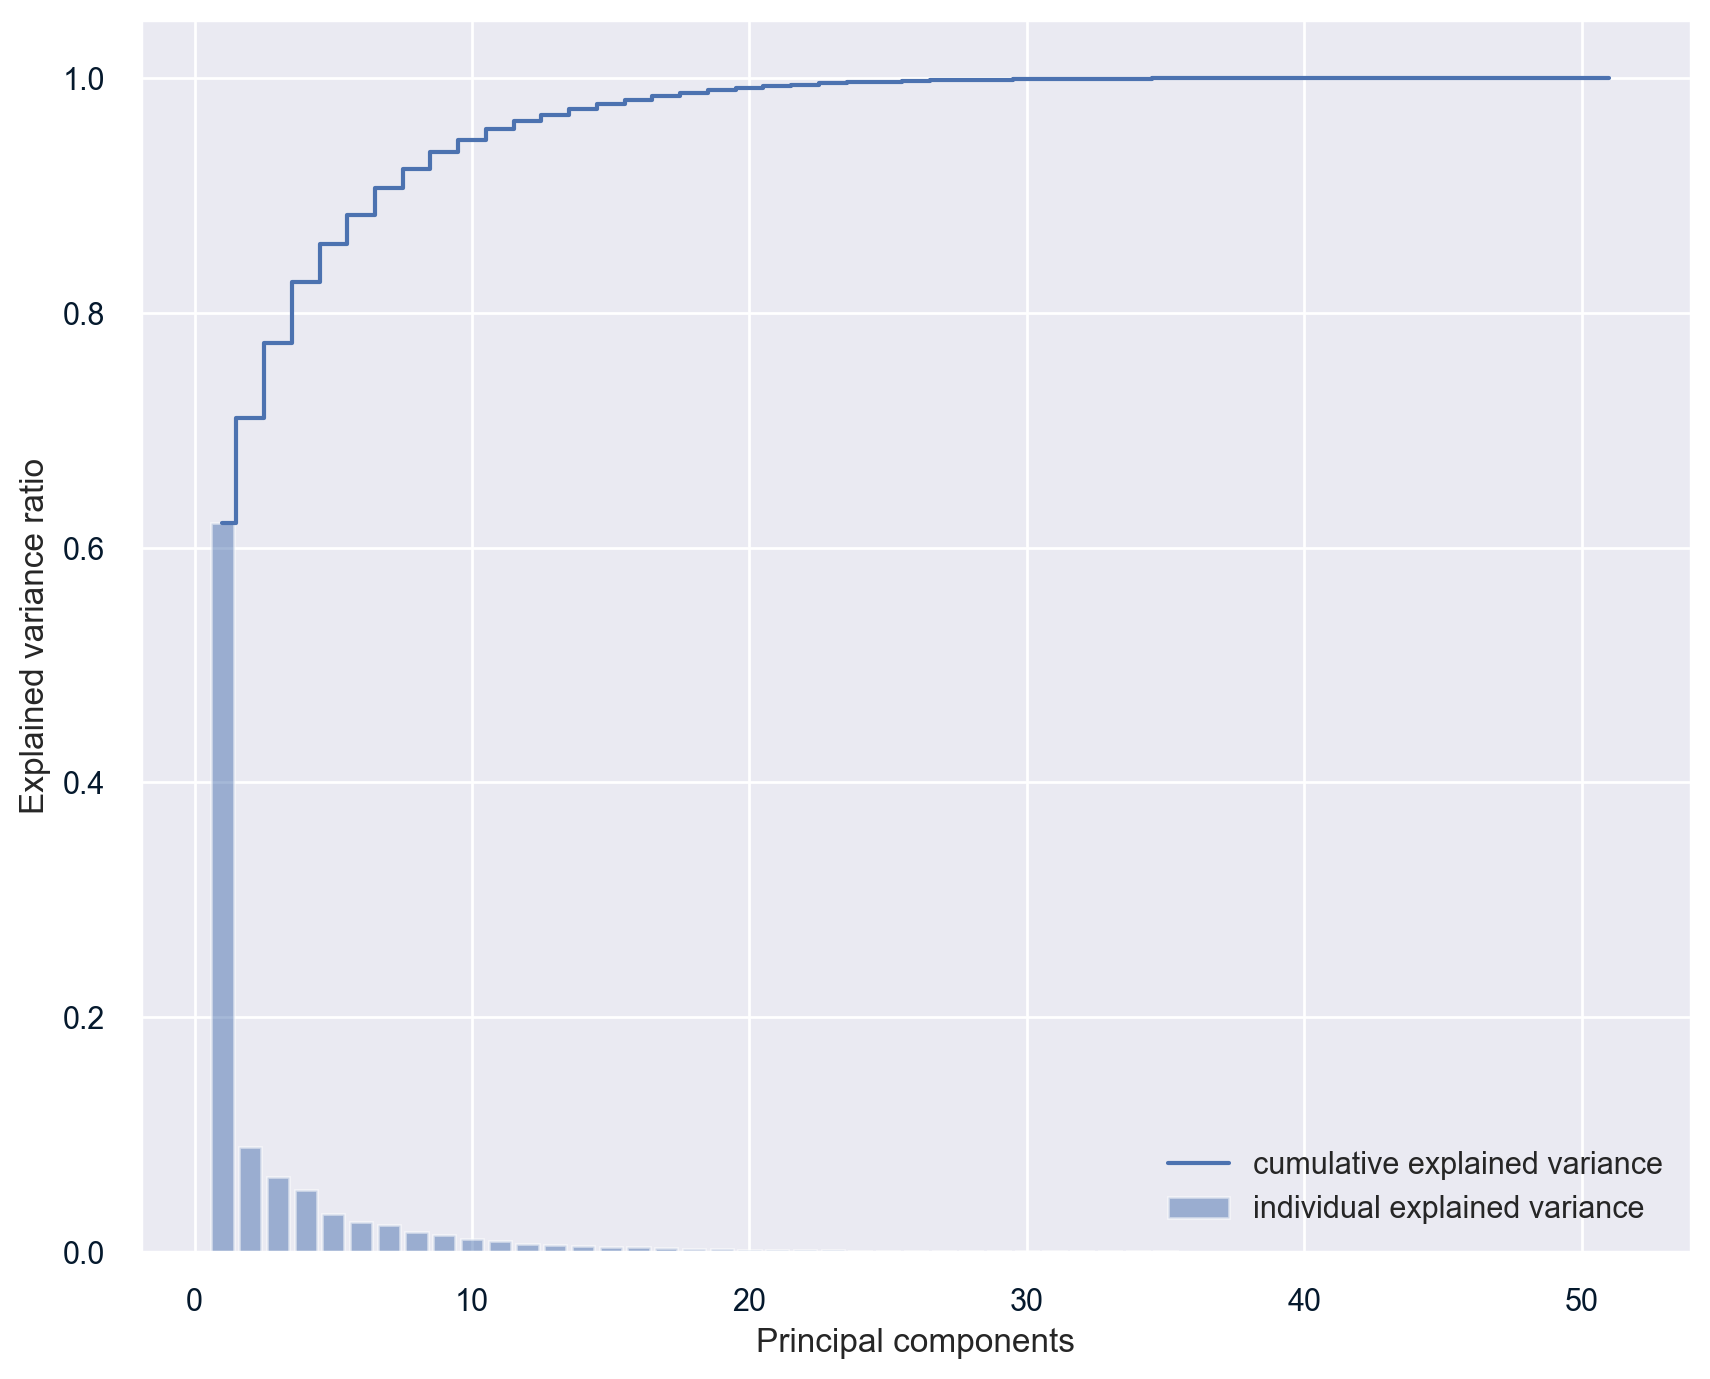

In [43]:
plt.subplots(figsize=(10,8))

plt.bar(pca_predictor['Component'],pca_predictor['Explained Variance'], align='center', alpha=0.5, 
       label='individual explained variance')
plt.step(pca_predictor['Component'],pca_predictor['Cumulative Explained Variance'], where='mid',
         label='cumulative explained variance')
plt.xlabel('Principal components')
plt.ylabel('Explained variance ratio');
plt.legend(loc='best')

In [44]:
pca = PCA(n_components=15)
pca.fit(scaled)

PCA(n_components=15)

In [45]:
transformed = pca.fit_transform(scaled)
transformed.shape

(735, 15)

In [46]:
n_clusters = 6
kmeans = KMeans(n_clusters=n_clusters, random_state=100)
kmeans.fit(transformed)

KMeans(n_clusters=6, random_state=100)

In [47]:
kmeans.get_params()

{'algorithm': 'lloyd',
 'copy_x': True,
 'init': 'k-means++',
 'max_iter': 300,
 'n_clusters': 6,
 'n_init': 'auto',
 'random_state': 100,
 'tol': 0.0001,
 'verbose': 0}

In [48]:
kmeans.n_clusters

6

In [49]:
kmeans.cluster_centers_

array([[-8.00310881e-01, -3.76187998e-02, -6.56018322e-02,
         1.63576805e-01, -7.49700945e-02,  5.97514348e-02,
        -5.55342279e-02,  1.06073615e-02,  4.13175888e-03,
        -3.87880721e-03,  5.55611403e-03,  2.87189458e-02,
        -4.95476363e-03, -1.95055973e-02,  7.02471844e-03],
       [ 9.53692235e-01,  3.08727016e-01, -4.34629984e-02,
        -1.49081392e-01,  4.24187243e-02, -8.62525870e-02,
        -2.04322173e-02, -9.93007136e-03,  1.69669724e-02,
        -3.03530035e-02, -1.02820307e-02, -3.69902868e-04,
        -1.06538808e-02, -1.24229946e-02, -5.62216527e-03],
       [ 1.97195197e+00, -4.16350028e-01,  1.08348325e-01,
        -3.17180361e-02, -8.82939656e-02,  1.55825937e-01,
         8.95459184e-03,  9.51415115e-03, -2.70457903e-02,
         1.03880782e-02,  2.84777928e-03,  2.66781176e-02,
        -3.19664282e-02, -1.28330686e-02, -2.24157894e-03],
       [-1.25472501e+00, -3.22376695e-01,  3.98738199e-01,
        -4.72899544e-01,  1.09508938e-01,  3.79125178

In [50]:
kmeans.labels_

array([1, 4, 5, 2, 5, 5, 4, 1, 1, 1, 1, 0, 5, 1, 2, 3, 1, 1, 4, 4, 3, 1,
       1, 0, 0, 4, 4, 4, 0, 0, 2, 5, 2, 2, 4, 0, 4, 0, 1, 2, 2, 4, 2, 0,
       3, 5, 0, 0, 5, 3, 5, 0, 3, 0, 2, 1, 5, 0, 5, 0, 4, 5, 5, 5, 1, 5,
       0, 5, 5, 0, 5, 0, 0, 2, 1, 4, 4, 5, 0, 3, 0, 2, 0, 5, 0, 3, 3, 3,
       5, 5, 2, 2, 5, 3, 4, 0, 1, 1, 4, 4, 3, 0, 2, 0, 0, 0, 5, 0, 0, 2,
       5, 0, 0, 5, 4, 0, 5, 2, 0, 1, 1, 1, 5, 1, 0, 1, 0, 3, 5, 0, 5, 0,
       4, 2, 1, 0, 5, 1, 1, 1, 5, 1, 0, 5, 0, 5, 5, 5, 3, 2, 0, 0, 0, 2,
       5, 2, 0, 0, 0, 2, 0, 0, 0, 3, 3, 5, 0, 1, 4, 5, 1, 2, 1, 1, 0, 0,
       1, 5, 0, 5, 2, 1, 4, 2, 0, 5, 2, 5, 0, 3, 0, 5, 5, 1, 3, 5, 0, 0,
       0, 1, 5, 4, 0, 0, 5, 0, 4, 2, 0, 0, 0, 3, 4, 3, 3, 1, 1, 4, 5, 0,
       0, 0, 2, 3, 0, 3, 1, 2, 0, 0, 3, 1, 0, 0, 3, 2, 0, 0, 0, 0, 3, 1,
       5, 0, 4, 1, 1, 0, 2, 3, 5, 3, 1, 2, 4, 5, 5, 0, 5, 5, 0, 0, 0, 1,
       0, 2, 0, 1, 2, 5, 3, 5, 0, 3, 1, 3, 1, 1, 5, 5, 5, 4, 4, 4, 0, 2,
       5, 2, 1, 4, 4, 5, 0, 0, 5, 1, 5, 5, 0, 4, 1,

In [51]:
kmeans.inertia_

380.18434332450715

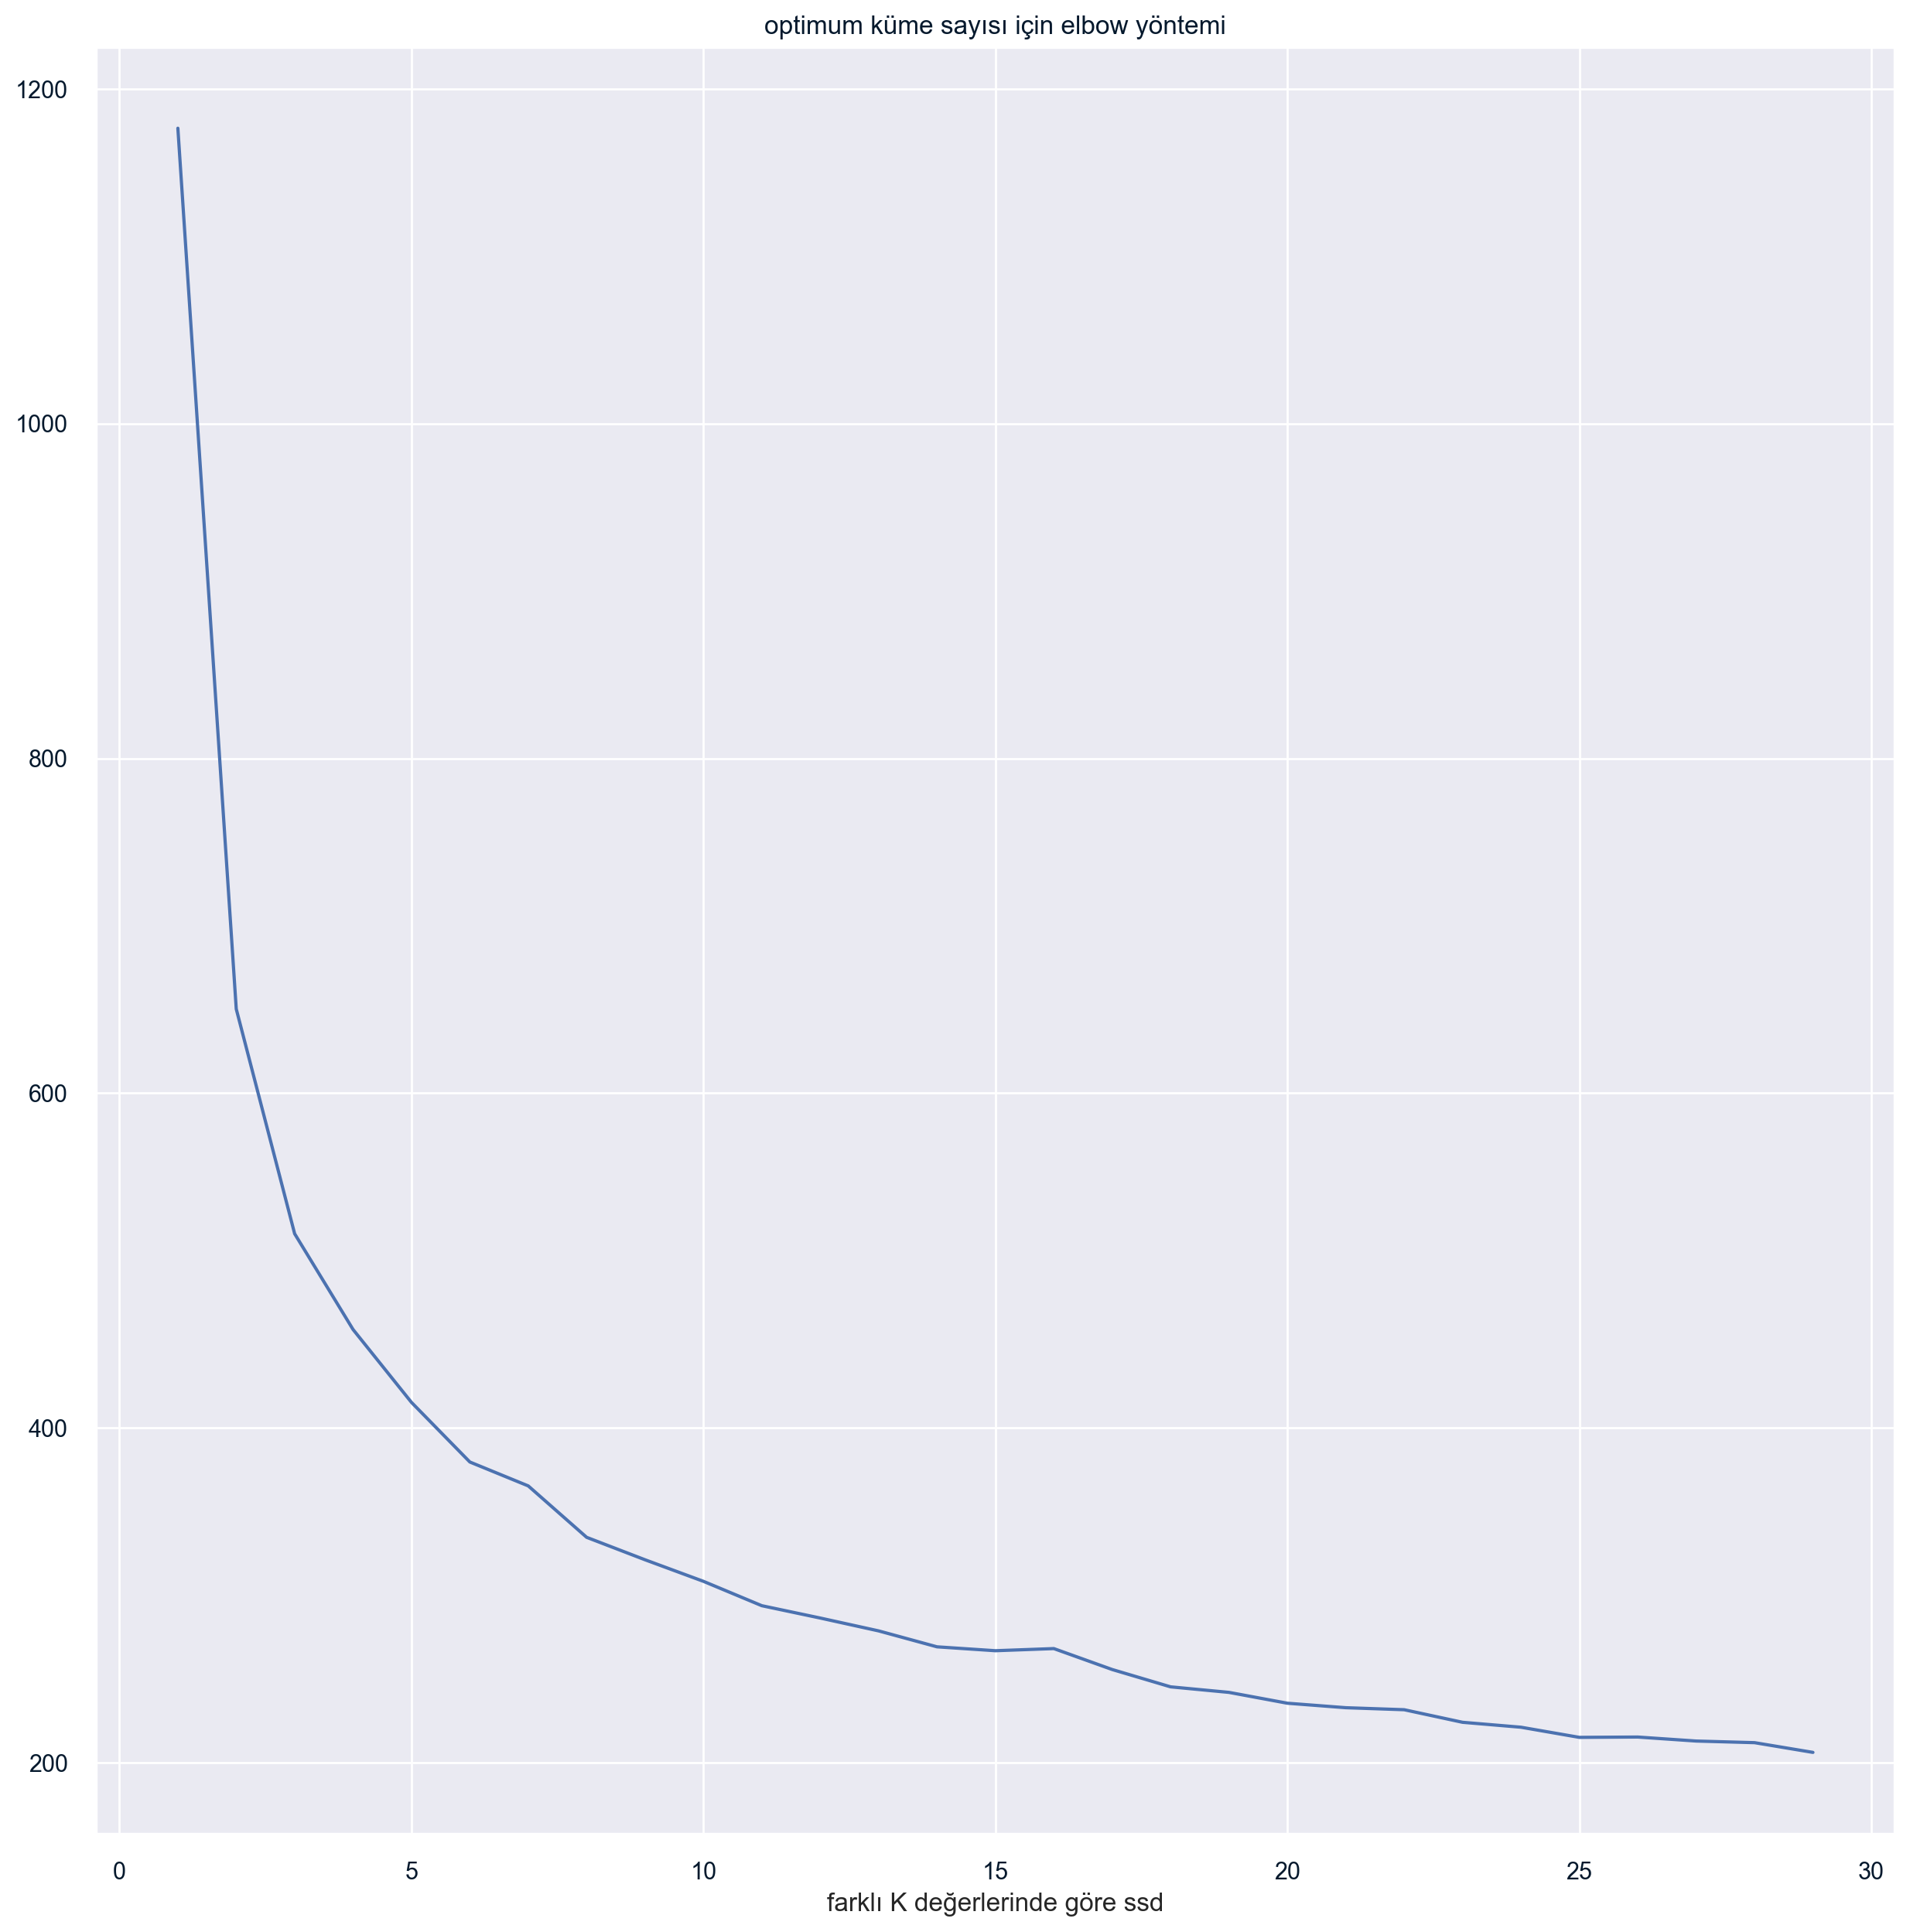

In [52]:
kmeans2=KMeans()
ssd=[]
K=range(1,30)
for k in K:
    kmeans2=KMeans(n_clusters=k).fit(transformed)
    ssd.append(kmeans2.inertia_)

plt.plot(K,ssd, "bx-")
plt.xlabel("farklı K değerlerinde göre ssd")
plt.title("optimum küme sayısı için elbow yöntemi")
plt.show()

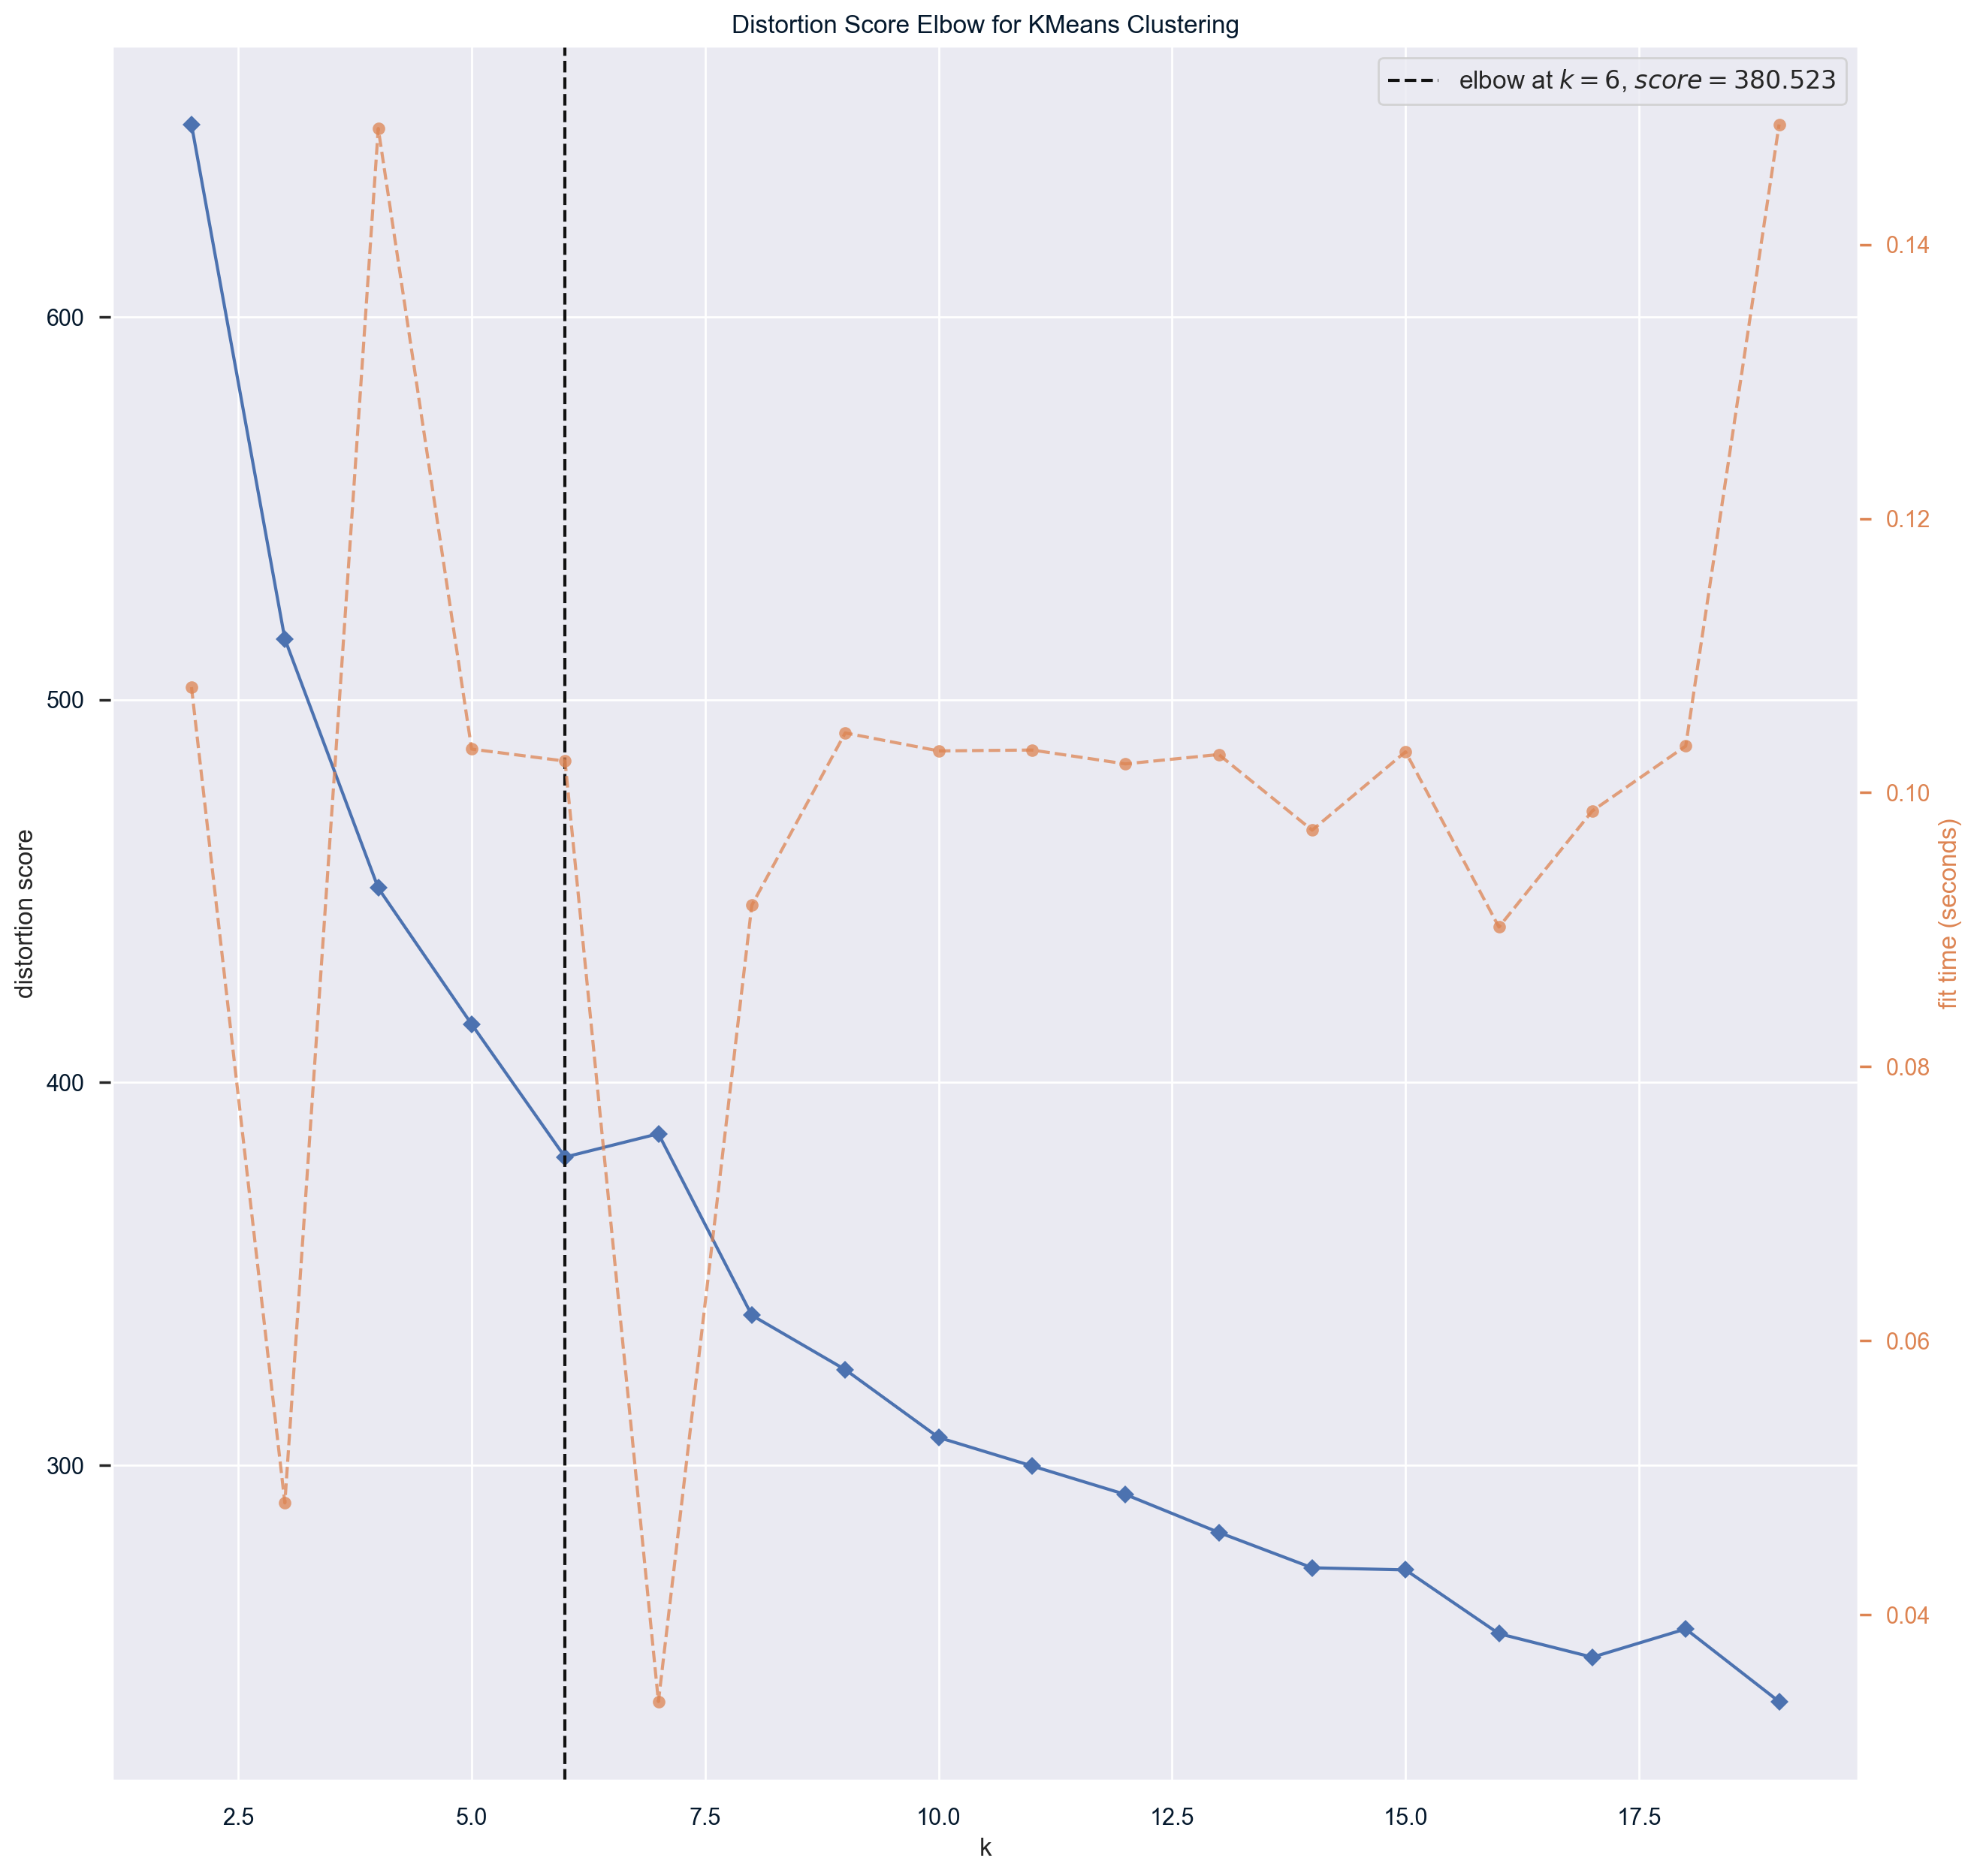

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [53]:
kmeans3 = KMeans()
elbow = KElbowVisualizer(kmeans3, k=(2, 20))
elbow.fit(transformed)
elbow.show()#optimum value 6 olarak belirlendi, feature lar eklenince 7 olarak belirlendi

In [54]:
kmeans_final=KMeans(n_clusters=elbow.elbow_value_).fit(transformed)

In [55]:
kmeans_final.n_clusters

6

In [56]:
kmeans_final.cluster_centers_

array([[ 2.42432402e-02,  1.48676171e-01, -9.13892261e-02,
         5.98258948e-02,  6.12270710e-02, -7.68435584e-02,
         9.35263215e-03,  1.72567084e-03, -1.33732931e-02,
         1.60634916e-02,  1.03160407e-02, -3.41636564e-02,
         2.40026273e-02,  2.23246617e-02,  2.91542774e-03],
       [-7.65962589e-01, -8.45381244e-03, -7.09225388e-02,
         1.49857631e-01, -7.02534573e-02,  6.17653036e-02,
        -4.42407435e-02,  5.64360232e-03,  1.57052960e-03,
        -2.42106856e-03,  4.18254841e-03,  2.01496318e-02,
        -1.33873880e-04, -1.47677673e-02,  5.53647149e-03],
       [ 2.30438312e+00, -3.62480891e-01,  2.41851529e-01,
        -7.73262844e-02, -1.17083287e-01,  2.58506164e-01,
        -2.54288032e-02,  4.53230031e-02, -4.75817903e-03,
         1.67072201e-02,  3.83135780e-02,  7.06100420e-02,
        -3.40477520e-02, -3.50697340e-02,  9.96809406e-03],
       [ 8.85158582e-01,  4.40234774e-01,  2.33303290e-02,
        -1.49412475e-01,  3.00543375e-02, -8.80372719

In [57]:
kmeans_final.labels_

array([3, 0, 0, 2, 0, 0, 0, 3, 3, 3, 3, 1, 0, 3, 2, 5, 3, 4, 4, 0, 5, 3,
       3, 1, 1, 0, 0, 0, 1, 1, 4, 0, 2, 4, 0, 1, 4, 1, 3, 2, 4, 4, 4, 1,
       5, 1, 1, 1, 0, 5, 0, 1, 5, 1, 4, 3, 1, 1, 0, 1, 0, 0, 0, 0, 4, 0,
       1, 0, 0, 1, 0, 1, 1, 4, 4, 4, 0, 1, 1, 5, 1, 2, 1, 0, 1, 5, 5, 5,
       0, 3, 2, 2, 1, 5, 4, 1, 4, 3, 0, 0, 5, 1, 2, 1, 1, 1, 1, 1, 1, 2,
       1, 1, 1, 0, 0, 1, 0, 4, 1, 3, 3, 3, 0, 3, 1, 3, 1, 5, 0, 1, 0, 1,
       0, 4, 3, 1, 0, 3, 3, 3, 0, 3, 1, 0, 1, 0, 0, 0, 5, 2, 1, 1, 1, 2,
       0, 2, 1, 1, 1, 2, 1, 1, 1, 5, 5, 0, 1, 3, 4, 0, 4, 2, 3, 3, 1, 1,
       3, 0, 1, 0, 2, 3, 0, 2, 1, 0, 2, 0, 1, 5, 1, 0, 0, 3, 5, 0, 1, 1,
       1, 3, 0, 0, 1, 1, 0, 1, 0, 2, 1, 1, 1, 5, 0, 5, 5, 3, 3, 0, 0, 1,
       1, 1, 4, 5, 1, 5, 4, 2, 1, 1, 5, 3, 1, 1, 5, 2, 1, 1, 1, 1, 5, 3,
       0, 1, 0, 3, 0, 1, 4, 5, 1, 5, 3, 2, 0, 0, 0, 1, 0, 0, 1, 5, 1, 3,
       1, 2, 1, 4, 4, 0, 5, 0, 1, 5, 4, 5, 3, 3, 0, 0, 0, 0, 0, 4, 1, 4,
       0, 4, 3, 0, 0, 0, 1, 1, 0, 3, 0, 0, 1, 0, 3,

In [58]:
labels = kmeans_final.labels_
df['kmeans_clstr'] = labels
df['kmeans_clstr'] = df['kmeans_clstr']+1

In [59]:
df.head()

Rk            Player   Pos  Age   Tm   G  GS     MP    FG    FGA   FG%    3P   3PA   3P%    2P    2PA   2P%  eFG%    FT   FTA   FT%   ORB   DRB    TRB   AST   STL   BLK   TOV    PF    PTS    FGM    FTM    EFF  Scoring_EFF  ORB_EFF  DRB_EFF  TOTAL_PTS  TOTAL_TRB  TOTAL_AST  TOTAL_BLK  TOTAL_STL  TOTAL_PF  TOTAL_FTA  TOTAL_FGA  TOTAL_FG%  TOTAL_3P%  TOTAL_2P%  TOTAL_MP  TOTAL_TOV  TOTAL_FGM  TOTAL_FTM  TOTAL_DRB  usage_rate  PTS_per_Attempt  Free_Throw_Rate     TS%   FGN   FTN  Seasons_Left  \
0   1  Precious Achiuwa  PF-C   24  TOT  74  18 21.900 3.200  6.300 0.501 0.400 1.300 0.268 2.800  5.000 0.562 0.529 0.900 1.500 0.616 2.600 4.000  6.600 1.300 0.600 0.900 1.100 1.900  7.600 -3.100 -0.600 14.400        0.558    0.394    0.606    562.400    488.400     96.200     66.600     44.400   140.600    111.000    466.200     37.074     19.832     41.588  1620.600     81.400   -229.400    -44.400    296.000       0.005            1.092            0.238  26.448 3.100 0.600         9.000   
1   1  Precious Achiuwa     C   24  TOR  25   0 17.500 3.100  6.800 0.459 0.500 1.900 0.277 2.600  4.900 0.528 0.497 1.000 1.700 0.571 2.000 3.400  5.400 1.800 0.600 0.500 1.200 1.600  7.700 -3.700 -0.700 12.800        0.515    0.370    0.630    192.500    135.000     45.000     12.500     15.000    40.000     42.500    170.000     11.475      6.925     13.200   437.500     30.000    -92.500    -17.500     85.000       0.020            1.020            0.250  29.060 3.700 0.700         9.000   
2   1  Precious Achiuwa    PF   24  NYK  49  18 24.200 3.200  6.100 0.525 0.300 1.000 0.260 2.900  5.100 0.578 0.547 0.900 1.400 0.643 2.900 4.300  7.200 1.100 0.600 1.100 1.100 2.100  7.600 -2.900 -0.500 15.300        0.584    0.403    0.597    372.400    352.800     53.900     53.900     29.400   102.900     68.600    298.900     25.725     12.740     28.322  1185.800     53.900   -142.100    -24.500    210.700       0.007            1.132            0.230  25.521 2.900 0.500         9.000   
3   2       Bam Adebayo     C   26  MIA  71  71 34.000 7.500 14.300 0.521 0.200 0.600 0.357 7.300 13.700 0.528 0.529 4.100 5.500 0.755 2.200 8.100 10.400 3.900 1.100 0.900 2.300 2.200 19.300 -6.800 -1.400 29.700        0.638    0.212    0.779   1370.300    738.400    276.900     63.900     78.100   156.200    390.500   1015.300     36.991     25.347     37.488  2414.000    163.300   -482.800    -99.400    575.100       0.008            1.154            0.385 161.348 6.800 1.400         7.500   
4   3      Ochai Agbaji    SG   23  TOT  78  28 21.000 2.300  5.600 0.411 0.800 2.700 0.294 1.500  2.800 0.523 0.483 0.500 0.700 0.661 0.900 1.800  2.800 1.100 0.600 0.600 0.800 1.500  5.800 -3.300 -0.200  8.200        0.536    0.321    0.643    452.400    218.400     85.800     46.800     46.800   117.000     54.600    436.800     32.058     22.932     40.794  1638.000     62.400   -257.400    -15.600    140.400       0.004            0.982            0.125  17.133 3.300 0.200         9.750   

   Total_Points  PIE_Per_Player  PIE_Per_Game   PIE  kmeans_clstr  
0         3.200           0.750       107.300 0.007             4  
1         3.100          -0.950        -6.250 0.152             1  
2         3.200           1.500       107.800 0.014             1  
3         7.500           1.450       312.400 0.005             3  
4         2.300          -2.050      -124.800 0.016             1

In [60]:
df['kmeans_clstr'].nunique()

6

In [61]:
df['kmeans_clstr'].head()

0    4
1    1
2    1
3    3
4    1
Name: kmeans_clstr, dtype: int32

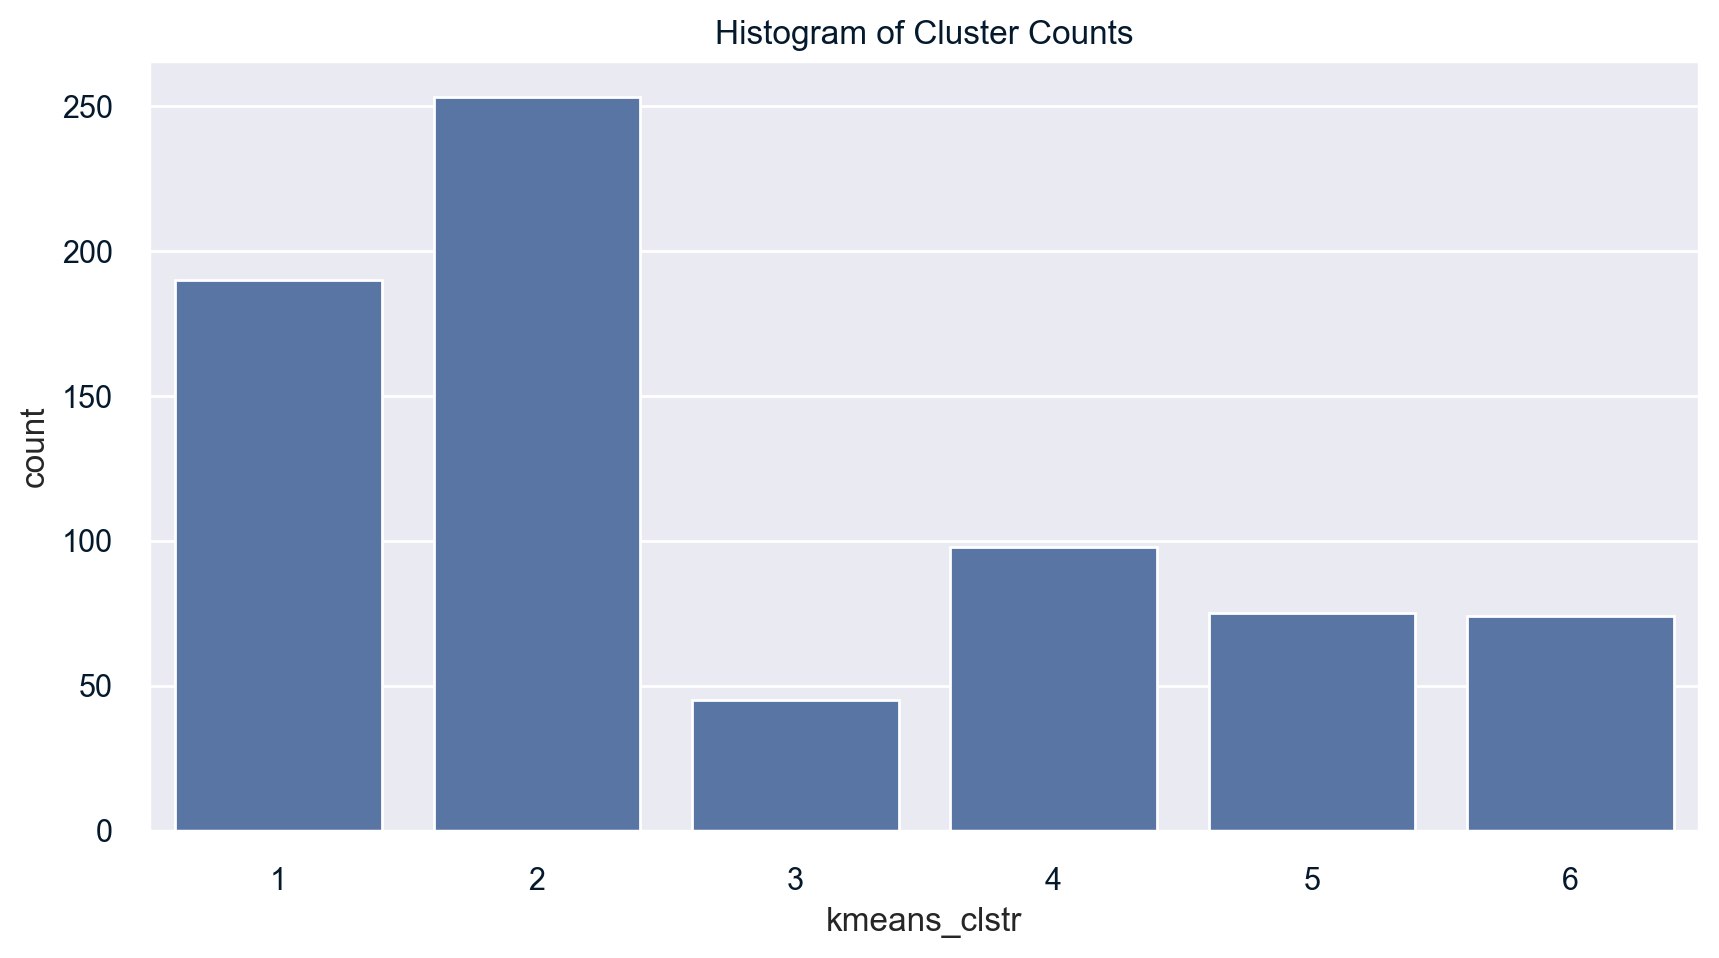

In [62]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.countplot(x='kmeans_clstr', data=df, ax=ax)
ax.set_title("Histogram of Cluster Counts", fontsize=12)
plt.show()

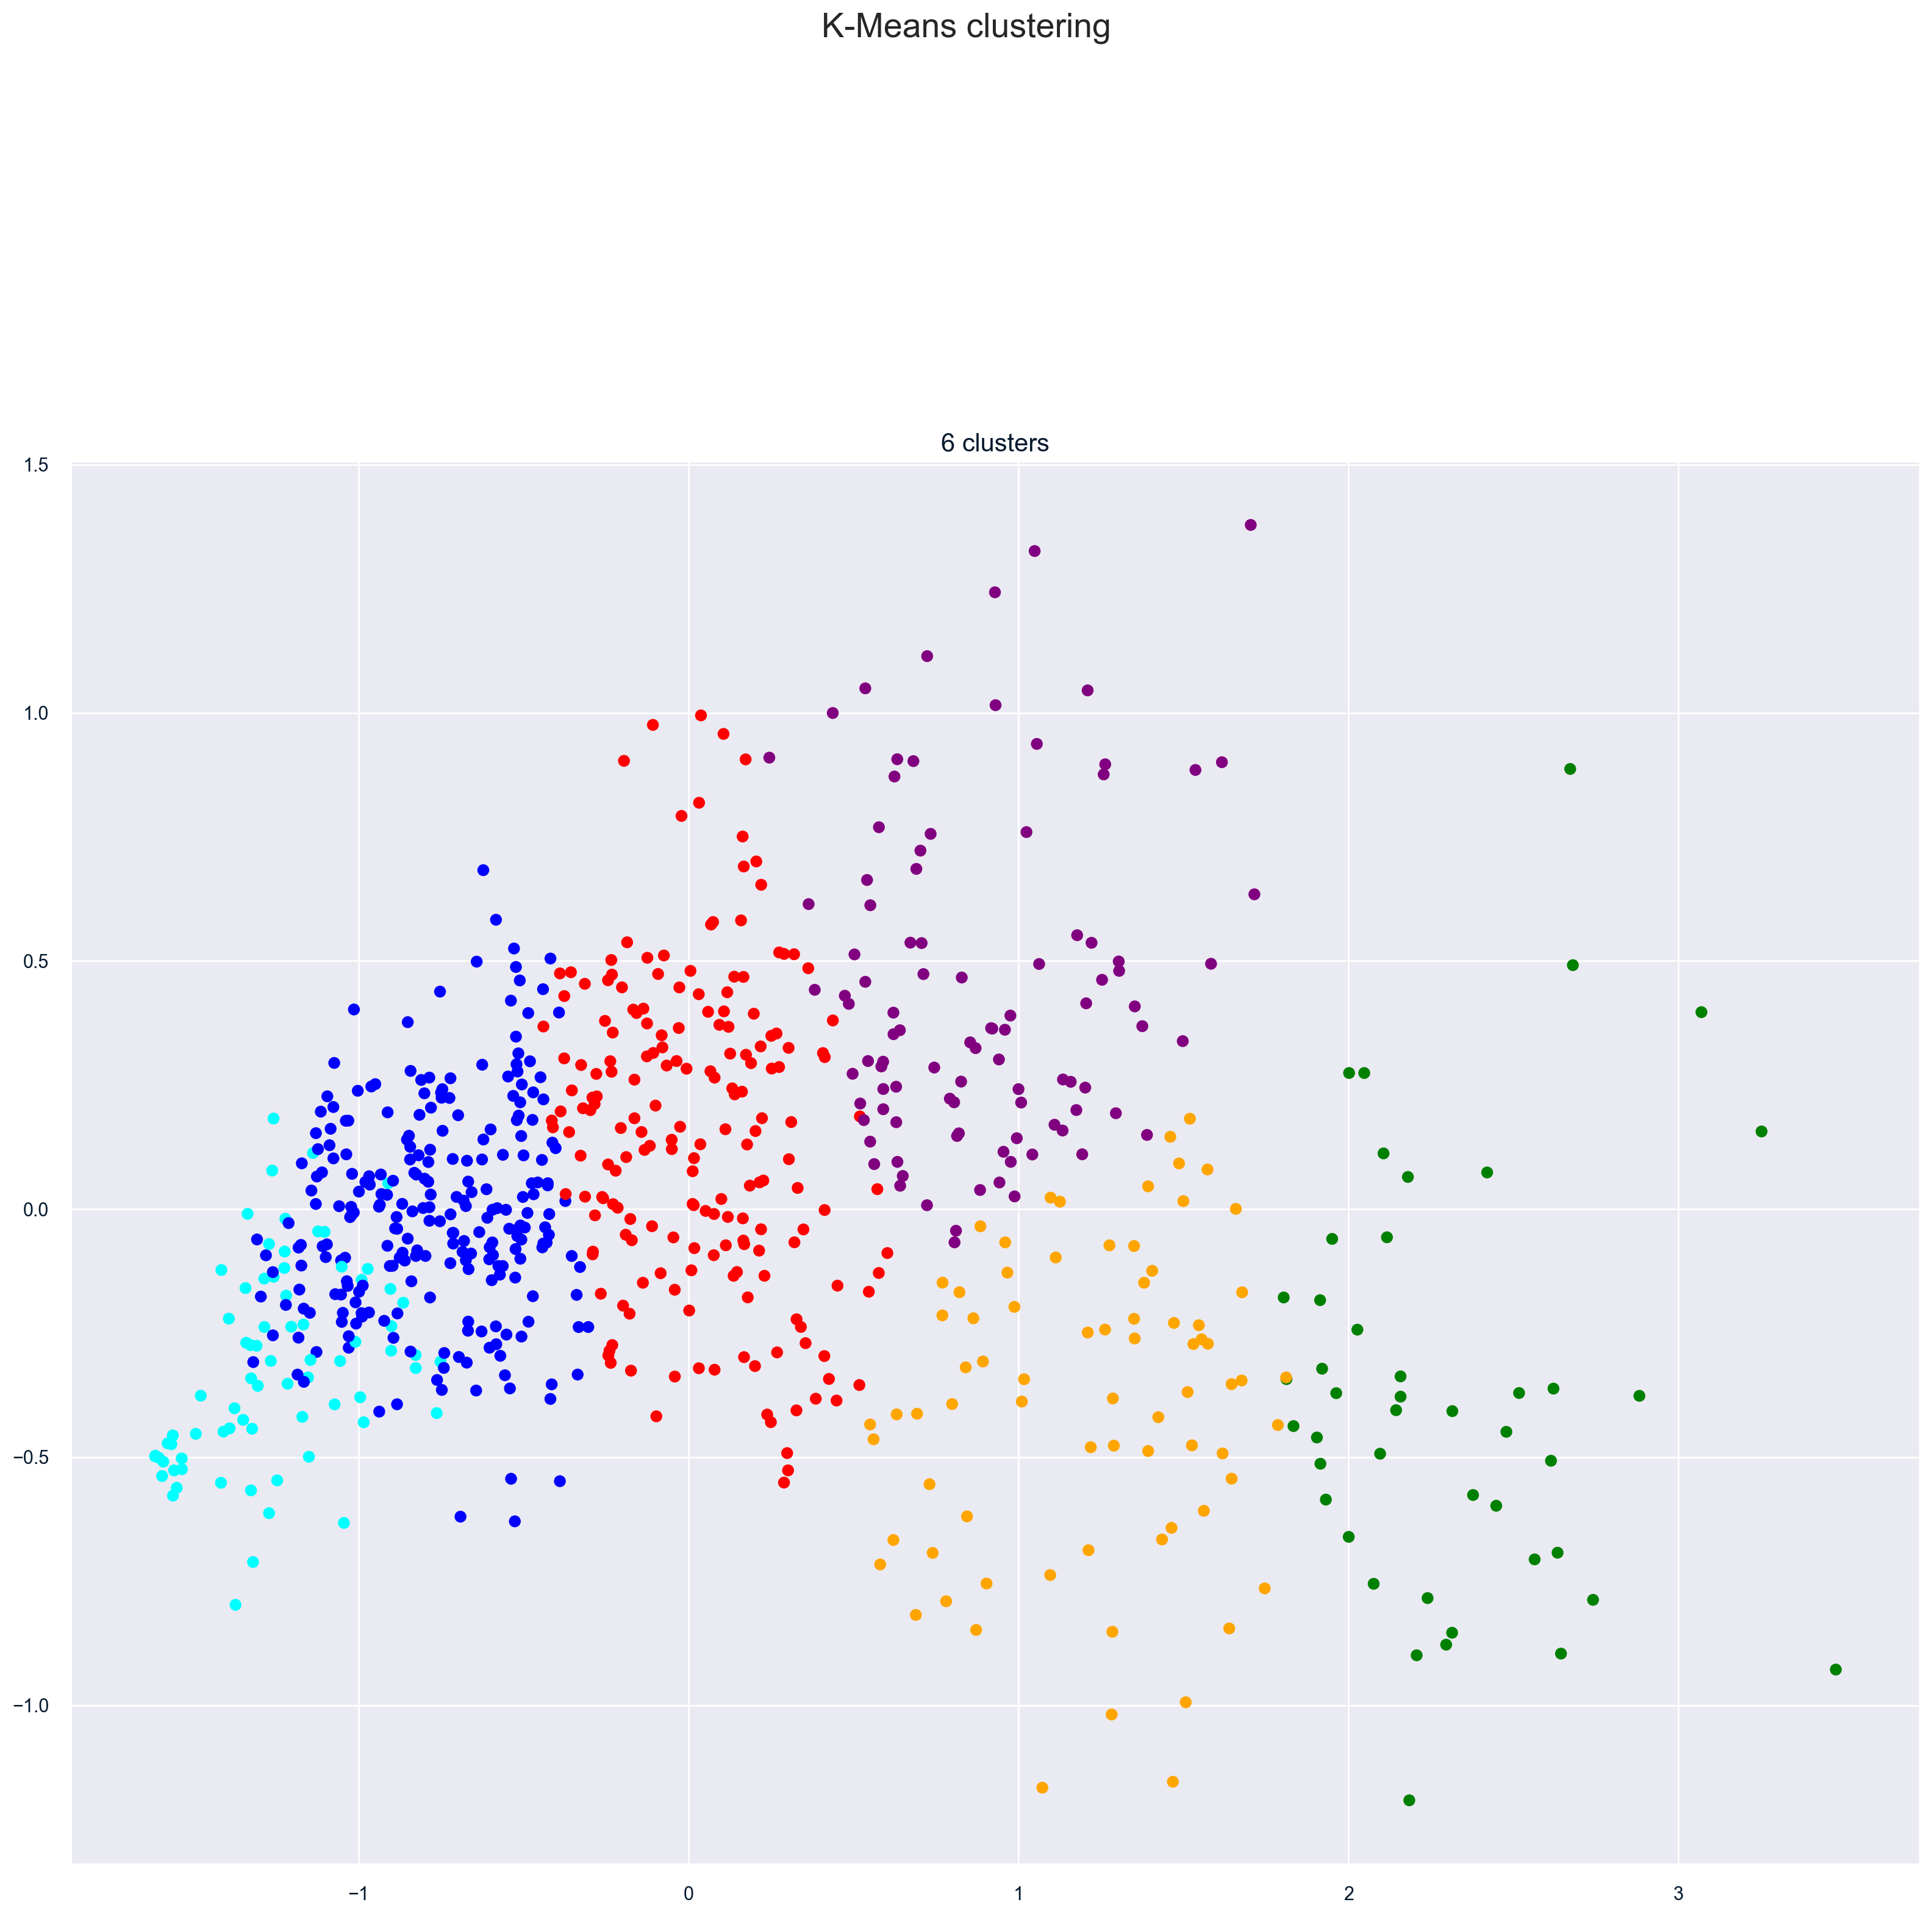

In [63]:
fig,axes = plt.subplots(figsize=(16,16))
kmeans_fig = KMeans(n_clusters = 6, random_state = 0).fit(transformed)
colors = ['red', 'blue', 'green', 'purple', 'orange', 'cyan', 'magenta']
axes.scatter(transformed[:, 0], transformed[:, 1], c = [colors[i] for i in kmeans_final.labels_])
axes.set_title(str(6) + ' clusters', size = 15)
fig.suptitle('K-Means clustering', fontsize = 20)
fig.tight_layout()
fig.subplots_adjust(top=0.75)
plt.show()

In [64]:
def cluster_df(columns, dataframe):
    output = pd.DataFrame({'kmeans_clstr':[ i+1 for i in range(n_clusters)]})
    for column in columns:
        lst = []
        for i in range(n_clusters):
            mean = dataframe[dataframe['kmeans_clstr'] == i+1].describe()[column]['mean']
            lst.append([i+1, round(mean,2)])
        dataframe_lst = pd.DataFrame(lst)
        dataframe_lst.columns = ['kmeans_clstr', column]
        output = pd.merge(output, dataframe_lst, on='kmeans_clstr', how='outer')
    return output

In [65]:
columns = train.columns
cluster_df(columns,df)

kmeans_clstr     MP    FG    FGA   FG%    3P   3PA   3P%    2P    2PA   2P%  eFG%    FT   FTA   FT%   ORB   DRB   TRB   AST   STL   BLK   TOV    PF    PTS    FGM    FTM    EFF  Scoring_EFF  TOTAL_PTS  TOTAL_TRB  TOTAL_AST  TOTAL_BLK  TOTAL_STL  TOTAL_PF  TOTAL_FTA  TOTAL_FGA  TOTAL_FG%  TOTAL_3P%  TOTAL_2P%  TOTAL_MP  TOTAL_TOV  TOTAL_FGM  TOTAL_FTM  TOTAL_DRB  usage_rate     TS%   FGN   FTN  Seasons_Left  Total_Points  PIE_Per_Player  PIE_Per_Game
0             1 19.810 2.780  6.000 0.470 0.950 2.630 0.330 1.830  3.380 0.540 0.550 0.930 1.230 0.750 0.960 2.550 3.500 1.820 0.680 0.440 0.910 1.690  7.430 -3.220 -0.300 11.260        0.610    342.300    157.760     84.740     19.660     31.050    79.090     55.610    277.390     22.800     16.630     26.380   928.830     41.280   -150.420    -13.450    115.710       0.010  27.030 3.220 0.300         6.980         2.780          -0.180        24.240
1             2 10.610 1.330  3.140 0.430 0.430 1.390 0.270 0.900  1.750 0.510 0.490 0.530 0.720 0.750 0.530 1.280 1.800 0.930 0.360 0.210 0.460 0.920  3.610 -1.810 -0.190  5.380        0.590     85.420     43.650     22.260      4.820      8.060    22.180     15.620     73.640     10.160      6.680     11.910   255.530     10.850    -42.060     -4.260     31.140       0.030   7.470 1.810 0.190         7.810         1.330          -0.670        -3.760
2             3 34.510 8.690 17.760 0.490 2.030 5.550 0.360 6.660 12.210 0.540 0.550 4.540 5.590 0.810 1.280 5.530 6.810 5.530 1.110 0.730 2.650 2.230 23.950 -9.070 -1.050 30.660        0.650   1671.810    477.220    386.080     50.480     78.000   154.940    387.460   1242.140     34.440     25.030     38.130  2424.410    183.600   -634.030    -73.750    388.320       0.010 246.890 9.070 1.050         6.780         8.690          -1.220        67.690
3             4 26.370 4.260  8.390 0.510 1.090 2.940 0.310 3.160  5.450 0.580 0.580 1.450 1.950 0.750 1.510 4.080 5.580 2.490 0.780 0.740 1.270 2.210 11.060 -4.130 -0.500 17.280        0.630    788.150    390.860    177.080     51.610     55.430   156.510    138.670    599.300     36.270     22.450     40.890  1874.400     89.620   -296.870    -35.560    286.630       0.010  53.310 4.130 0.500         7.440         4.250           1.080       159.870
4             5 31.180 6.170 13.640 0.450 2.210 5.940 0.370 3.970  7.700 0.520 0.530 2.690 3.270 0.820 0.820 3.490 4.300 4.070 0.890 0.410 1.870 2.080 17.230 -7.470 -0.580 20.720        0.640    947.280    236.310    222.160     23.240     49.350   116.300    174.770    750.480     25.270     20.830     28.950  1736.060    100.390   -411.710    -30.260    191.550       0.010 133.850 7.470 0.580         7.000         6.180          -2.610       -66.160
5             6  6.750 0.660  1.910 0.290 0.220 0.840 0.200 0.440  1.060 0.330 0.350 0.020 0.080 0.040 0.290 0.830 1.120 0.550 0.240 0.140 0.300 0.580  1.570 -1.250 -0.060  2.620        0.170      9.750      6.800      3.440      0.860      1.420     3.780      0.600     11.410      2.310      1.440      2.740    41.470      2.030     -7.300     -0.450      5.060       0.130   2.440 1.250 0.060         7.670         0.660          -0.760        -2.940

In [66]:
df[df['kmeans_clstr']==4].head(5)

Rk                    Player   Pos  Age   Tm   G  GS     MP    FG    FGA   FG%    3P   3PA   3P%    2P    2PA   2P%  eFG%    FT   FTA   FT%   ORB   DRB    TRB   AST   STL   BLK   TOV    PF    PTS    FGM    FTM    EFF  Scoring_EFF  ORB_EFF  DRB_EFF  TOTAL_PTS  TOTAL_TRB  TOTAL_AST  TOTAL_BLK  TOTAL_STL  TOTAL_PF  TOTAL_FTA  TOTAL_FGA  TOTAL_FG%  TOTAL_3P%  TOTAL_2P%  TOTAL_MP  TOTAL_TOV  TOTAL_FGM  TOTAL_FTM  TOTAL_DRB  usage_rate  PTS_per_Attempt  Free_Throw_Rate     TS%   FGN   FTN  \
0    1          Precious Achiuwa  PF-C   24  TOT  74  18 21.900 3.200  6.300 0.501 0.400 1.300 0.268 2.800  5.000 0.562 0.529 0.900 1.500 0.616 2.600 4.000  6.600 1.300 0.600 0.900 1.100 1.900  7.600 -3.100 -0.600 14.400        0.558    0.394    0.606    562.400    488.400     96.200     66.600     44.400   140.600    111.000    466.200     37.074     19.832     41.588  1620.600     81.400   -229.400    -44.400    296.000       0.005            1.092            0.238  26.448 3.100 0.600   
7    4              Santi Aldama    PF   23  MEM  61  35 26.500 4.000  9.300 0.435 1.700 5.000 0.349 2.300  4.300 0.534 0.528 0.900 1.400 0.621 1.200 4.600  5.800 2.300 0.700 0.900 1.100 1.500 10.700 -5.300 -0.500 15.700        0.528    0.207    0.793    652.700    353.800    140.300     54.900     42.700    91.500     85.400    567.300     26.535     21.289     32.574  1616.500     67.100   -323.300    -30.500    280.600       0.007            1.079            0.151  53.051 5.300 0.500   
8    5  Nickeil Alexander-Walker    SG   25  MIN  82  20 23.400 2.900  6.600 0.439 1.600 4.100 0.391 1.300  2.500 0.517 0.560 0.600 0.800 0.800 0.400 1.600  2.000 2.500 0.800 0.500 0.900 1.700  8.000 -3.700 -0.200 10.800        0.620    0.200    0.800    656.000    164.000    205.000     41.000     65.600   139.400     65.600    541.200     35.998     32.062     42.394  1918.800     73.800   -303.400    -16.400    131.200       0.004            1.151            0.121  27.808 3.700 0.200   
9    6             Grayson Allen    SG   28  PHO  75  74 33.500 4.500  9.100 0.499 2.700 5.900 0.461 1.800  3.200 0.570 0.649 1.700 2.000 0.878 0.600 3.300  3.900 3.000 0.900 0.600 1.300 2.100 13.500 -4.600 -0.300 18.300        0.689    0.154    0.846   1012.500    292.500    225.000     45.000     67.500   157.500    150.000    682.500     37.425     34.575     42.750  2512.500     97.500   -345.000    -22.500    247.500       0.004            1.353            0.220  67.365 4.600 0.300   
10   7             Jarrett Allen     C   25  CLE  77  77 31.700 6.700 10.600 0.634 0.000 0.100 0.000 6.700 10.600 0.638 0.634 3.000 4.100 0.742 3.200 7.400 10.500 2.700 0.700 1.100 1.600 1.900 16.500 -3.900 -1.100 28.100        0.688    0.305    0.705   1270.500    808.500    207.900     84.700     53.900   146.300    315.700    816.200     48.818      0.000     49.126  2440.900    123.200   -300.300    -84.700    569.800       0.006            1.330            0.387 102.333 3.900 1.100   

    Seasons_Left  Total_Points  PIE_Per_Player  PIE_Per_Game    PIE  kmeans_clstr  
0          9.000         3.200           0.750       107.300  0.007             4  
7          9.750         4.000           0.250       118.950  0.002             4  
8          8.250         2.900          -0.550         4.100 -0.134             4  
9          6.000         4.500           1.900       243.750  0.008             4  
10         8.250         6.700           6.250       642.950  0.010             4

In [67]:
df[df['kmeans_clstr']==6].head(5)

Rk                  Player Pos  Age   Tm   G  GS     MP    FG   FGA   FG%    3P   3PA   3P%    2P   2PA   2P%  eFG%    FT   FTA   FT%   ORB   DRB   TRB   AST   STL   BLK   TOV    PF   PTS    FGM    FTM   EFF  Scoring_EFF  ORB_EFF  DRB_EFF  TOTAL_PTS  TOTAL_TRB  TOTAL_AST  TOTAL_BLK  TOTAL_STL  TOTAL_PF  TOTAL_FTA  TOTAL_FGA  TOTAL_FG%  TOTAL_3P%  TOTAL_2P%  TOTAL_MP  TOTAL_TOV  TOTAL_FGM  TOTAL_FTM  TOTAL_DRB  usage_rate  PTS_per_Attempt  Free_Throw_Rate   TS%   FGN   FTN  Seasons_Left  \
15  12  Thanasis Antetokounmpo  PF   31  MIL  34   0  4.600 0.500 0.900 0.533 0.000 0.000 0.000 0.500 0.900 0.552 0.533 0.000 0.100 0.000 0.200 0.200 0.400 0.500 0.200 0.100 0.400 0.700 0.900 -0.400 -0.100 2.000        0.267    0.500    0.500     30.600     13.600     17.000      3.400      6.800    23.800      3.400     30.600     18.122      0.000     18.768   156.400     13.600    -13.600     -3.400      6.800       0.009            0.953            0.111 0.425 0.400 0.100         3.750   
20  15        Ryan Arcidiacono  PG   29  NYK  20   0  2.300 0.000 0.300 0.000 0.000 0.300 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.400 0.400 0.200 0.100 0.000 0.100 0.300 0.000 -0.300  0.000 0.500        0.000    0.000    1.000      0.000      8.000      4.000      0.000      2.000     6.000      0.000      6.000      0.000      0.000      0.000    46.000      2.000     -6.000      0.000      8.000       0.009            0.000            0.000 0.000 0.300 0.000         5.250   
44  33             Emoni Bates  SF   20  CLE  15   0  8.900 1.000 3.300 0.306 0.700 2.200 0.303 0.300 1.100 0.313 0.408 0.100 0.300 0.250 0.100 0.900 0.900 0.700 0.100 0.100 0.500 0.300 2.700 -2.300 -0.200 2.500        0.278    0.111    1.000     40.500     13.500     10.500      1.500      1.500     4.500      4.500     49.500      4.590      4.545      4.695   133.500      7.500    -34.500     -3.000     13.500       0.029            0.787            0.091 4.633 2.300 0.200        12.000   
49  35           Nicolas Batum  PF   35  LAC   3   0 18.000 1.000 2.700 0.375 0.700 2.300 0.286 0.300 0.300 1.000 0.500 0.000 0.000 0.000 0.000 2.300 2.300 1.700 1.000 1.300 0.300 1.700 2.700 -1.700  0.000 7.600        0.188    0.000    1.000      8.100      6.900      5.100      3.900      3.000     5.100      0.000      8.100      1.125      0.858      3.000    54.000      0.900     -5.100      0.000      6.900       0.056            1.000            0.000 3.645 1.700 0.000         0.750   
52  36           Darius Bazley  PF   23  PHI   3   0  3.300 0.000 0.300 0.000 0.000 0.000 0.000 0.000 0.300 0.000 0.000 0.000 0.000 0.000 0.000 0.300 0.300 0.700 0.000 0.000 0.300 0.000 0.000 -0.300  0.000 1.000        0.000    0.000    1.000      0.000      0.900      2.100      0.000      0.000     0.000      0.000      0.900      0.000      0.000      0.000     9.900      0.900     -0.900      0.000      0.900       0.061            0.000            0.000 0.000 0.300 0.000         9.750   

    Total_Points  PIE_Per_Player  PIE_Per_Game   PIE  kmeans_clstr  
15         0.500          -0.650       -22.100 0.029             6  
20         0.000          -0.300        -2.000 0.150             6  
44         1.000          -2.400       -30.000 0.080             6  
49         1.000           1.950         9.300 0.210             6  
52         0.000           0.100         0.750 0.133             6

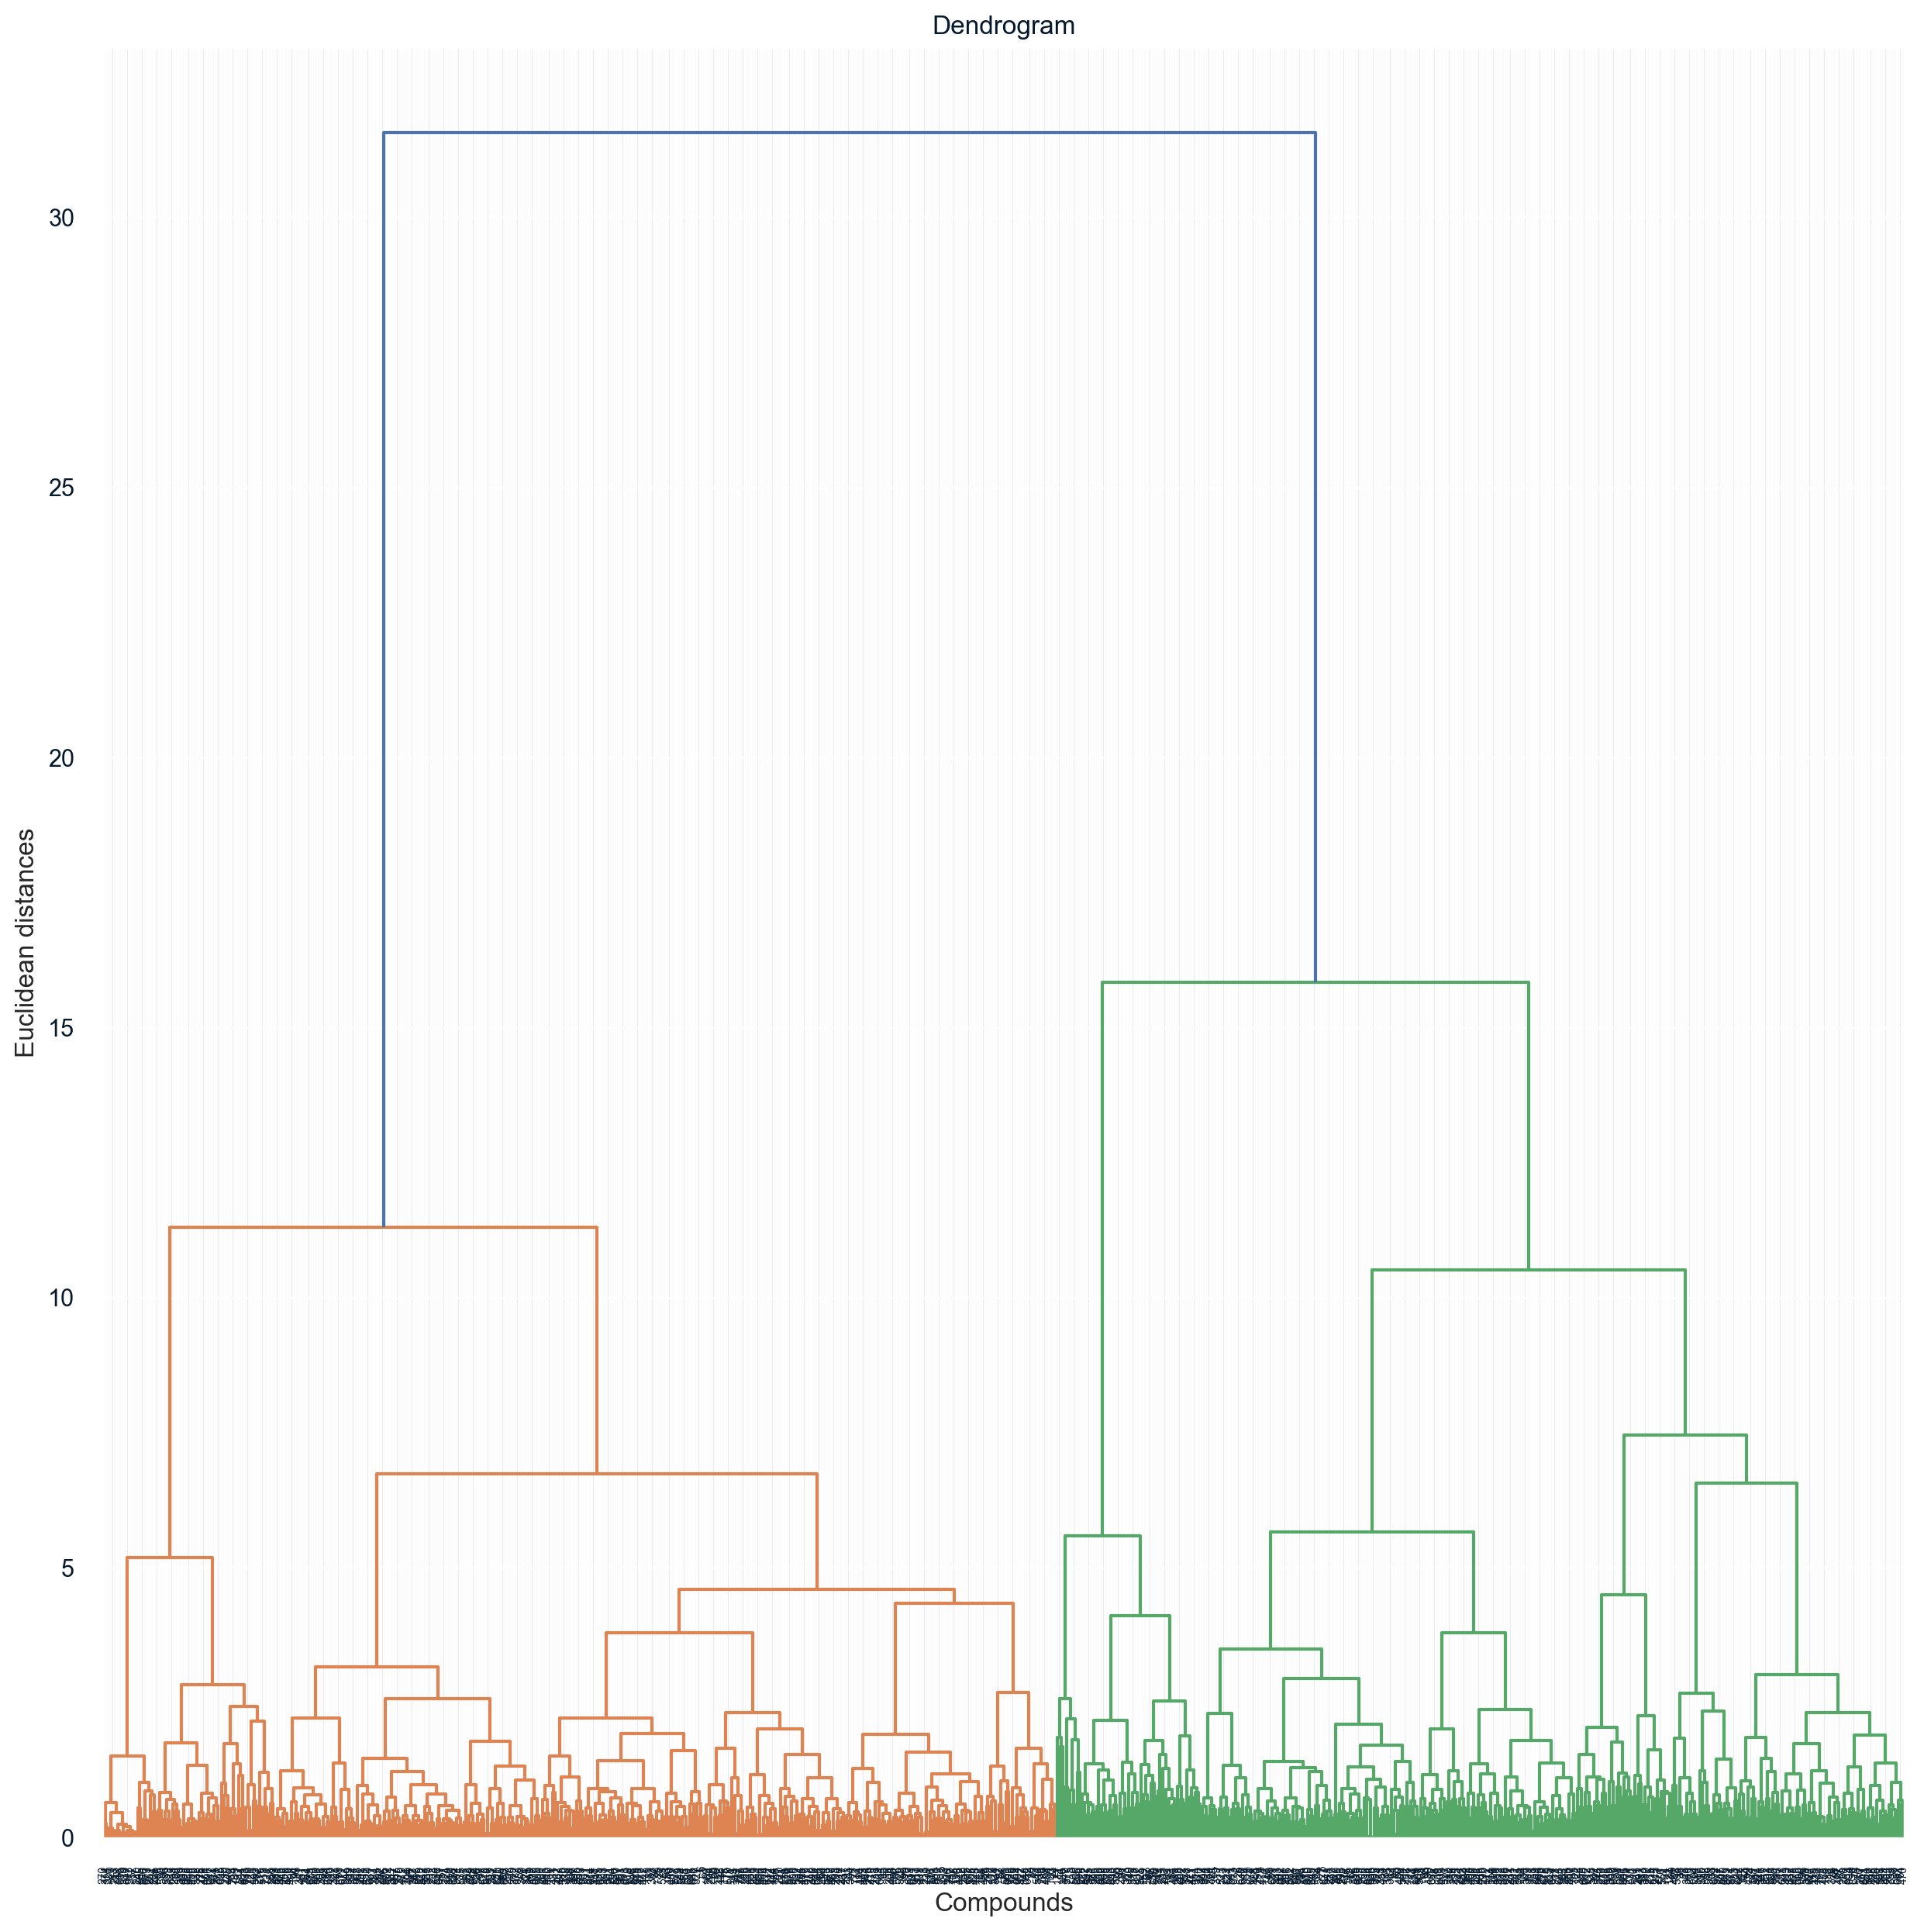

In [68]:
dendrogram = sch.dendrogram(sch.linkage(transformed, method = 'ward'))
plt.title('Dendrogram')
plt.xlabel('Compounds')
plt.ylabel('Euclidean distances')
plt.show()

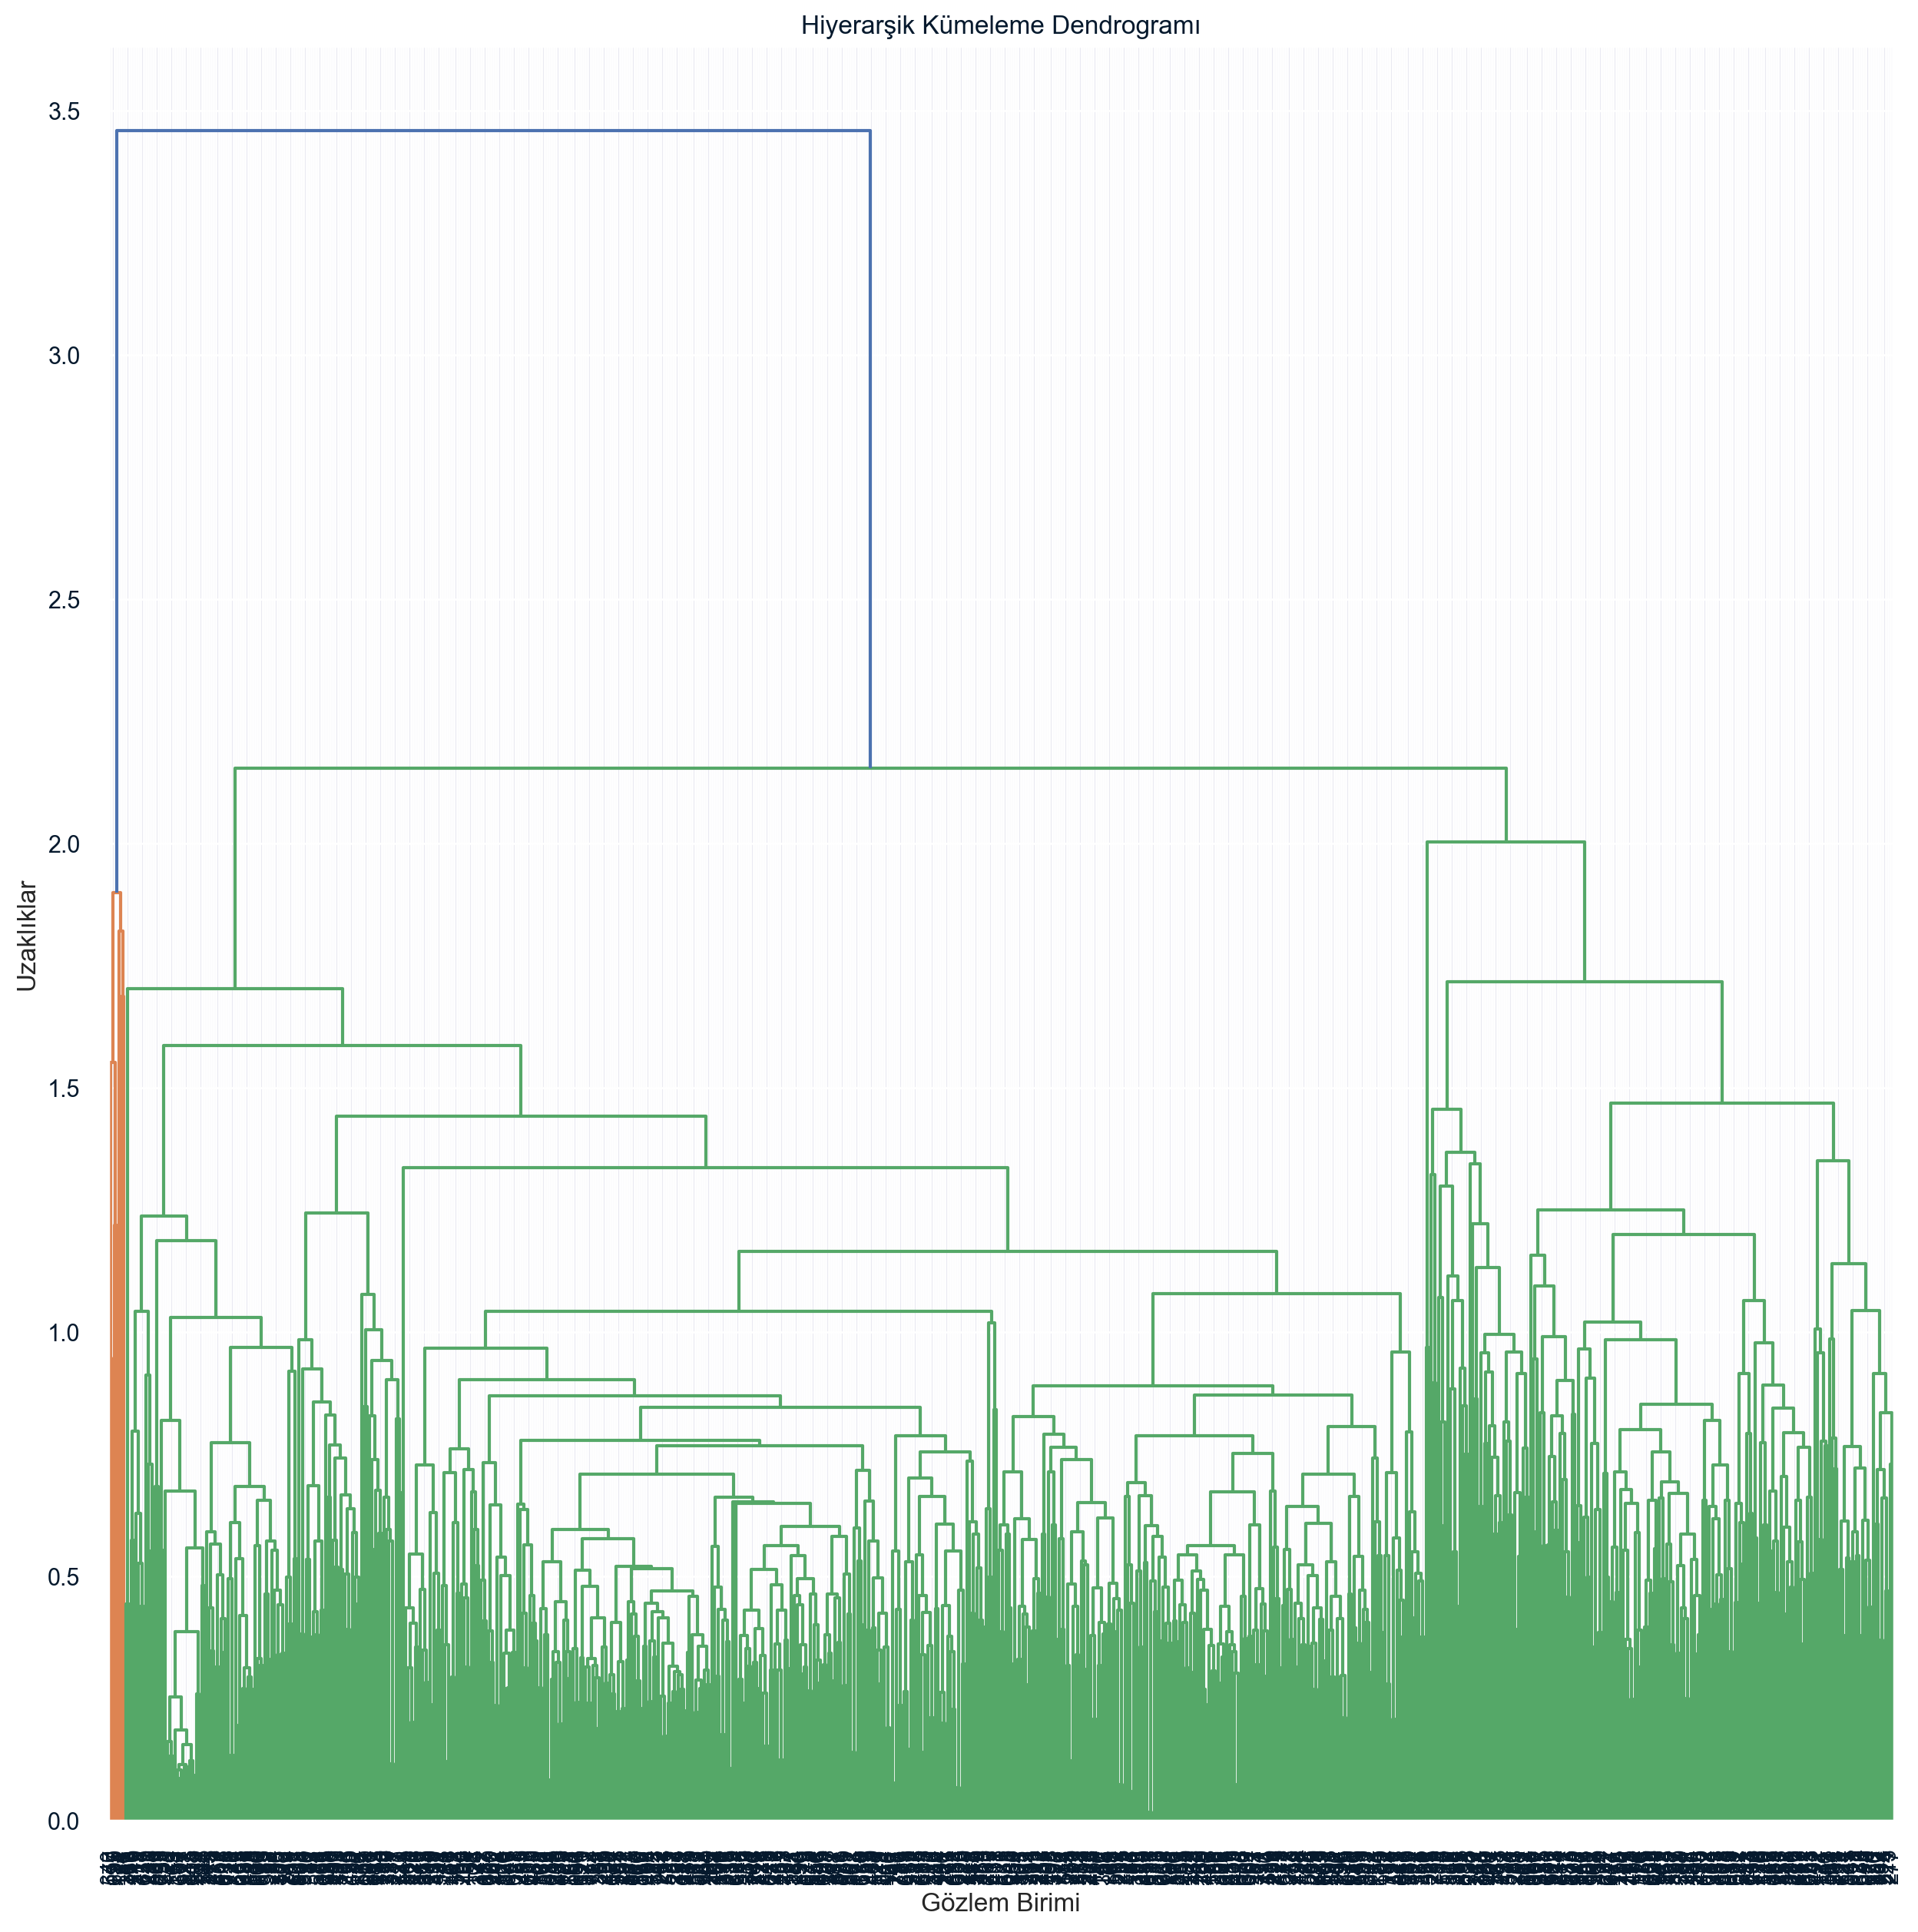

In [69]:
hc_average = sch.linkage(transformed, method="average")

# Grafik ayarları
plt.title("Hiyerarşik Kümeleme Dendrogramı")
plt.xlabel("Gözlem Birimi")
plt.ylabel("Uzaklıklar")

# Dendrogramı çizme
dendrogram2=sch.dendrogram(hc_average, leaf_font_size=10)

# Grafiği göster
plt.show()

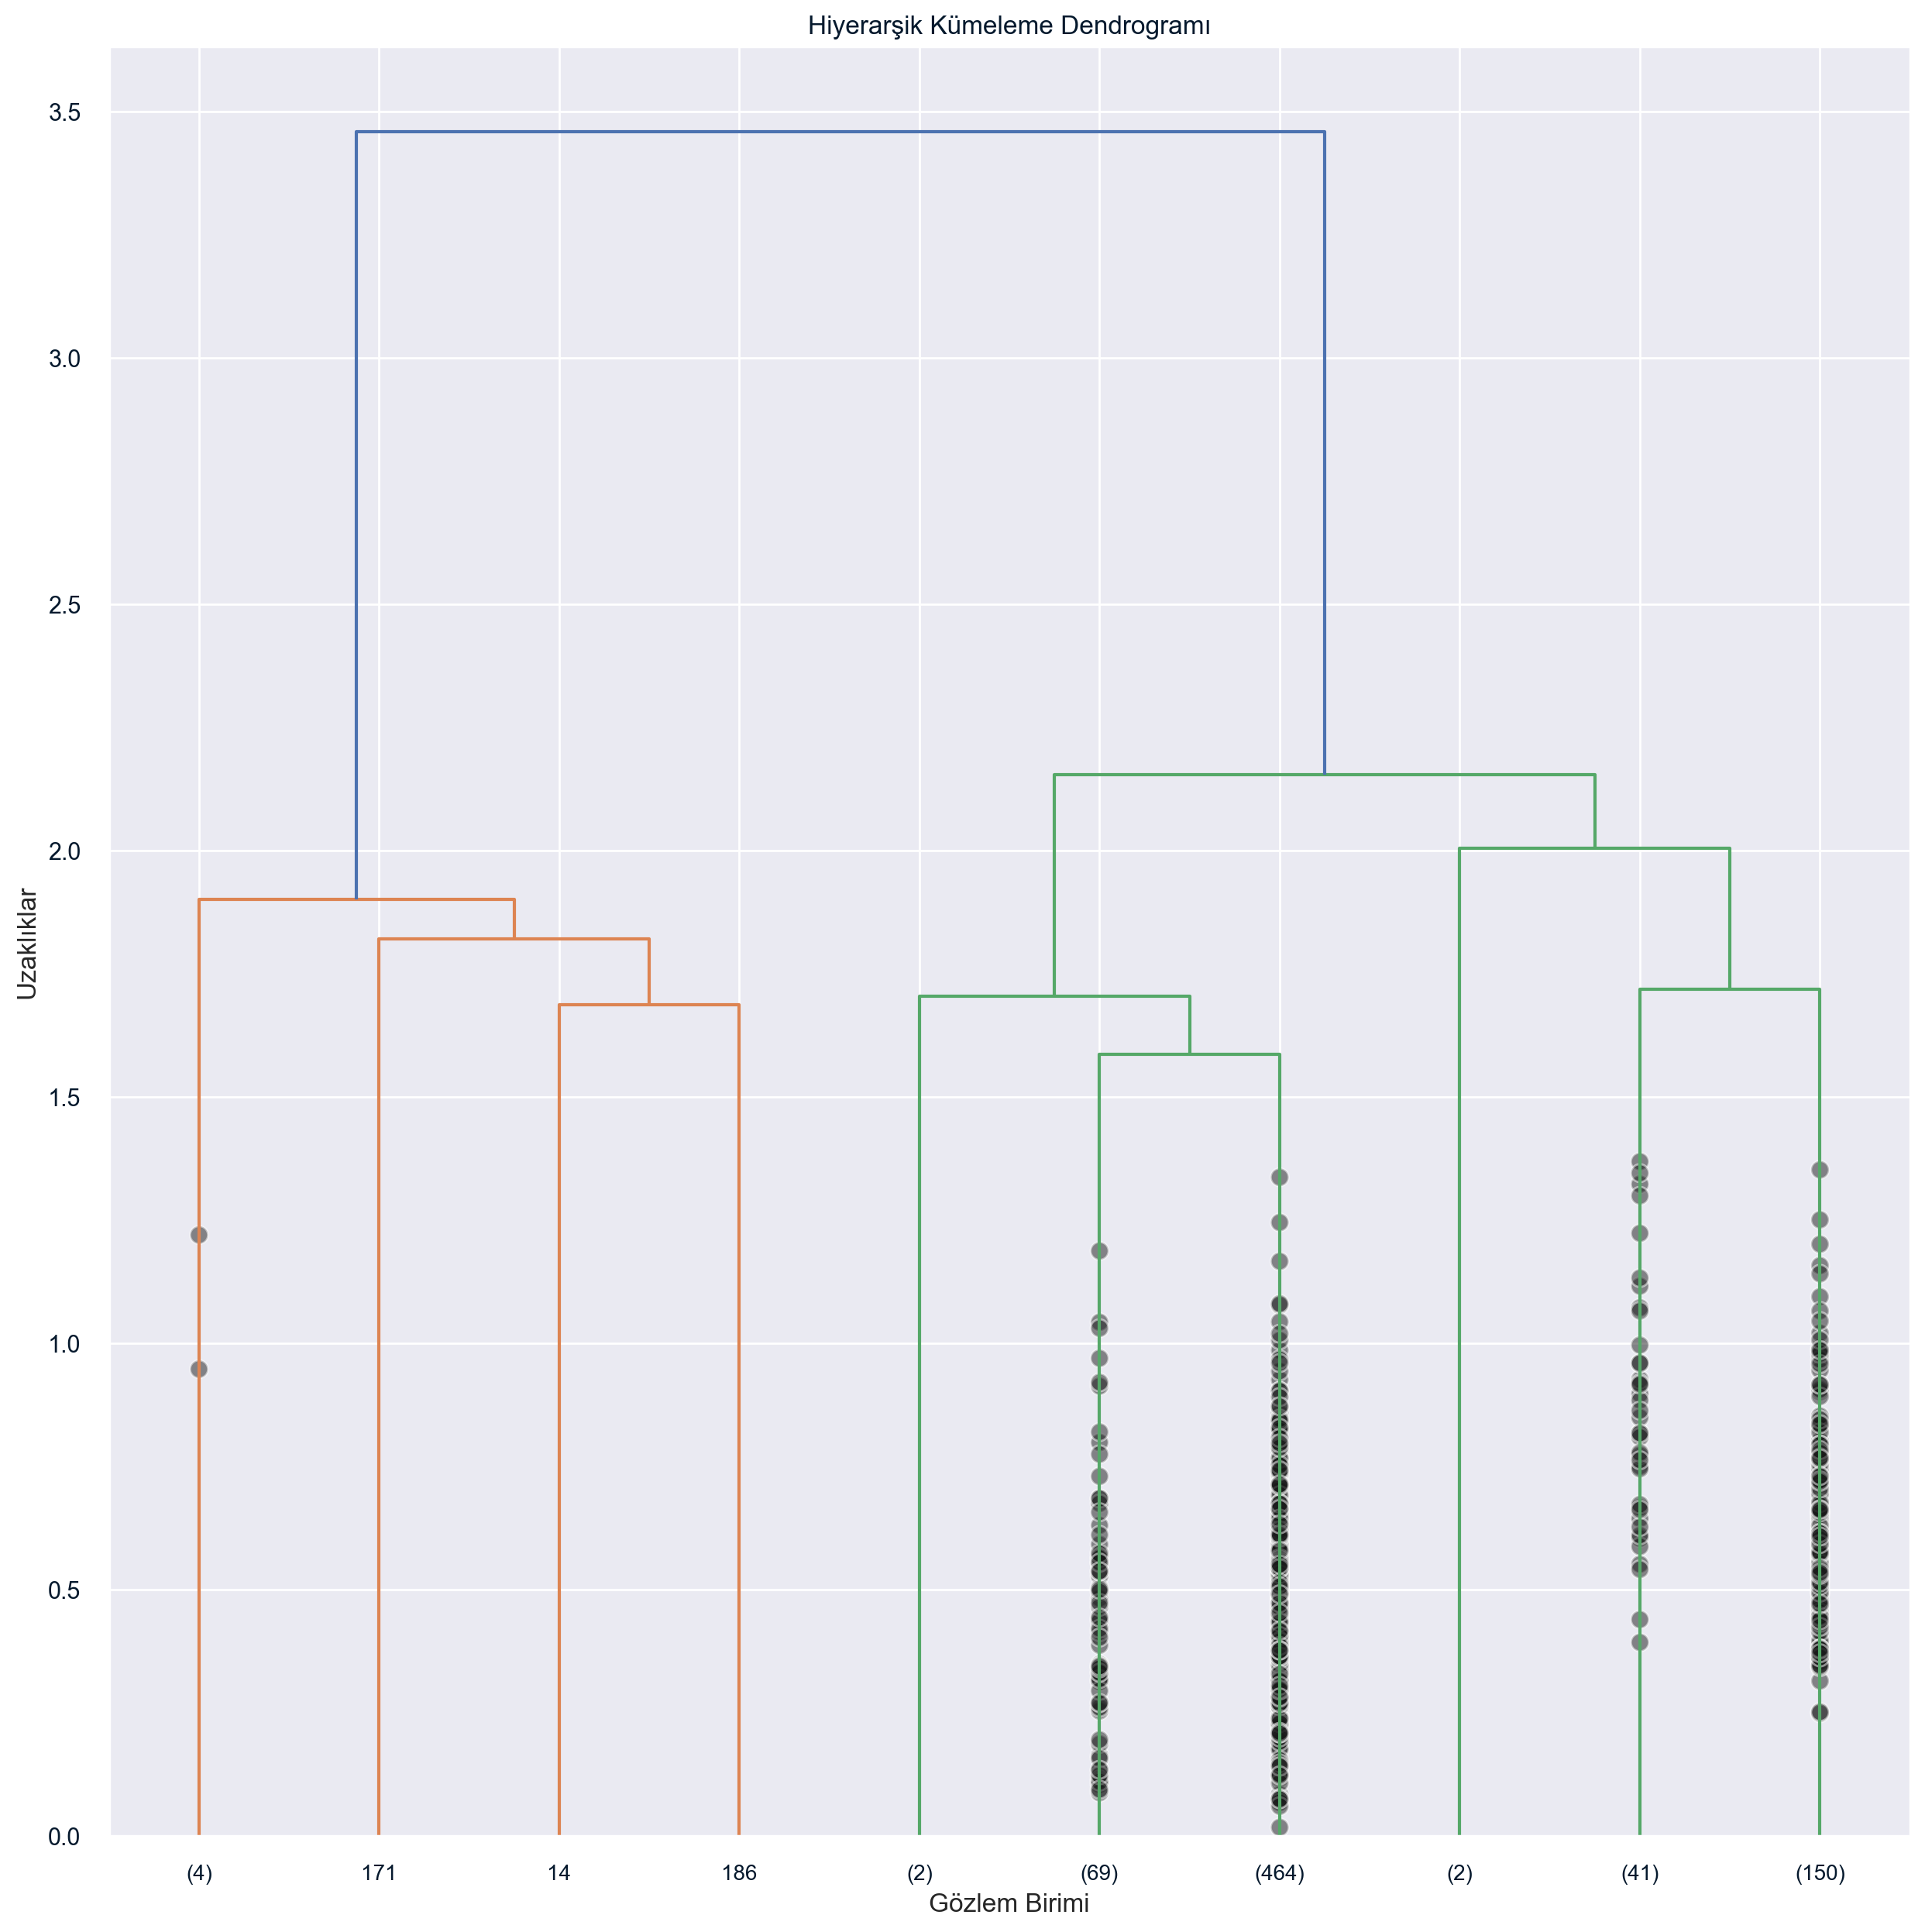

In [70]:
plt.title("Hiyerarşik Kümeleme Dendrogramı")
plt.xlabel("Gözlem Birimi")
plt.ylabel("Uzaklıklar")

# Dendrogramı çizme
dendrogram3=sch.dendrogram(hc_average,truncate_mode="lastp", p=10,show_contracted=True, leaf_font_size=10)

# Grafiği göster
plt.show()

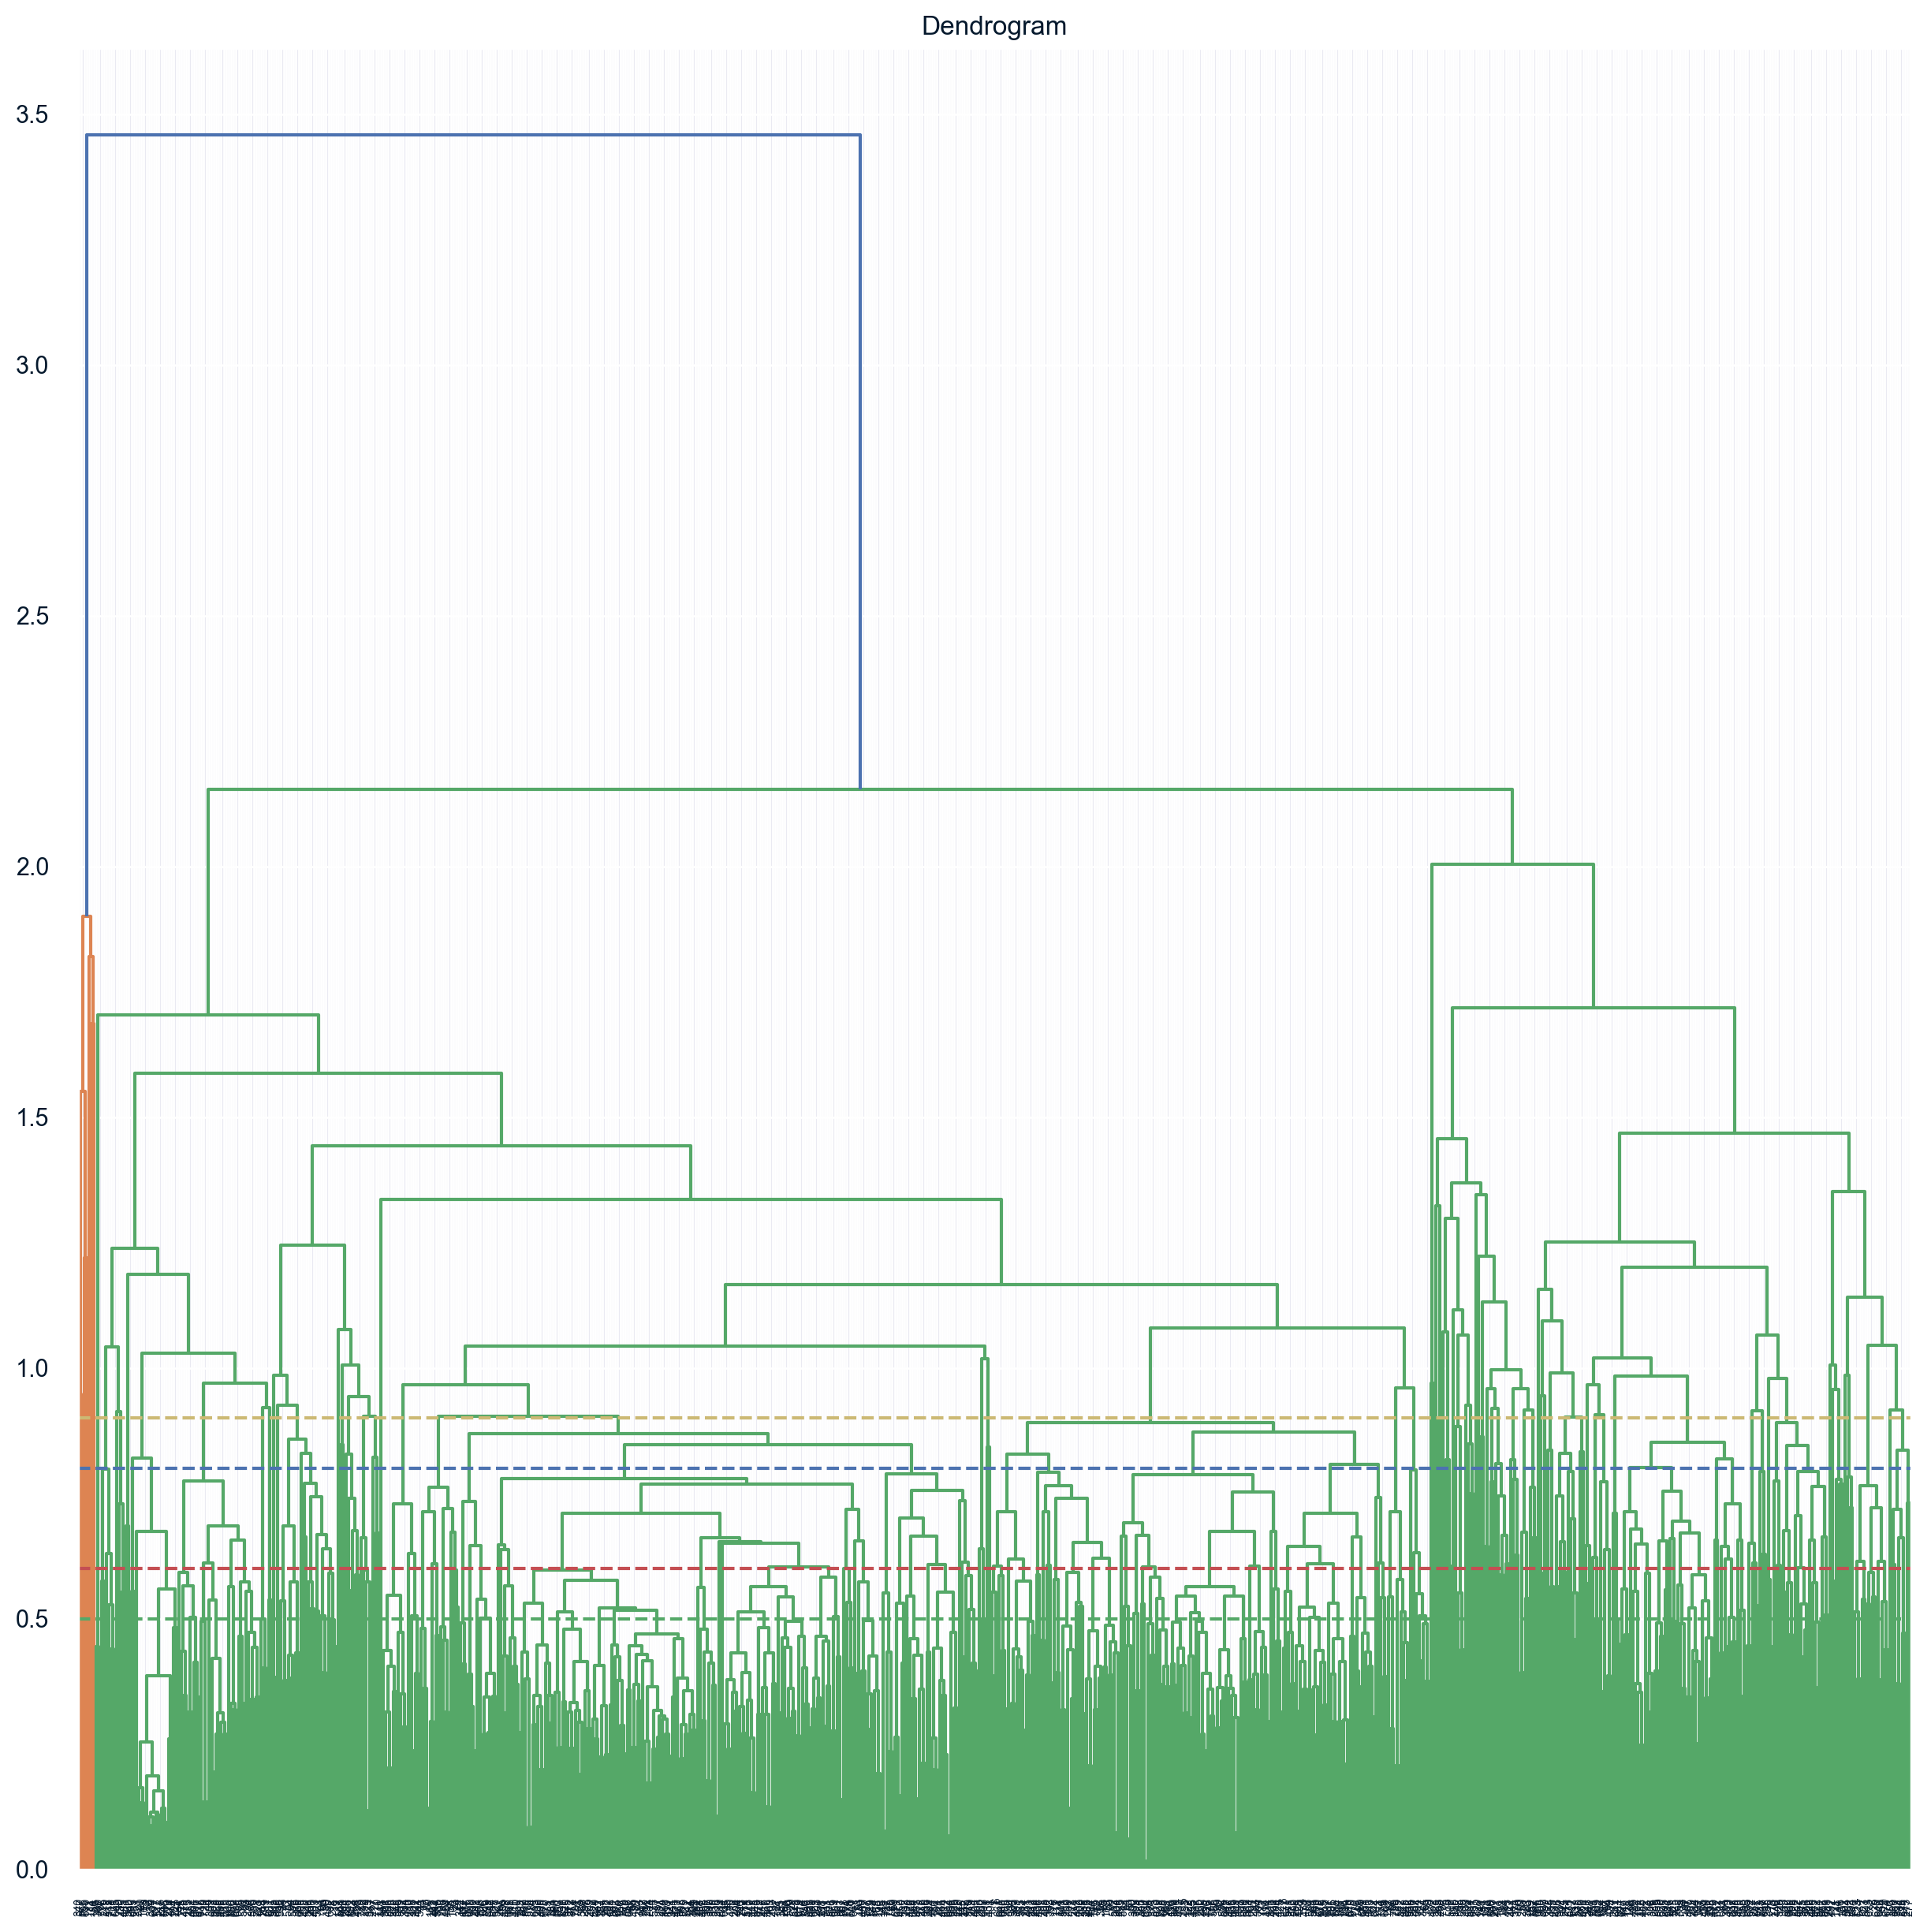

In [71]:
plt.title("Dendrogram")
dend=sch.dendrogram(hc_average)
plt.axhline(y=0.5, color="g", linestyle="--")
plt.axhline(y=0.6, color="r", linestyle="--")
plt.axhline(y=0.8, color="b", linestyle="--")
plt.axhline(y=0.9, color="y", linestyle="--")
plt.show()

In [72]:
cluster_hier=AgglomerativeClustering(n_clusters=6, linkage="average")

In [73]:
clusters_pred=cluster_hier.fit_predict(transformed)

In [74]:
df["hierarchical_clstr"]=clusters_pred

In [75]:
df["hierarchical_clstr"]=df["hierarchical_clstr"]+1

In [76]:
df.head()

Rk            Player   Pos  Age   Tm   G  GS     MP    FG    FGA   FG%    3P   3PA   3P%    2P    2PA   2P%  eFG%    FT   FTA   FT%   ORB   DRB    TRB   AST   STL   BLK   TOV    PF    PTS    FGM    FTM    EFF  Scoring_EFF  ORB_EFF  DRB_EFF  TOTAL_PTS  TOTAL_TRB  TOTAL_AST  TOTAL_BLK  TOTAL_STL  TOTAL_PF  TOTAL_FTA  TOTAL_FGA  TOTAL_FG%  TOTAL_3P%  TOTAL_2P%  TOTAL_MP  TOTAL_TOV  TOTAL_FGM  TOTAL_FTM  TOTAL_DRB  usage_rate  PTS_per_Attempt  Free_Throw_Rate     TS%   FGN   FTN  Seasons_Left  \
0   1  Precious Achiuwa  PF-C   24  TOT  74  18 21.900 3.200  6.300 0.501 0.400 1.300 0.268 2.800  5.000 0.562 0.529 0.900 1.500 0.616 2.600 4.000  6.600 1.300 0.600 0.900 1.100 1.900  7.600 -3.100 -0.600 14.400        0.558    0.394    0.606    562.400    488.400     96.200     66.600     44.400   140.600    111.000    466.200     37.074     19.832     41.588  1620.600     81.400   -229.400    -44.400    296.000       0.005            1.092            0.238  26.448 3.100 0.600         9.000   
1   1  Precious Achiuwa     C   24  TOR  25   0 17.500 3.100  6.800 0.459 0.500 1.900 0.277 2.600  4.900 0.528 0.497 1.000 1.700 0.571 2.000 3.400  5.400 1.800 0.600 0.500 1.200 1.600  7.700 -3.700 -0.700 12.800        0.515    0.370    0.630    192.500    135.000     45.000     12.500     15.000    40.000     42.500    170.000     11.475      6.925     13.200   437.500     30.000    -92.500    -17.500     85.000       0.020            1.020            0.250  29.060 3.700 0.700         9.000   
2   1  Precious Achiuwa    PF   24  NYK  49  18 24.200 3.200  6.100 0.525 0.300 1.000 0.260 2.900  5.100 0.578 0.547 0.900 1.400 0.643 2.900 4.300  7.200 1.100 0.600 1.100 1.100 2.100  7.600 -2.900 -0.500 15.300        0.584    0.403    0.597    372.400    352.800     53.900     53.900     29.400   102.900     68.600    298.900     25.725     12.740     28.322  1185.800     53.900   -142.100    -24.500    210.700       0.007            1.132            0.230  25.521 2.900 0.500         9.000   
3   2       Bam Adebayo     C   26  MIA  71  71 34.000 7.500 14.300 0.521 0.200 0.600 0.357 7.300 13.700 0.528 0.529 4.100 5.500 0.755 2.200 8.100 10.400 3.900 1.100 0.900 2.300 2.200 19.300 -6.800 -1.400 29.700        0.638    0.212    0.779   1370.300    738.400    276.900     63.900     78.100   156.200    390.500   1015.300     36.991     25.347     37.488  2414.000    163.300   -482.800    -99.400    575.100       0.008            1.154            0.385 161.348 6.800 1.400         7.500   
4   3      Ochai Agbaji    SG   23  TOT  78  28 21.000 2.300  5.600 0.411 0.800 2.700 0.294 1.500  2.800 0.523 0.483 0.500 0.700 0.661 0.900 1.800  2.800 1.100 0.600 0.600 0.800 1.500  5.800 -3.300 -0.200  8.200        0.536    0.321    0.643    452.400    218.400     85.800     46.800     46.800   117.000     54.600    436.800     32.058     22.932     40.794  1638.000     62.400   -257.400    -15.600    140.400       0.004            0.982            0.125  17.133 3.300 0.200         9.750   

   Total_Points  PIE_Per_Player  PIE_Per_Game   PIE  kmeans_clstr  hierarchical_clstr  
0         3.200           0.750       107.300 0.007             4                   1  
1         3.100          -0.950        -6.250 0.152             1                   3  
2         3.200           1.500       107.800 0.014             1                   1  
3         7.500           1.450       312.400 0.005             3                   1  
4         2.300          -2.050      -124.800 0.016             1                   3

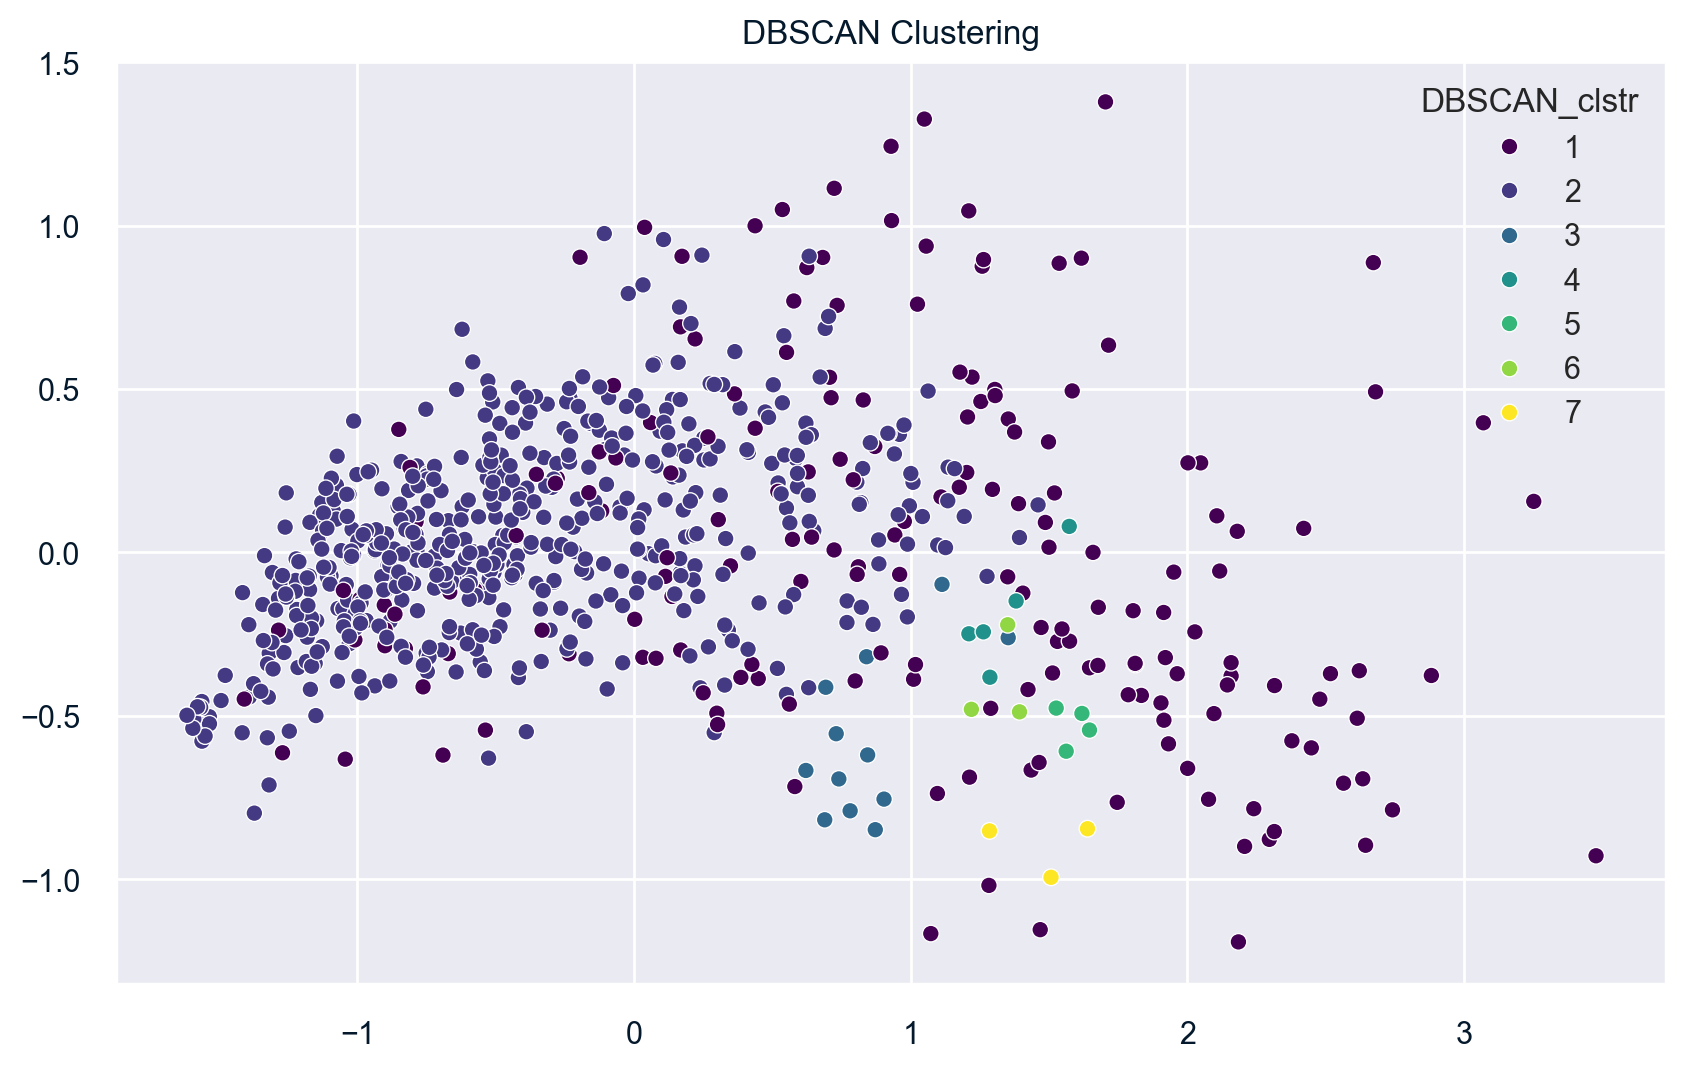

Rk            Player   Pos  Age   Tm   G  GS     MP    FG    FGA   FG%    3P   3PA   3P%    2P    2PA   2P%  eFG%    FT   FTA   FT%   ORB   DRB    TRB   AST   STL   BLK   TOV    PF    PTS    FGM    FTM    EFF  Scoring_EFF  ORB_EFF  DRB_EFF  TOTAL_PTS  TOTAL_TRB  TOTAL_AST  TOTAL_BLK  TOTAL_STL  TOTAL_PF  TOTAL_FTA  TOTAL_FGA  TOTAL_FG%  TOTAL_3P%  TOTAL_2P%  TOTAL_MP  TOTAL_TOV  TOTAL_FGM  TOTAL_FTM  TOTAL_DRB  usage_rate  PTS_per_Attempt  Free_Throw_Rate     TS%   FGN   FTN  Seasons_Left  \
0   1  Precious Achiuwa  PF-C   24  TOT  74  18 21.900 3.200  6.300 0.501 0.400 1.300 0.268 2.800  5.000 0.562 0.529 0.900 1.500 0.616 2.600 4.000  6.600 1.300 0.600 0.900 1.100 1.900  7.600 -3.100 -0.600 14.400        0.558    0.394    0.606    562.400    488.400     96.200     66.600     44.400   140.600    111.000    466.200     37.074     19.832     41.588  1620.600     81.400   -229.400    -44.400    296.000       0.005            1.092            0.238  26.448 3.100 0.600         9.000   
1   1  Precious Achiuwa     C   24  TOR  25   0 17.500 3.100  6.800 0.459 0.500 1.900 0.277 2.600  4.900 0.528 0.497 1.000 1.700 0.571 2.000 3.400  5.400 1.800 0.600 0.500 1.200 1.600  7.700 -3.700 -0.700 12.800        0.515    0.370    0.630    192.500    135.000     45.000     12.500     15.000    40.000     42.500    170.000     11.475      6.925     13.200   437.500     30.000    -92.500    -17.500     85.000       0.020            1.020            0.250  29.060 3.700 0.700         9.000   
2   1  Precious Achiuwa    PF   24  NYK  49  18 24.200 3.200  6.100 0.525 0.300 1.000 0.260 2.900  5.100 0.578 0.547 0.900 1.400 0.643 2.900 4.300  7.200 1.100 0.600 1.100 1.100 2.100  7.600 -2.900 -0.500 15.300        0.584    0.403    0.597    372.400    352.800     53.900     53.900     29.400   102.900     68.600    298.900     25.725     12.740     28.322  1185.800     53.900   -142.100    -24.500    210.700       0.007            1.132            0.230  25.521 2.900 0.500         9.000   
3   2       Bam Adebayo     C   26  MIA  71  71 34.000 7.500 14.300 0.521 0.200 0.600 0.357 7.300 13.700 0.528 0.529 4.100 5.500 0.755 2.200 8.100 10.400 3.900 1.100 0.900 2.300 2.200 19.300 -6.800 -1.400 29.700        0.638    0.212    0.779   1370.300    738.400    276.900     63.900     78.100   156.200    390.500   1015.300     36.991     25.347     37.488  2414.000    163.300   -482.800    -99.400    575.100       0.008            1.154            0.385 161.348 6.800 1.400         7.500   
4   3      Ochai Agbaji    SG   23  TOT  78  28 21.000 2.300  5.600 0.411 0.800 2.700 0.294 1.500  2.800 0.523 0.483 0.500 0.700 0.661 0.900 1.800  2.800 1.100 0.600 0.600 0.800 1.500  5.800 -3.300 -0.200  8.200        0.536    0.321    0.643    452.400    218.400     85.800     46.800     46.800   117.000     54.600    436.800     32.058     22.932     40.794  1638.000     62.400   -257.400    -15.600    140.400       0.004            0.982            0.125  17.133 3.300 0.200         9.750   

   Total_Points  PIE_Per_Player  PIE_Per_Game   PIE  kmeans_clstr  hierarchical_clstr  DBSCAN_clstr  
0         3.200           0.750       107.300 0.007             4                   1             2  
1         3.100          -0.950        -6.250 0.152             1                   3             2  
2         3.200           1.500       107.800 0.014             1                   1             2  
3         7.500           1.450       312.400 0.005             3                   1             1  
4         2.300          -2.050      -124.800 0.016             1                   3             2

In [77]:
#DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=3)
df['DBSCAN_clstr'] = dbscan.fit_predict(transformed)+2

plt.figure(figsize=(10, 6))
sns.scatterplot(x=transformed[:, 0], y=transformed[:, 1], hue='DBSCAN_clstr', data=df, palette='viridis')
plt.title('DBSCAN Clustering')
plt.show()
df.head()

In [78]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import plotly.express as px
import plotly.graph_objects as go


# Orijinal veri setini yükleme
regular_season_df = pd.read_csv('./2023-2024 NBA Player Stats - Regular.csv', encoding='latin1', delimiter=';')

# Sütun adlarını ve ilk birkaç satırı kontrol etme
print("Sütun adları:", regular_season_df.columns)
print("İlk birkaç satır:\n", regular_season_df.head())

# Sayısal olmayan sütunları tespit etme ve temizleme
df_numeric = regular_season_df.apply(pd.to_numeric, errors='coerce')

# Sonsuz veya çok büyük değerleri NaN ile değiştirme işlemi kaldırıldı
# df_numeric.replace([np.inf, -np.inf], np.nan, inplace=True)
# df_numeric[df_numeric > np.finfo(np.float32).max] = np.nan

# NaN değerleri ortalama ile doldurma işlemi kaldırıldı
# df_numeric.fillna(df_numeric.mean(), inplace=True)

# Özellik ve hedef değişkeni belirleme
X = df_numeric.drop(columns=['Rk', 'Player', 'Pos', 'Tm', 'PTS'])  # Özellikler
y = df_numeric['PTS']  # Hedef değişken

# Modeli tanımlama
model = RandomForestRegressor(random_state=42)

# Modeli tüm veri seti ile eğitme
model.fit(X, y)

# Tahmin yapma
y_pred = model.predict(X)

# Model değerlendirme
mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

# Tahmin edilen sonuçları ve gerçek sonuçları birleştirerek gösterme
results = pd.DataFrame({'Player': regular_season_df['Player'], 'Actual_PTS': y, 'Predicted_PTS': y_pred})
results = results.reset_index(drop=True)
print(results.head())

# Şampiyon olacak oyuncuları belirleme
# Örneğin, 'Predicted_PTS' değeri 0 veya daha az olan oyuncular şampiyon olmuş olabilir
champions = results[results['Predicted_PTS'] <= 0]
print("Şampiyon olacak oyuncular:")
print(champions)

# Gerçek ve tahmin edilen değerleri görselleştirme
fig = px.scatter(results, x='Actual_PTS', y='Predicted_PTS', hover_data=['Player'], title='Actual vs Predicted PTS')
fig.add_shape(type='line', x0=results['Actual_PTS'].min(), y0=results['Actual_PTS'].min(), x1=results['Actual_PTS'].max(), y1=results['Actual_PTS'].max(), line=dict(color='Red',))
fig.show()


Sütun adları: Index(['Rk', 'Player', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS'], dtype='object')
İlk birkaç satır:
    Rk            Player   Pos  Age   Tm   G  GS     MP    FG    FGA   FG%    3P   3PA   3P%    2P    2PA   2P%  eFG%    FT   FTA   FT%   ORB   DRB    TRB   AST   STL   BLK   TOV    PF    PTS
0   1  Precious Achiuwa  PF-C   24  TOT  74  18 21.900 3.200  6.300 0.501 0.400 1.300 0.268 2.800  5.000 0.562 0.529 0.900 1.500 0.616 2.600 4.000  6.600 1.300 0.600 0.900 1.100 1.900  7.600
1   1  Precious Achiuwa     C   24  TOR  25   0 17.500 3.100  6.800 0.459 0.500 1.900 0.277 2.600  4.900 0.528 0.497 1.000 1.700 0.571 2.000 3.400  5.400 1.800 0.600 0.500 1.200 1.600  7.700
2   1  Precious Achiuwa    PF   24  NYK  49  18 24.200 3.200  6.100 0.525 0.300 1.000 0.260 2.900  5.100 0.578 0.547 0.900 1.400 0.643 2.900 4.300  7.200 1.100 0.600 1

In [79]:
import pandas as pd

# Orijinal veri setini yükleme
regular_season_df = pd.read_csv('./2023-2024 NBA Player Stats - Regular.csv', encoding='latin1')

# Sütun adlarını ve ilk birkaç satırı kontrol etme
print(regular_season_df.columns)
print(regular_season_df.head())

Index(['Rk;Player;Pos;Age;Tm;G;GS;MP;FG;FGA;FG%;3P;3PA;3P%;2P;2PA;2P%;eFG%;FT;FTA;FT%;ORB;DRB;TRB;AST;STL;BLK;TOV;PF;PTS'], dtype='object')
  Rk;Player;Pos;Age;Tm;G;GS;MP;FG;FGA;FG%;3P;3PA;3P%;2P;2PA;2P%;eFG%;FT;FTA;FT%;ORB;DRB;TRB;AST;STL;BLK;TOV;PF;PTS
0  1;Precious Achiuwa;PF-C;24;TOT;74;18;21.9;3.2;...                                                              
1  1;Precious Achiuwa;C;24;TOR;25;0;17.5;3.1;6.8;...                                                              
2  1;Precious Achiuwa;PF;24;NYK;49;18;24.2;3.2;6....                                                              
3  2;Bam Adebayo;C;26;MIA;71;71;34;7.5;14.3;0.521...                                                              
4  3;Ochai Agbaji;SG;23;TOT;78;28;21;2.3;5.6;0.41...                                                              


In [80]:
import pandas as pd

# Orijinal veri setini yükleme
regular_season_df = pd.read_csv('./2023-2024 NBA Player Stats - Regular.csv', encoding='latin1')

# Sütun adlarını ve ilk birkaç satırı kontrol etme
print(regular_season_df.columns)
print(regular_season_df.head())

Index(['Rk;Player;Pos;Age;Tm;G;GS;MP;FG;FGA;FG%;3P;3PA;3P%;2P;2PA;2P%;eFG%;FT;FTA;FT%;ORB;DRB;TRB;AST;STL;BLK;TOV;PF;PTS'], dtype='object')
  Rk;Player;Pos;Age;Tm;G;GS;MP;FG;FGA;FG%;3P;3PA;3P%;2P;2PA;2P%;eFG%;FT;FTA;FT%;ORB;DRB;TRB;AST;STL;BLK;TOV;PF;PTS
0  1;Precious Achiuwa;PF-C;24;TOT;74;18;21.9;3.2;...                                                              
1  1;Precious Achiuwa;C;24;TOR;25;0;17.5;3.1;6.8;...                                                              
2  1;Precious Achiuwa;PF;24;NYK;49;18;24.2;3.2;6....                                                              
3  2;Bam Adebayo;C;26;MIA;71;71;34;7.5;14.3;0.521...                                                              
4  3;Ochai Agbaji;SG;23;TOT;78;28;21;2.3;5.6;0.41...                                                              


In [81]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import plotly.express as px
import plotly.graph_objects as go

# Orijinal veri setini yükleme
regular_season_df = pd.read_csv('./2023-2024 NBA Player Stats - Regular.csv', encoding='latin1', delimiter=';')

# Sütun adlarını ve ilk birkaç satırı kontrol etme
print("Sütun adları:", regular_season_df.columns)
print("İlk birkaç satır:\n", regular_season_df.head())

# Sayısal olmayan sütunları tespit etme ve temizleme
df_numeric = regular_season_df.apply(pd.to_numeric, errors='coerce')

# Sonsuz veya çok büyük değerleri NaN ile değiştirme işlemi kaldırıldı
# df_numeric.replace([np.inf, -np.inf], np.nan, inplace=True)
# df_numeric[df_numeric > np.finfo(np.float32).max] = np.nan

# NaN değerleri ortalama ile doldurma işlemi kaldırıldı
# df_numeric.fillna(df_numeric.mean(), inplace=True)

# Özellik ve hedef değişkeni belirleme
X = df_numeric.drop(columns=['Rk', 'Player', 'Pos', 'Tm', 'AST'])  # Özellikler
y = df_numeric['AST']  # Hedef değişken

# Modeli tanımlama
model = GradientBoostingRegressor(random_state=42)

# Çapraz doğrulama ile model performansını değerlendirme
cv_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
cv_scores = -cv_scores
mean_mse = np.mean(cv_scores)
std_mse = np.std(cv_scores)
print(f"Cross-Validation Mean MSE: {mean_mse}")
print(f"Cross-Validation Std MSE: {std_mse}")

# Modeli tüm veri seti ile eğitme
model.fit(X, y)

# Tahmin yapma
y_pred = model.predict(X)

# Model değerlendirme
mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

# Tahmin edilen sonuçları ve gerçek sonuçları birleştirerek gösterme
results = pd.DataFrame({'Player': regular_season_df['Player'], 'Actual_AST': y, 'Predicted_AST': y_pred})
results = results.reset_index(drop=True)
print(results.head())

# Gerçek ve tahmin edilen değerleri görselleştirme
fig = px.scatter(results, x='Actual_AST', y='Predicted_AST', hover_data=['Player'], title='Actual vs Predicted AST')
fig.add_shape(type='line', x0=results['Actual_AST'].min(), y0=results['Actual_AST'].min(), x1=results['Actual_AST'].max(), y1=results['Actual_AST'].max(), line=dict(color='Red',))
fig.show()

# Özellik önemini görselleştirme
feature_importances = model.feature_importances_
features = X.columns
fig = px.bar(x=features, y=feature_importances, title='Feature Importances')
fig.show()

Sütun adları: Index(['Rk', 'Player', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS'], dtype='object')
İlk birkaç satır:
    Rk            Player   Pos  Age   Tm   G  GS     MP    FG    FGA   FG%    3P   3PA   3P%    2P    2PA   2P%  eFG%    FT   FTA   FT%   ORB   DRB    TRB   AST   STL   BLK   TOV    PF    PTS
0   1  Precious Achiuwa  PF-C   24  TOT  74  18 21.900 3.200  6.300 0.501 0.400 1.300 0.268 2.800  5.000 0.562 0.529 0.900 1.500 0.616 2.600 4.000  6.600 1.300 0.600 0.900 1.100 1.900  7.600
1   1  Precious Achiuwa     C   24  TOR  25   0 17.500 3.100  6.800 0.459 0.500 1.900 0.277 2.600  4.900 0.528 0.497 1.000 1.700 0.571 2.000 3.400  5.400 1.800 0.600 0.500 1.200 1.600  7.700
2   1  Precious Achiuwa    PF   24  NYK  49  18 24.200 3.200  6.100 0.525 0.300 1.000 0.260 2.900  5.100 0.578 0.547 0.900 1.400 0.643 2.900 4.300  7.200 1.100 0.600 1

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import plotly.express as px
import plotly.graph_objects as go

regular_season_df = pd.read_csv('./2023-2024 NBA Player Stats - Regular.csv', encoding='latin1', delimiter=';')

print("Sütun adları:", regular_season_df.columns)
print("İlk birkaç satır:\n", regular_season_df.head())

df_numeric = regular_season_df.apply(pd.to_numeric, errors='coerce')

# Sonsuz veya çok büyük değerleri NaN ile değiştirme işlemi kaldırıldı
# df_numeric.replace([np.inf, -np.inf], np.nan, inplace=True)
# df_numeric[df_numeric > np.finfo(np.float32).max] = np.nan

# NaN değerleri ortalama ile doldurma işlemi kaldırıldı
# df_numeric.fillna(df_numeric.mean(), inplace=True)

X = df_numeric.drop(columns=['Rk', 'Player', 'Pos', 'Tm', 'PTS'])  # Özellikler
y = df_numeric['PTS']  # Hedef değişken

model = RandomForestRegressor(random_state=42)

cv_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
cv_scores = -cv_scores
mean_mse = np.mean(cv_scores)
std_mse = np.std(cv_scores)
print(f"Cross-Validation Mean MSE: {mean_mse}")
print(f"Cross-Validation Std MSE: {std_mse}")

model.fit(X, y)

y_pred_2025 = model.predict(X)

results_2025 = pd.DataFrame({'Player': regular_season_df['Player'], 'Predicted_PTS_2025': y_pred_2025})
results_2025 = results_2025.reset_index(drop=True)
print(results_2025.head())

top_10_champions_2025 = results_2025.nlargest(10, 'Predicted_PTS_2025')
print("2025 yılında şampiyon olması muhtemel 10 oyuncu:")
print(top_10_champions_2025)

fig = px.scatter(results_2025, x='Player', y='Predicted_PTS_2025', hover_data=['Player'], title='Predicted PTS for 2025')
fig.show()

Sütun adları: Index(['Rk', 'Player', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%',
       '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%',
       'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS'],
      dtype='object')
İlk birkaç satır:
    Rk            Player   Pos  Age   Tm   G  ...  AST  STL  BLK  TOV   PF   PTS
0   1  Precious Achiuwa  PF-C   24  TOT  74  ...  1.3  0.6  0.9  1.1  1.9   7.6
1   1  Precious Achiuwa     C   24  TOR  25  ...  1.8  0.6  0.5  1.2  1.6   7.7
2   1  Precious Achiuwa    PF   24  NYK  49  ...  1.1  0.6  1.1  1.1  2.1   7.6
3   2       Bam Adebayo     C   26  MIA  71  ...  3.9  1.1  0.9  2.3  2.2  19.3
4   3      Ochai Agbaji    SG   23  TOT  78  ...  1.1  0.6  0.6  0.8  1.5   5.8

[5 rows x 30 columns]
Cross-Validation Mean MSE: 0.4543727700680272
Cross-Validation Std MSE: 0.29993642572776386
             Player  Predicted_PTS_2025
0  Precious Achiuwa               7.809
1  Precious Achiuwa               7.795
2  Pr

In [83]:
# 2025 yılı için tahmin yapma
# Mevcut veri setindeki özellikleri kullanarak 2025 yılı için tahmin yapıyoruz
y_pred_2025 = model.predict(X)

# Tahmin edilen sonuçları ve gerçek sonuçları birleştirerek gösterme
results_2025 = pd.DataFrame({'Player': regular_season_df['Player'], 'Predicted_PTS_2025': y_pred_2025})
results_2025 = results_2025.reset_index(drop=True)
print(results_2025.head())

# 2025 yılında şampiyon olması muhtemel 10 oyuncuyu belirleme
top_10_champions_2025 = results_2025.nlargest(10, 'Predicted_PTS_2025')
print("2025 yılında şampiyon olması muhtemel 10 oyuncu:")
print(top_10_champions_2025)

             Player  Predicted_PTS_2025
0  Precious Achiuwa               7.809
1  Precious Achiuwa               7.795
2  Precious Achiuwa               7.731
3       Bam Adebayo              19.534
4      Ochai Agbaji               5.847
2025 yılında şampiyon olması muhtemel 10 oyuncu:
                      Player  Predicted_PTS_2025
186              Joel Embiid              33.139
171              Luka Don?i?              32.430
14     Giannis Antetokounmpo              30.022
235  Shai Gilgeous-Alexander              29.591
109            Jalen Brunson              27.758
81              Devin Booker              26.831
180             Kevin Durant              26.696
630             Jayson Tatum              26.657
207             De'Aaron Fox              26.563
340             Nikola Joki?              26.497


In [84]:

X = df_numeric.drop(columns=['Rk', 'Player', 'Pos', 'Tm', 'TOV'])  # Özellikler
y = df_numeric['TOV']  # Hedef değişken

model = RandomForestRegressor(random_state=42)

cv_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
cv_scores = -cv_scores
mean_mse = np.mean(cv_scores)
std_mse = np.std(cv_scores)
print(f"Cross-Validation Mean MSE: {mean_mse}")
print(f"Cross-Validation Std MSE: {std_mse}")

model.fit(X, y)

y_pred_2025 = model.predict(X)

results_2025 = pd.DataFrame({'Player': regular_season_df['Player'], 'Predicted_TOV_2025': y_pred_2025})
results_2025 = results_2025.reset_index(drop=True)
print(results_2025.head())
top_10_champions_2025 = results_2025.nlargest(10, 'Predicted_TOV_2025')
print("2025 yılında şampiyon olması muhtemel 10 oyuncu:")
print(top_10_champions_2025)

Cross-Validation Mean MSE: 0.09931629931972787
Cross-Validation Std MSE: 0.020257066198905712
             Player  Predicted_TOV_2025
0  Precious Achiuwa               1.053
1  Precious Achiuwa               1.145
2  Precious Achiuwa               1.094
3       Bam Adebayo               2.365
4      Ochai Agbaji               0.783
2025 yılında şampiyon olması muhtemel 10 oyuncu:
                    Player  Predicted_TOV_2025
731             Trae Young               3.962
171            Luka Don?i?               3.841
186            Joel Embiid               3.540
30             LaMelo Ball               3.407
14   Giannis Antetokounmpo               3.327
325           LeBron James               3.290
550          Julius Randle               3.286
690      Victor Wembanyama               3.286
149        Cade Cunningham               3.148
340           Nikola Joki?               3.134


In [85]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
import numpy as np

regular_season_df = pd.read_csv('./2023-2024 NBA Player Stats - Regular.csv', encoding='latin1', delimiter=';')

print("Sütun adları:", regular_season_df.columns)
print("İlk birkaç satır:\n", regular_season_df.head())

df_numeric = regular_season_df.apply(pd.to_numeric, errors='coerce')

# Sonsuz veya çok büyük değerleri NaN ile değiştirme işlemi kaldırıldı
# df_numeric.replace([np.inf, -np.inf], np.nan, inplace=True)
# df_numeric[df_numeric > np.finfo(np.float32).max] = np.nan

# NaN değerleri ortalama ile doldurma işlemi kaldırıldı
# df_numeric.fillna(df_numeric.mean(), inplace=True)

X = df_numeric.drop(columns=['Rk', 'Player', 'Pos', 'Tm', 'TOV'])  # Özellikler
y = df_numeric['TOV']  # Hedef değişken

model = RandomForestRegressor(random_state=42)

model.fit(X, y)

feature_importances = model.feature_importances_

features_sorted = sorted(zip(X.columns, feature_importances), key=lambda x: x[1], reverse=True)

weighted_feature = np.dot(X, feature_importances)

df_numeric['Weighted_Feature'] = weighted_feature

features_sorted_df = pd.DataFrame(features_sorted, columns=['Feature', 'Importance'])
print(features_sorted_df)

print("Yeni özellik (Weighted_Feature) ve ağırlıkları:")
print(df_numeric[['Weighted_Feature']].head())

Sütun adları: Index(['Rk', 'Player', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS'], dtype='object')
İlk birkaç satır:
    Rk            Player   Pos  Age   Tm   G  GS     MP    FG    FGA   FG%    3P   3PA   3P%    2P    2PA   2P%  eFG%    FT   FTA   FT%   ORB   DRB    TRB   AST   STL   BLK   TOV    PF    PTS
0   1  Precious Achiuwa  PF-C   24  TOT  74  18 21.900 3.200  6.300 0.501 0.400 1.300 0.268 2.800  5.000 0.562 0.529 0.900 1.500 0.616 2.600 4.000  6.600 1.300 0.600 0.900 1.100 1.900  7.600
1   1  Precious Achiuwa     C   24  TOR  25   0 17.500 3.100  6.800 0.459 0.500 1.900 0.277 2.600  4.900 0.528 0.497 1.000 1.700 0.571 2.000 3.400  5.400 1.800 0.600 0.500 1.200 1.600  7.700
2   1  Precious Achiuwa    PF   24  NYK  49  18 24.200 3.200  6.100 0.525 0.300 1.000 0.260 2.900  5.100 0.578 0.547 0.900 1.400 0.643 2.900 4.300  7.200 1.100 0.600 1

In [86]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import plotly.express as px

regular_season_df = pd.read_csv('./2023-2024 NBA Player Stats - Regular.csv', encoding='latin1', delimiter=';')

df_numeric = regular_season_df.apply(pd.to_numeric, errors='coerce')

df_numeric.fillna(df_numeric.mean(), inplace=True)

X = df_numeric.drop(columns=['Rk', 'Player', 'Pos', 'Tm'])  # Özellikler
y = df_numeric['PTS']  # Hedef değişken

model = RandomForestRegressor(random_state=42)

model.fit(X, y)

feature_importances = model.feature_importances_

weighted_feature = np.dot(X, feature_importances)

df_numeric['Weighted_Feature'] = weighted_feature

X_new = df_numeric[['Weighted_Feature']]
y_new = df_numeric['Weighted_Feature']

model.fit(X_new, y_new)

cv_scores = cross_val_score(model, X_new, y_new, cv=5, scoring='neg_mean_squared_error')
cv_scores = -cv_scores
mean_mse = np.mean(cv_scores)
std_mse = np.std(cv_scores)
print(f"Cross-Validation Mean MSE: {mean_mse}")
print(f"Cross-Validation Std MSE: {std_mse}")

y_pred = model.predict(X_new)

results = pd.DataFrame({'Player': regular_season_df['Player'], 'Actual_Weighted_Feature': y_new, 'Predicted_Weighted_Feature': y_pred})
results = results.reset_index(drop=True)
print(results.head())

# En yüksek Weighted_Feature değerine sahip 10 oyuncuyu belirleme
top_10_players = results.nlargest(10, 'Predicted_Weighted_Feature')
print("En yüksek Weighted_Feature değerine sahip 10 oyuncu:")
print(top_10_players)

# Gerçek ve tahmin edilen değerleri görselleştirme
fig1 = px.scatter(results, x='Actual_Weighted_Feature', y='Predicted_Weighted_Feature', hover_data=['Player'], title='Actual vs Predicted Weighted Feature')
fig1.add_shape(type='line', x0=results['Actual_Weighted_Feature'].min(), y0=results['Actual_Weighted_Feature'].min(), x1=results['Actual_Weighted_Feature'].max(), y1=results['Actual_Weighted_Feature'].max(), line=dict(color='Red',))
fig1.show()

# En yüksek Weighted_Feature değerine sahip 10 oyuncuyu görselleştirme
fig2 = px.bar(top_10_players, x='Player', y='Predicted_Weighted_Feature', title='Top 10 Players by Predicted Weighted Feature')
fig2.show()

Cross-Validation Mean MSE: 0.060260477642468335
Cross-Validation Std MSE: 0.11425655007612869
             Player  Actual_Weighted_Feature  Predicted_Weighted_Feature
0  Precious Achiuwa                    7.574                       7.589
1  Precious Achiuwa                    7.671                       7.669
2  Precious Achiuwa                    7.572                       7.589
3       Bam Adebayo                   19.224                      19.264
4      Ochai Agbaji                    5.782                       5.782
En yüksek Weighted_Feature değerine sahip 10 oyuncu:
                      Player  Actual_Weighted_Feature  Predicted_Weighted_Feature
186              Joel Embiid                   34.544                      33.834
171              Luka Don?i?                   33.751                      33.477
14     Giannis Antetokounmpo                   30.270                      30.006
235  Shai Gilgeous-Alexander                   29.970                      29.871
109  

In [87]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
import numpy as np
import plotly.express as px

regular_season_df = pd.read_csv('./2023-2024 NBA Player Stats - Regular.csv', encoding='latin1', delimiter=';')

df_numeric = regular_season_df.apply(pd.to_numeric, errors='coerce')

df_numeric.fillna(df_numeric.mean(), inplace=True)

X = df_numeric.drop(columns=['Rk', 'Player', 'Pos', 'Tm'])  # Özellikler
y = df_numeric['PTS']  # Hedef değişken

model = RandomForestRegressor(random_state=42)

model.fit(X, y)

feature_importances = model.feature_importances_

X_2025 = pd.DataFrame()
for column in X.columns:
    model.fit(X, df_numeric[column])
    X_2025[column] = model.predict(X)

weighted_feature_2025 = np.dot(X_2025, feature_importances)

X_2025['Weighted_Feature_2025'] = weighted_feature_2025

results_2025 = pd.DataFrame({'Player': regular_season_df['Player'], 'Predicted_Weighted_Feature_2025': weighted_feature_2025})
results_2025 = results_2025.reset_index(drop=True)
print(results_2025.head())

top_10_champions_2025 = results_2025.nlargest(10, 'Predicted_Weighted_Feature_2025')
print("2025 yılında en yüksek Weighted_Feature değerine sahip 10 oyuncu:")
print(top_10_champions_2025)

fig1 = px.scatter(results_2025, x='Player', y='Predicted_Weighted_Feature_2025', hover_data=['Player'], title='Predicted Weighted Feature for 2025')
fig1.show()

fig2 = px.bar(top_10_champions_2025, x='Player', y='Predicted_Weighted_Feature_2025', title='Top 10 Players by Predicted Weighted Feature in 2025')
fig2.show()

             Player  Predicted_Weighted_Feature_2025
0  Precious Achiuwa                            7.560
1  Precious Achiuwa                            7.666
2  Precious Achiuwa                            7.555
3       Bam Adebayo                           19.256
4      Ochai Agbaji                            5.792
2025 yılında en yüksek Weighted_Feature değerine sahip 10 oyuncu:
                      Player  Predicted_Weighted_Feature_2025
186              Joel Embiid                           33.191
171              Luka Don?i?                           32.588
14     Giannis Antetokounmpo                           30.498
235  Shai Gilgeous-Alexander                           30.024
109            Jalen Brunson                           28.205
340             Nikola Joki?                           27.125
180             Kevin Durant                           27.035
81              Devin Booker                           26.893
630             Jayson Tatum                           26.

In [88]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
import numpy as np
import plotly.express as px

regular_season_df = pd.read_csv('./2023-2024 NBA Player Stats - Regular.csv', encoding='latin1', delimiter=';')

df_numeric = regular_season_df.apply(pd.to_numeric, errors='coerce')

df_numeric.fillna(df_numeric.mean(), inplace=True)

X = df_numeric.drop(columns=['Rk', 'Player', 'Pos', 'Tm'])  # Özellikler
y = df_numeric['PTS']  # Hedef değişken

model = RandomForestRegressor(random_state=42)

model.fit(X, y)

feature_importances = model.feature_importances_

X_2025 = pd.DataFrame()
for column in X.columns:
    model.fit(X, df_numeric[column])
    X_2025[column] = model.predict(X)

# Ağırlıklı ortalama mantığı ile 2025 yılı için yeni bir özellik oluşturma
weighted_feature_2025 = np.dot(X_2025, feature_importances)

# Yeni özelliği 2025 yılı veri setine ekleme
X_2025['Weighted_Feature_2025'] = weighted_feature_2025

# 2025 yılı için tahmin edilen sonuçları ve oyuncu isimlerini birleştirerek gösterme
results_2025 = pd.DataFrame({
    'Player': regular_season_df['Player'],
    'Pos': regular_season_df['Pos'],
    'Tm': regular_season_df['Tm'],
    'Predicted_Weighted_Feature_2025': weighted_feature_2025
})
results_2025 = results_2025.reset_index(drop=True)
print(results_2025.head())

top_10_champions_2025 = results_2025.nlargest(10, 'Predicted_Weighted_Feature_2025')
print("2025 yılında en yüksek Weighted_Feature değerine sahip 10 oyuncu:")
print(top_10_champions_2025)

# Gerçek ve tahmin edilen değerleri görselleştirme
fig1 = px.scatter(results_2025, x='Player', y='Predicted_Weighted_Feature_2025', color='Pos', hover_data=['Player', 'Pos', 'Tm'], title='Predicted Weighted Feature for 2025')
fig1.show()

fig2 = px.bar(top_10_champions_2025, x='Player', y='Predicted_Weighted_Feature_2025', color='Pos', title='Top 10 Players by Predicted Weighted Feature in 2025')
fig2.show()

             Player   Pos   Tm  Predicted_Weighted_Feature_2025
0  Precious Achiuwa  PF-C  TOT                            7.560
1  Precious Achiuwa     C  TOR                            7.666
2  Precious Achiuwa    PF  NYK                            7.555
3       Bam Adebayo     C  MIA                           19.256
4      Ochai Agbaji    SG  TOT                            5.792
2025 yılında en yüksek Weighted_Feature değerine sahip 10 oyuncu:
                      Player Pos   Tm  Predicted_Weighted_Feature_2025
186              Joel Embiid   C  PHI                           33.191
171              Luka Don?i?  PG  DAL                           32.588
14     Giannis Antetokounmpo  PF  MIL                           30.498
235  Shai Gilgeous-Alexander  PG  OKC                           30.024
109            Jalen Brunson  PG  NYK                           28.205
340             Nikola Joki?   C  DEN                           27.125
180             Kevin Durant  PF  PHO                

In [89]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
import numpy as np
import plotly.express as px

# Orijinal veri setini yükleme
regular_season_df = pd.read_csv('./2023-2024 NBA Player Stats - Regular.csv', encoding='latin1', delimiter=';')

# Sayısal olmayan sütunları tespit etme ve temizleme
df_numeric = regular_season_df.apply(pd.to_numeric, errors='coerce')

df_numeric.fillna(df_numeric.mean(), inplace=True)

# Segmentasyon: Yaş ve Puanlara göre segmentasyon
bins_age = [18, 25, 30, 35, 40]
labels_age = ['18-25', '26-30', '31-35', '36-40']
df_numeric['Age_Segment'] = pd.cut(regular_season_df['Age'], bins=bins_age, labels=labels_age, right=False)

bins_pts = [0, 10, 20, 30, 40, 50]
labels_pts = ['0-10', '11-20', '21-30', '31-40', '41-50']
df_numeric['PTS_Segment'] = pd.cut(df_numeric['PTS'], bins=bins_pts, labels=labels_pts, right=False)

X = df_numeric.drop(columns=['Rk', 'Player', 'Pos', 'Tm', 'Age_Segment', 'PTS_Segment'])  # Özellikler
y = df_numeric['PTS']  # Hedef değişken

model = RandomForestRegressor(random_state=42)

# Modeli tüm veri seti ile eğitme
model.fit(X, y)

# Özellik önemlerini hesaplama
feature_importances = model.feature_importances_

# 2025 yılı için her bir özelliği tahmin etme
X_2025 = pd.DataFrame()
for column in X.columns:
    model.fit(X, df_numeric[column])
    X_2025[column] = model.predict(X)

# Ağırlıklı ortalama mantığı ile 2025 yılı için yeni bir özellik oluşturma
weighted_feature_2025 = np.dot(X_2025, feature_importances)

# Yeni özelliği 2025 yılı veri setine ekleme
X_2025['Weighted_Feature_2025'] = weighted_feature_2025

# 2025 yılı için tahmin edilen sonuçları ve oyuncu isimlerini birleştirerek gösterme
results_2025 = pd.DataFrame({
    'Player': regular_season_df['Player'],
    'Pos': regular_season_df['Pos'],
    'Tm': regular_season_df['Tm'],
    'Age_Segment': df_numeric['Age_Segment'],
    'PTS_Segment': df_numeric['PTS_Segment'],
    'Predicted_Weighted_Feature_2025': weighted_feature_2025
})
results_2025 = results_2025.reset_index(drop=True)
print(results_2025.head())

# 2025 yılında en yüksek Weighted_Feature değerine sahip 10 oyuncuyu belirleme
top_10_champions_2025 = results_2025.nlargest(10, 'Predicted_Weighted_Feature_2025')
print("2025 yılında en yüksek Weighted_Feature değerine sahip 10 oyuncu:")
print(top_10_champions_2025)

# Gerçek ve tahmin edilen değerleri görselleştirme
fig1 = px.scatter(results_2025, x='Player', y='Predicted_Weighted_Feature_2025', color='Pos', hover_data=['Player', 'Pos', 'Tm', 'Age_Segment', 'PTS_Segment'], title='Predicted Weighted Feature for 2025')
fig1.show()

# En yüksek Weighted_Feature değerine sahip 10 oyuncuyu görselleştirme
fig2 = px.bar(top_10_champions_2025, x='Player', y='Predicted_Weighted_Feature_2025', color='Pos', title='Top 10 Players by Predicted Weighted Feature in 2025')
fig2.show()

             Player   Pos   Tm Age_Segment PTS_Segment  Predicted_Weighted_Feature_2025
0  Precious Achiuwa  PF-C  TOT       18-25        0-10                            7.560
1  Precious Achiuwa     C  TOR       18-25        0-10                            7.666
2  Precious Achiuwa    PF  NYK       18-25        0-10                            7.555
3       Bam Adebayo     C  MIA       26-30       11-20                           19.256
4      Ochai Agbaji    SG  TOT       18-25        0-10                            5.792
2025 yılında en yüksek Weighted_Feature değerine sahip 10 oyuncu:
                      Player Pos   Tm Age_Segment PTS_Segment  Predicted_Weighted_Feature_2025
186              Joel Embiid   C  PHI       26-30       31-40                           33.191
171              Luka Don?i?  PG  DAL       18-25       31-40                           32.588
14     Giannis Antetokounmpo  PF  MIL       26-30       31-40                           30.498
235  Shai Gilgeous-Alexand

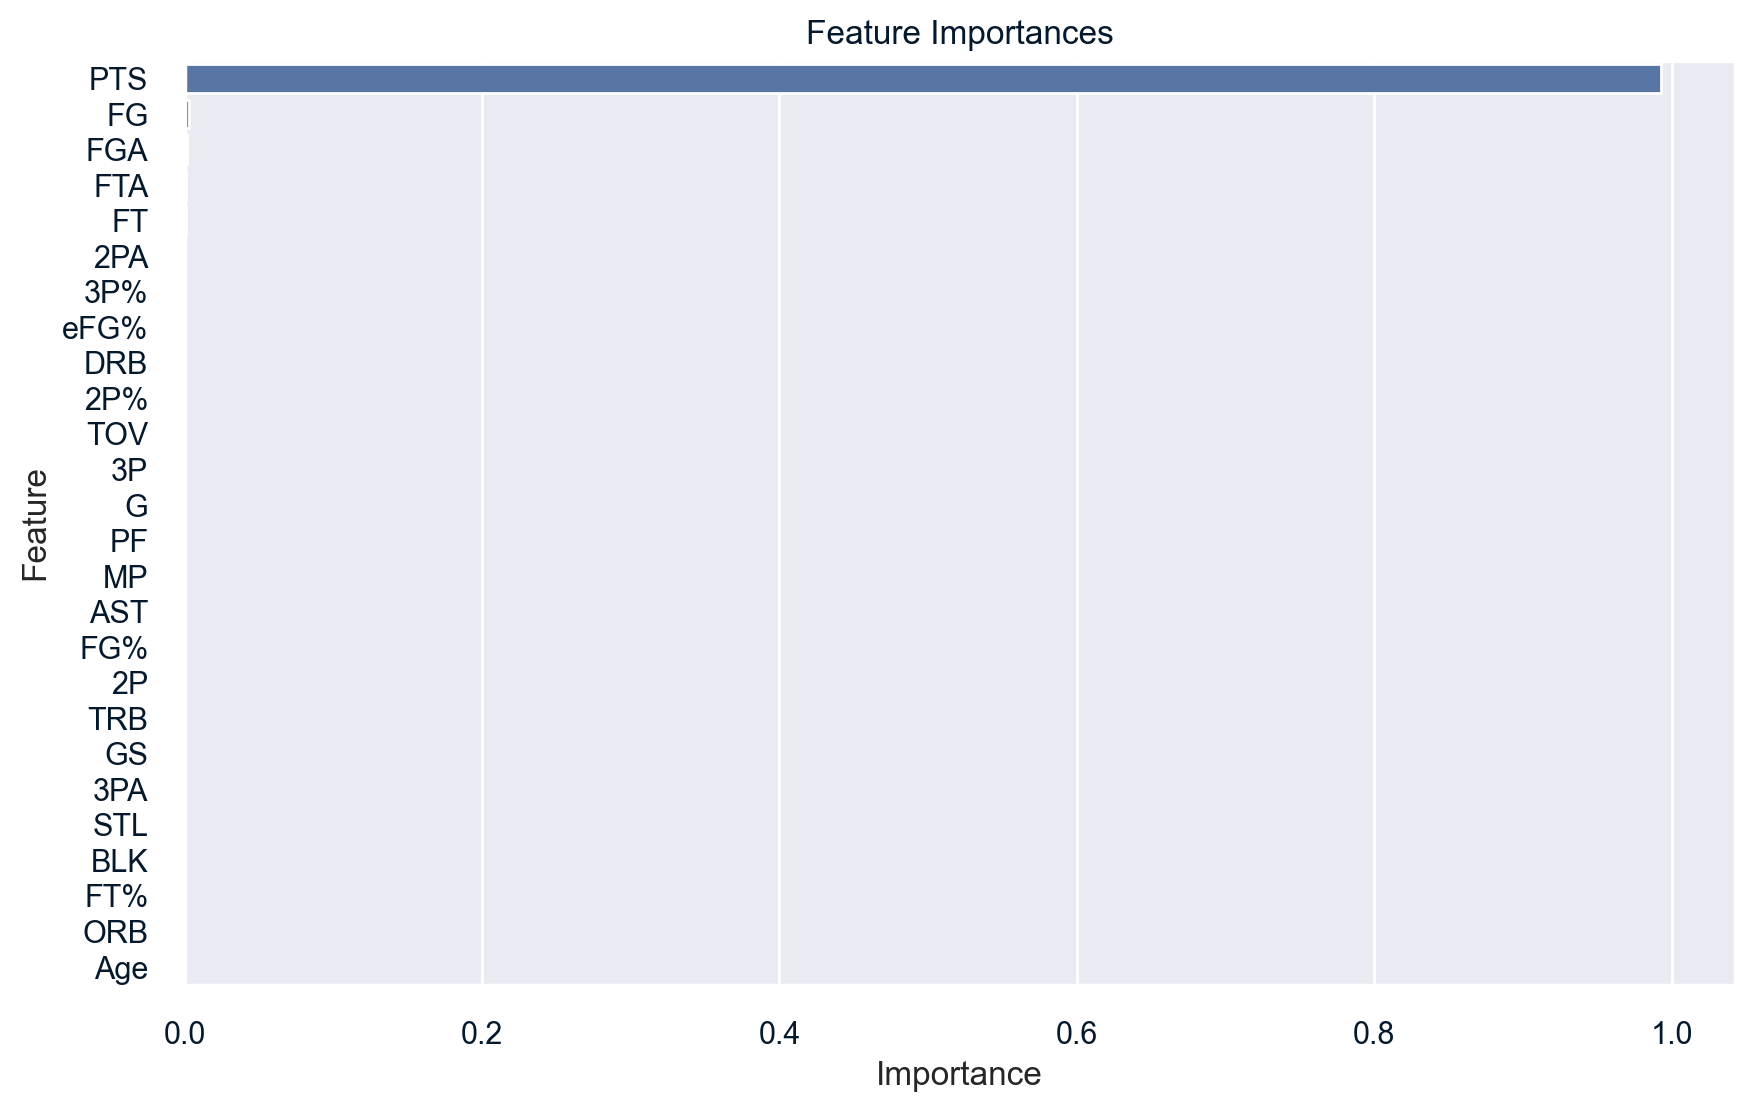

             Player   Pos   Tm Age_Segment PTS_Segment  Predicted_Weighted_Feature_2025
0  Precious Achiuwa  PF-C  TOT       18-25        0-10                            7.560
1  Precious Achiuwa     C  TOR       18-25        0-10                            7.666
2  Precious Achiuwa    PF  NYK       18-25        0-10                            7.555
3       Bam Adebayo     C  MIA       26-30       11-20                           19.256
4      Ochai Agbaji    SG  TOT       18-25        0-10                            5.792
2025 yılında en yüksek Weighted_Feature değerine sahip 10 oyuncu:
                      Player Pos   Tm Age_Segment PTS_Segment  Predicted_Weighted_Feature_2025
186              Joel Embiid   C  PHI       26-30       31-40                           33.191
171              Luka Don?i?  PG  DAL       18-25       31-40                           32.588
14     Giannis Antetokounmpo  PF  MIL       26-30       31-40                           30.498
235  Shai Gilgeous-Alexand

In [90]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
import numpy as np
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

# Orijinal veri setini yükleme
regular_season_df = pd.read_csv('./2023-2024 NBA Player Stats - Regular.csv', encoding='latin1', delimiter=';')

# Sayısal olmayan sütunları tespit etme ve temizleme
df_numeric = regular_season_df.apply(pd.to_numeric, errors='coerce')

df_numeric.fillna(df_numeric.mean(), inplace=True)

bins_age = [18, 25, 30, 35, 40]
labels_age = ['18-25', '26-30', '31-35', '36-40']
df_numeric['Age_Segment'] = pd.cut(regular_season_df['Age'], bins=bins_age, labels=labels_age, right=False)

bins_pts = [0, 10, 20, 30, 40, 50]
labels_pts = ['0-10', '11-20', '21-30', '31-40', '41-50']
df_numeric['PTS_Segment'] = pd.cut(df_numeric['PTS'], bins=bins_pts, labels=labels_pts, right=False)

X = df_numeric.drop(columns=['Rk', 'Player', 'Pos', 'Tm', 'Age_Segment', 'PTS_Segment'])  # Özellikler
y = df_numeric['PTS']  # Hedef değişken

# Modeli tanımlama
model = RandomForestRegressor(random_state=42)

# Modeli tüm veri seti ile eğitme
model.fit(X, y)

# Özellik önemlerini hesaplama
feature_importances = model.feature_importances_

# Özellik önemlerini görselleştirme
feature_importances_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances_df)
plt.title('Feature Importances')
plt.show()

# 2025 yılı için her bir özelliği tahmin etme
X_2025 = pd.DataFrame()
for column in X.columns:
    model.fit(X, df_numeric[column])
    X_2025[column] = model.predict(X)

# Ağırlıklı ortalama mantığı ile 2025 yılı için yeni bir özellik oluşturma
weighted_feature_2025 = np.dot(X_2025, feature_importances)

# Yeni özelliği 2025 yılı veri setine ekleme
X_2025['Weighted_Feature_2025'] = weighted_feature_2025

# 2025 yılı için tahmin edilen sonuçları ve oyuncu isimlerini birleştirerek gösterme
results_2025 = pd.DataFrame({
    'Player': regular_season_df['Player'],
    'Pos': regular_season_df['Pos'],
    'Tm': regular_season_df['Tm'],
    'Age_Segment': df_numeric['Age_Segment'],
    'PTS_Segment': df_numeric['PTS_Segment'],
    'Predicted_Weighted_Feature_2025': weighted_feature_2025
})
results_2025 = results_2025.reset_index(drop=True)
print(results_2025.head())

# 2025 yılında en yüksek Weighted_Feature değerine sahip 10 oyuncuyu belirleme
top_10_champions_2025 = results_2025.nlargest(10, 'Predicted_Weighted_Feature_2025')
print("2025 yılında en yüksek Weighted_Feature değerine sahip 10 oyuncu:")
print(top_10_champions_2025)

# Gerçek ve tahmin edilen değerleri görselleştirme
fig1 = px.scatter(results_2025, x='Player', y='Predicted_Weighted_Feature_2025', color='Pos', hover_data=['Player', 'Pos', 'Tm', 'Age_Segment', 'PTS_Segment'], title='Predicted Weighted Feature for 2025')
fig1.show()

# En yüksek Weighted_Feature değerine sahip 10 oyuncuyu görselleştirme
fig2 = px.bar(top_10_champions_2025, x='Player', y='Predicted_Weighted_Feature_2025', color='Pos', title='Top 10 Players by Predicted Weighted Feature in 2025')
fig2.show()

In [91]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

# Orijinal veri setini yükleme
regular_season_df = pd.read_csv('./2023-2024 NBA Player Stats - Regular.csv', encoding='latin1', delimiter=';')

# Sayısal olmayan sütunları tespit etme ve temizleme
df_numeric = regular_season_df.apply(pd.to_numeric, errors='coerce')

# NaN değerleri ortalama ile doldurma
df_numeric.fillna(df_numeric.mean(), inplace=True)

# Segmentasyon: Yaş ve Puanlara göre segmentasyon
bins_age = [18, 25, 30, 35, 40]
labels_age = ['18-25', '26-30', '31-35', '36-40']
df_numeric['Age_Segment'] = pd.cut(regular_season_df['Age'], bins=bins_age, labels=labels_age, right=False)

bins_pts = [0, 10, 20, 30, 40, 50]
labels_pts = ['0-10', '11-20', '21-30', '31-40', '41-50']
df_numeric['PTS_Segment'] = pd.cut(df_numeric['PTS'], bins=bins_pts, labels=labels_pts, right=False)

X = df_numeric.drop(columns=['Rk', 'Player', 'Pos', 'Tm', 'Age_Segment', 'PTS_Segment'])  # Özellikler
y = df_numeric['PTS']  # Hedef değişken

model = RandomForestRegressor(random_state=42)

model.fit(X, y)

feature_importances = model.feature_importances_

# 2025 yılı için her bir özelliği tahmin etme
X_2025 = pd.DataFrame()
for column in X.columns:
    model.fit(X, df_numeric[column])
    X_2025[column] = model.predict(X)

weighted_feature_2025 = np.dot(X_2025, feature_importances)

X_2025['Weighted_Feature_2025'] = weighted_feature_2025

results_2025 = pd.DataFrame({
    'Player': regular_season_df['Player'],
    'Pos': regular_season_df['Pos'],
    'Tm': regular_season_df['Tm'],
    'Age_Segment': df_numeric['Age_Segment'],
    'PTS_Segment': df_numeric['PTS_Segment'],
    'Predicted_Weighted_Feature_2025': weighted_feature_2025
})
results_2025 = results_2025.reset_index(drop=True)
print(results_2025.head())

top_10_champions_2025 = results_2025.nlargest(10, 'Predicted_Weighted_Feature_2025')
print("2025 yılında en yüksek Weighted_Feature değerine sahip 10 oyuncu:")
print(top_10_champions_2025)

fig1 = px.scatter(results_2025, x='Player', y='Predicted_Weighted_Feature_2025', color='Pos', hover_data=['Player', 'Pos', 'Tm', 'Age_Segment', 'PTS_Segment'], title='Predicted Weighted Feature for 2025')
fig1.show()
fig2 = px.bar(top_10_champions_2025, x='Player', y='Predicted_Weighted_Feature_2025', color='Pos', title='Top 10 Players by Predicted Weighted Feature in 2025')
fig2.show()

cv_mse = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
cv_mae = cross_val_score(model, X, y, cv=5, scoring='neg_mean_absolute_error')

cv_mse = -cv_mse
cv_mae = -cv_mae

mean_mse = np.mean(cv_mse)
std_mse = np.std(cv_mse)
mean_mae = np.mean(cv_mae)
std_mae = np.std(cv_mae)

print(f"Cross-Validation Mean MSE: {mean_mse}")
print(f"Cross-Validation Std MSE: {std_mse}")
print(f"Cross-Validation Mean MAE: {mean_mae}")
print(f"Cross-Validation Std MAE: {std_mae}")

             Player   Pos   Tm Age_Segment PTS_Segment  Predicted_Weighted_Feature_2025
0  Precious Achiuwa  PF-C  TOT       18-25        0-10                            7.560
1  Precious Achiuwa     C  TOR       18-25        0-10                            7.666
2  Precious Achiuwa    PF  NYK       18-25        0-10                            7.555
3       Bam Adebayo     C  MIA       26-30       11-20                           19.256
4      Ochai Agbaji    SG  TOT       18-25        0-10                            5.792
2025 yılında en yüksek Weighted_Feature değerine sahip 10 oyuncu:
                      Player Pos   Tm Age_Segment PTS_Segment  Predicted_Weighted_Feature_2025
186              Joel Embiid   C  PHI       26-30       31-40                           33.191
171              Luka Don?i?  PG  DAL       18-25       31-40                           32.588
14     Giannis Antetokounmpo  PF  MIL       26-30       31-40                           30.498
235  Shai Gilgeous-Alexand

Cross-Validation Mean MSE: 0.12020344353741438
Cross-Validation Std MSE: 0.2095222157316916
Cross-Validation Mean MAE: 0.0643768707482997
Cross-Validation Std MAE: 0.03605388386198646


Cross-Validation Mean MSE: 0.19995923954646772
Cross-Validation Std MSE: 0.12182423863293648
Cross-Validation Mean MAE: 0.22690418347779223
Cross-Validation Std MAE: 0.027509116113752716


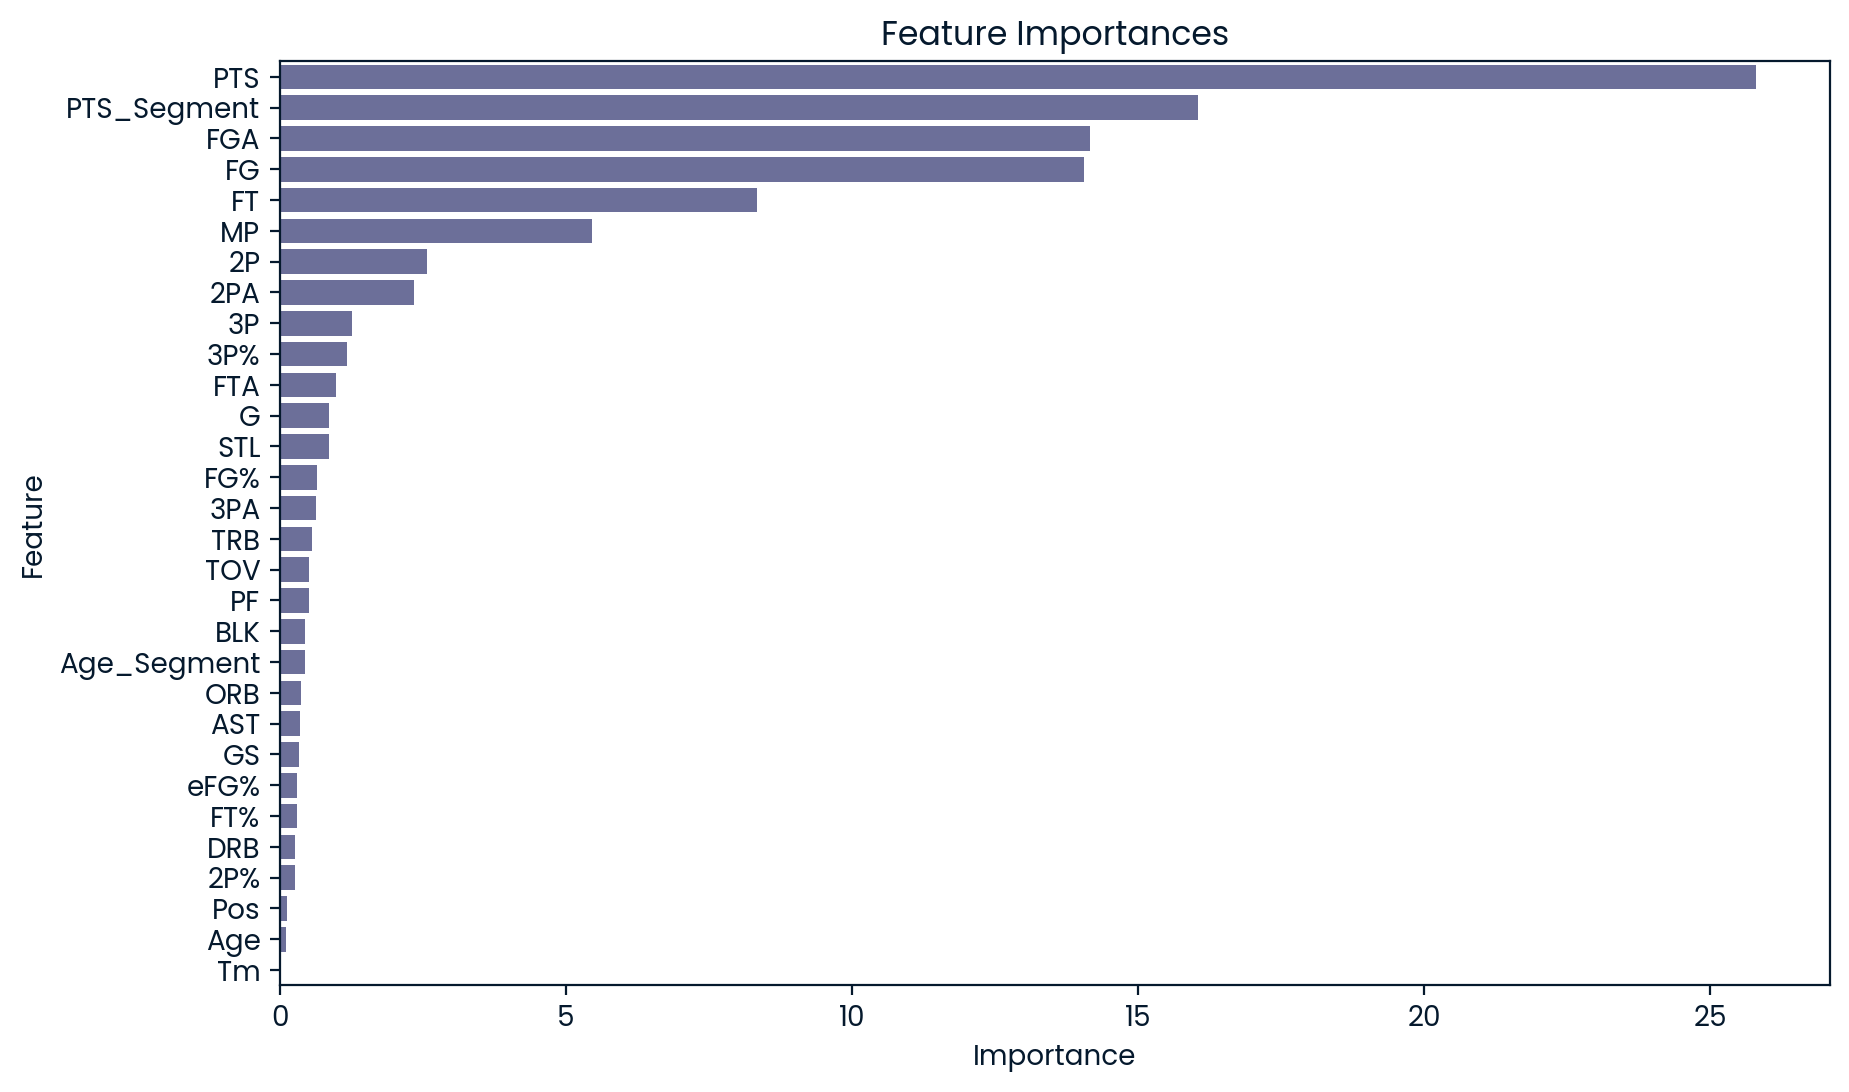

             Player   Pos  ... PTS_Segment Predicted_Weighted_Feature_2025
0  Precious Achiuwa  PF-C  ...        0-10                      765.747363
1  Precious Achiuwa     C  ...        0-10                      780.140697
2  Precious Achiuwa    PF  ...        0-10                      764.283914
3       Bam Adebayo     C  ...       11-20                     1945.046624
4      Ochai Agbaji    SG  ...        0-10                      612.513429

[5 rows x 6 columns]
2025 yılında en yüksek Weighted_Feature değerine sahip 10 oyuncu:
                      Player Pos  ... PTS_Segment Predicted_Weighted_Feature_2025
186              Joel Embiid   C  ...       31-40                     3406.266261
171              Luka Don?i?  PG  ...       31-40                     3386.628230
235  Shai Gilgeous-Alexander  PG  ...       31-40                     2976.769231
109            Jalen Brunson  PG  ...       21-30                     2859.962188
14     Giannis Antetokounmpo  PF  ...       31-40   

In [3]:
import pandas as pd
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

# Orijinal veri setini yükleme
regular_season_df = pd.read_csv('./2023-2024 NBA Player Stats - Regular.csv', encoding='latin1', delimiter=';')

# Sayısal olmayan sütunları tespit etme ve temizleme
df_numeric = regular_season_df.apply(pd.to_numeric, errors='coerce')

# NaN değerleri ortalama ile doldurma
df_numeric.fillna(df_numeric.mean(), inplace=True)

# Segmentasyon: Yaş ve Puanlara göre segmentasyon
bins_age = [18, 25, 30, 35, 40]
labels_age = ['18-25', '26-30', '31-35', '36-40']
df_numeric['Age_Segment'] = pd.cut(regular_season_df['Age'], bins=bins_age, labels=labels_age, right=False)

bins_pts = [0, 10, 20, 30, 40, 50]
labels_pts = ['0-10', '11-20', '21-30', '31-40', '41-50']
df_numeric['PTS_Segment'] = pd.cut(df_numeric['PTS'], bins=bins_pts, labels=labels_pts, right=False)

# Kategorik özellikleri ekleme
df_numeric['Pos'] = regular_season_df['Pos']
df_numeric['Tm'] = regular_season_df['Tm']

# Özellik ve hedef değişkeni belirleme
X = df_numeric.drop(columns=['Rk', 'Player'])  # Özellikler
y = df_numeric['PTS']  # Hedef değişken

# Kategorik özellikleri belirleme
categorical_features = ['Pos', 'Tm', 'Age_Segment', 'PTS_Segment']

# CatBoost modelini tanımlama
model = CatBoostRegressor(random_seed=42, verbose=0)

# K-Fold çapraz doğrulama
kf = KFold(n_splits=5, shuffle=True, random_state=42)
mse_scores = []
mae_scores = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    train_pool = Pool(data=X_train, label=y_train, cat_features=categorical_features)
    test_pool = Pool(data=X_test, label=y_test, cat_features=categorical_features)
    
    model.fit(train_pool)
    
    y_pred = model.predict(test_pool)
    
    mse_scores.append(mean_squared_error(y_test, y_pred))
    mae_scores.append(mean_absolute_error(y_test, y_pred))

mean_mse = np.mean(mse_scores)
std_mse = np.std(mse_scores)
mean_mae = np.mean(mae_scores)
std_mae = np.std(mae_scores)

print(f"Cross-Validation Mean MSE: {mean_mse}")
print(f"Cross-Validation Std MSE: {std_mse}")
print(f"Cross-Validation Mean MAE: {mean_mae}")
print(f"Cross-Validation Std MAE: {std_mae}")

# Özellik önemlerini hesaplama
feature_importances = model.get_feature_importance()

# Özellik önemlerini görselleştirme
feature_importances_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances_df)
plt.title('Feature Importances')
plt.show()

# 2025 yılı için her bir özelliği tahmin etme
X_2025 = pd.DataFrame()
for column in X.columns:
    model.fit(train_pool)
    X_2025[column] = model.predict(X)

# Ağırlıklı ortalama mantığı ile 2025 yılı için yeni bir özellik oluşturma
weighted_feature_2025 = np.dot(X_2025, feature_importances)

# Yeni özelliği 2025 yılı veri setine ekleme
X_2025['Weighted_Feature_2025'] = weighted_feature_2025

# 2025 yılı için tahmin edilen sonuçları ve oyuncu isimlerini birleştirerek gösterme
results_2025 = pd.DataFrame({
    'Player': regular_season_df['Player'],
    'Pos': regular_season_df['Pos'],
    'Tm': regular_season_df['Tm'],
    'Age_Segment': df_numeric['Age_Segment'],
    'PTS_Segment': df_numeric['PTS_Segment'],
    'Predicted_Weighted_Feature_2025': weighted_feature_2025
})
results_2025 = results_2025.reset_index(drop=True)
print(results_2025.head())

# 2025 yılında en yüksek Weighted_Feature değerine sahip 10 oyuncuyu belirleme
top_10_champions_2025 = results_2025.nlargest(10, 'Predicted_Weighted_Feature_2025')
print("2025 yılında en yüksek Weighted_Feature değerine sahip 10 oyuncu:")
print(top_10_champions_2025)

# Gerçek ve tahmin edilen değerleri görselleştirme
fig1 = px.scatter(results_2025, x='Player', y='Predicted_Weighted_Feature_2025', color='Pos', hover_data=['Player', 'Pos', 'Tm', 'Age_Segment', 'PTS_Segment'], title='Predicted Weighted Feature for 2025')
fig1.show()

# En yüksek Weighted_Feature değerine sahip 10 oyuncuyu görselleştirme
fig2 = px.bar(top_10_champions_2025, x='Player', y='Predicted_Weighted_Feature_2025', color='Pos', title='Top 10 Players by Predicted Weighted Feature in 2025')
fig2.show()

In [13]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor

# Orijinal veri setini yükleme
regular_season_df = pd.read_csv('./2023-2024 NBA Player Stats - Regular.csv', encoding='latin1', delimiter=';')

# Sayısal olmayan sütunları tespit etme ve temizleme
df_numeric = regular_season_df.apply(pd.to_numeric, errors='coerce')
df_numeric.fillna(df_numeric.mean(), inplace=True)

# Segmentasyon: Yaş ve Puanlara göre segmentasyon
bins_age = [18, 25, 30, 35, 40]
labels_age = ['18-25', '26-30', '31-35', '36-40']
df_numeric['Age_Segment'] = pd.cut(regular_season_df['Age'], bins=bins_age, labels=labels_age, right=False)

bins_pts = [0, 10, 20, 30, 40, 50]
labels_pts = ['0-10', '11-20', '21-30', '31-40', '41-50']
df_numeric['PTS_Segment'] = pd.cut(df_numeric['PTS'], bins=bins_pts, labels=labels_pts, right=False)

X = df_numeric.drop(columns=['Rk', 'Player', 'Pos', 'Tm', 'Age_Segment', 'PTS_Segment'])  # Özellikler
y = df_numeric['PTS']  # Hedef değişken

model = RandomForestRegressor(random_state=42)

# Modeli tüm veri seti ile eğitme
model.fit(X, y)

# Özellik önemlerini hesaplama
feature_importances = model.feature_importances_

# 2025 yılı için her bir özelliği tahmin etme
X_2025 = pd.DataFrame()
for column in X.columns:
    model.fit(X, df_numeric[column])
    X_2025[column] = model.predict(X)

# Ağırlıklı ortalama mantığı ile 2025 yılı için yeni bir özellik oluşturma
weighted_feature_2025 = np.dot(X_2025, feature_importances)

# Yeni özelliği 2025 yılı veri setine ekleme
X_2025['Weighted_Feature_2025'] = weighted_feature_2025

# 2025 yılı için tahmin edilen sonuçları ve oyuncu isimlerini birleştirerek gösterme
results_2025 = pd.DataFrame({
    'Player': regular_season_df['Player'],
    'Pos': regular_season_df['Pos'],
    'Tm': regular_season_df['Tm'],
    'Age_Segment': df_numeric['Age_Segment'],
    'PTS_Segment': df_numeric['PTS_Segment'],
    'Predicted_Weighted_Feature_2025': weighted_feature_2025
})
results_2025 = results_2025.reset_index(drop=True)

# En iyi pozisyonlardaki oyuncuları seçme
best_players = results_2025.loc[results_2025.groupby('Pos')['Predicted_Weighted_Feature_2025'].idxmax()]

# En iyi pozisyonlardaki oyuncuları gösterme
print("En iyi pozisyonlardaki en yüksek weighted feature puanına sahip oyuncular:")
print(best_players)

En iyi pozisyonlardaki en yüksek weighted feature puanına sahip oyuncular:
                    Player    Pos  ... PTS_Segment Predicted_Weighted_Feature_2025
186            Joel Embiid      C  ...       31-40                       33.191105
215         Daniel Gafford   C-PF  ...       11-20                       10.958940
14   Giannis Antetokounmpo     PF  ...       31-40                       30.497683
0         Precious Achiuwa   PF-C  ...        0-10                        7.559831
218       Danilo Gallinari  PF-SF  ...        0-10                        5.673969
171            Luka Don?i?     PG  ...       31-40                       32.587672
571           Terry Rozier  PG-SG  ...       11-20                       19.703496
159          DeMar DeRozan     SF  ...       21-30                       23.843979
74        Bojan Bogdanovi?  SF-PF  ...       11-20                       15.126909
288            Buddy Hield  SF-SG  ...       11-20                       12.066063
454       Do

In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor

# Orijinal veri setini yükleme
regular_season_df = pd.read_csv('./2023-2024 NBA Player Stats - Regular.csv', encoding='latin1', delimiter=';')

# Sayısal olmayan sütunları tespit etme ve temizleme
df_numeric = regular_season_df.apply(pd.to_numeric, errors='coerce')
df_numeric.fillna(df_numeric.mean(), inplace=True)

# Segmentasyon: Yaş ve Puanlara göre segmentasyon
bins_age = [18, 25, 30, 35, 40]
labels_age = ['18-25', '26-30', '31-35', '36-40']
df_numeric['Age_Segment'] = pd.cut(regular_season_df['Age'], bins=bins_age, labels=labels_age, right=False)

bins_pts = [0, 10, 20, 30, 40, 50]
labels_pts = ['0-10', '11-20', '21-30', '31-40', '41-50']
df_numeric['PTS_Segment'] = pd.cut(df_numeric['PTS'], bins=bins_pts, labels=labels_pts, right=False)

X = df_numeric.drop(columns=['Rk', 'Player', 'Pos', 'Tm', 'Age_Segment', 'PTS_Segment'])  # Özellikler
y = df_numeric['PTS']  # Hedef değişken

model = RandomForestRegressor(random_state=42)

# Modeli tüm veri seti ile eğitme
model.fit(X, y)

# Özellik önemlerini hesaplama
feature_importances = model.feature_importances_

# 2025 yılı için her bir özelliği tahmin etme
X_2025 = pd.DataFrame()
for column in X.columns:
    model.fit(X, df_numeric[column])
    X_2025[column] = model.predict(X)

# Ağırlıklı ortalama mantığı ile 2025 yılı için yeni bir özellik oluşturma
weighted_feature_2025 = np.dot(X_2025, feature_importances)

# Yeni özelliği 2025 yılı veri setine ekleme
X_2025['Weighted_Feature_2025'] = weighted_feature_2025

# 2025 yılı için tahmin edilen sonuçları ve oyuncu isimlerini birleştirerek gösterme
results_2025 = pd.DataFrame({
    'Player': regular_season_df['Player'],
    'Pos': regular_season_df['Pos'],
    'Tm': regular_season_df['Tm'],
    'Age_Segment': df_numeric['Age_Segment'],
    'PTS_Segment': df_numeric['PTS_Segment'],
    'Predicted_Weighted_Feature_2025': weighted_feature_2025
})
results_2025 = results_2025.reset_index(drop=True)

# En iyi pozisyonlardaki oyuncuları seçme
best_players = results_2025.loc[results_2025.groupby('Pos')['Predicted_Weighted_Feature_2025'].idxmax()]

# En iyi pozisyonlardaki oyuncuları gösterme
print("En iyi pozisyonlardaki en yüksek weighted feature puanına sahip oyuncular:")
print(best_players)

# Yeni takımı kaydetme
best_players.to_csv('best_players_team.csv', index=False)
print("Yeni takım 'best_players_team.csv' dosyasına kaydedildi.")

En iyi pozisyonlardaki en yüksek weighted feature puanına sahip oyuncular:
                    Player    Pos  ... PTS_Segment Predicted_Weighted_Feature_2025
186            Joel Embiid      C  ...       31-40                       33.191105
215         Daniel Gafford   C-PF  ...       11-20                       10.958940
14   Giannis Antetokounmpo     PF  ...       31-40                       30.497683
0         Precious Achiuwa   PF-C  ...        0-10                        7.559831
218       Danilo Gallinari  PF-SF  ...        0-10                        5.673969
171            Luka Don?i?     PG  ...       31-40                       32.587672
571           Terry Rozier  PG-SG  ...       11-20                       19.703496
159          DeMar DeRozan     SF  ...       21-30                       23.843979
74        Bojan Bogdanovi?  SF-PF  ...       11-20                       15.126909
288            Buddy Hield  SF-SG  ...       11-20                       12.066063
454       Do